In [1]:
%matplotlib inline
import copy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from alphamind.api import *
from PyFin.api import *
from PyFin.Math.Accumulators.StatefulAccumulators import MovingAverage
from PyFin.Math.Accumulators.StatefulAccumulators import MovingSharp
from PyFin.Math.Accumulators.StatefulAccumulators import MovingMaxDrawdown

plt.style.use('ggplot')

In [2]:
start_date = '2010-01-01'
end_date = '2018-02-1'
benchmark_code = 300
universe_name = ['zz800']
universe = Universe(universe_name, universe_name)
frequency = '10b'
batch = 16
method = 'risk_neutral'
neutralize_risk = ['SIZE'] + industry_styles

horizon = map_freq(frequency)
hedging_ratio = 0.

executor = NaiveExecutor()

In [3]:
engine = SqlEngine()
#factor_coverage = engine.fetch_factor_coverage()

In [4]:
#res = factor_coverage[(factor_coverage.universe == 'ashare_ex') & (factor_coverage.source != 'risk_exposure')].groupby('factor').mean().sort_values('coverage', ascending=False)
#model_features = sorted(res[res.coverage >= 0.99].index.unique().tolist())

base1 = LAST('roe_q')
base2 = CSRes('ep_q', base1)

const_features_keys = {'f01': base1,
                       'f02': base2,
                       'f03': CSRes(CSRes('market_confidence_15d', base1), base2),
                       'f04': CSRes(CSRes('RecievableTO', base1), base2),
                       'f05': CSRes(CSRes('val_q', base1), base2),
                       'f06': CSRes(CSRes('BP', base1), base2),
                       'f07': CSRes(CSRes('con_pe_rolling_order', base1), base2),
                       'f08': CSRes(CSRes('con_pb_rolling_order', base1), base2),
                       'f09': CSRes(CSRes('DebtEquityRatio', base1), base2),
                      }

const_model_features_keys = sorted(const_features_keys.keys())

const_weights = [1.0,
                 1.0,
                 0.25,
                 0.25,
                 0.25,
                 0.25,
                 -0.25,
                 -0.25,
                 -0.25
                ]

model_features = copy.deepcopy(const_features_keys)

In [5]:
"""
Data phase
"""

model_factor_data = fetch_data_package(engine,
                                       alpha_factors=model_features,
                                       start_date=start_date,
                                       end_date=end_date,
                                       frequency=frequency,
                                       universe=universe,
                                       benchmark=benchmark_code,
                                       batch=batch,
                                       neutralized_risk=neutralize_risk,
                                       pre_process=[winsorize_normal, standardize],
                                       post_process=[winsorize_normal, standardize],
                                       warm_start=batch)

model_features_keys = model_factor_data['x_names']

train_x = model_factor_data['train']['x']
train_y = model_factor_data['train']['y']
train_risk = model_factor_data['train']['risk']
ref_dates = sorted(train_x.keys())

predict_x = model_factor_data['predict']['x']
predict_y = model_factor_data['predict']['y']
predict_risk = model_factor_data['predict']['risk']
predict_code = model_factor_data['predict']['code']
settlement = model_factor_data['settlement']

2018-02-05 12:13:42,906 - ALPHA_MIND - INFO - Starting data package fetching ...
2018-02-05 12:13:50,160 - ALPHA_MIND - INFO - factor data loading finished
2018-02-05 12:14:05,184 - ALPHA_MIND - INFO - return data loading finished
2018-02-05 12:14:07,334 - ALPHA_MIND - INFO - industry data loading finished
2018-02-05 12:14:07,593 - ALPHA_MIND - INFO - benchmark data loading finished
2018-02-05 12:14:14,012 - ALPHA_MIND - INFO - risk data loading finished
2018-02-05 12:14:15,562 - ALPHA_MIND - INFO - data merging finished
2018-02-05 12:14:16,745 - ALPHA_MIND - INFO - Loading data is finished
2018-02-05 12:14:22,134 - ALPHA_MIND - INFO - Data processing is finished


In [6]:
model_features_keys

['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08', 'f09']

In [7]:
# for key, val in train_y.items():
#     train_y[key] = np.where(val > 0., 1, 0)
    
# for key, val in predict_y.items():
#     predict_y[key] = np.where(val > 0., 1, 0)

In [8]:
def cross_product(x, y):
    n, m = x.shape
    res = []
    
    for j in range(m):
        res.append(x[:, [j]] * y)
        
    return np.concatenate(res, axis=1)

In [9]:
%%time

"""
Training phase
"""

from dask.distributed import Client
client = Client('10.63.6.176:8786')

params = [(train_x[ref_date], train_y[ref_date], ref_date) for ref_date in ref_dates]

def train_model(param):
    from alphamind.api import XGBTrainer
    from alphamind.api import alpha_logger
    x = param[0]
    y = param[1]
    ref_date = param[2]
    model = XGBTrainer(features=model_features_keys,
                       objective='reg:linear',
                       booster='gbtree',
                       tree_method='hist',
                       n_estimators=2000,
                       learning_rate=0.01,
                       early_stopping_rounds=30,
                       subsample=0.25,
                       colsample_bytree=1.,
                       n_jobs=1,
                       eval_sample=0.3)
    model.fit(x, y)
    alpha_logger.info('trade_date: {0} with {1} obs training finished'.format(ref_date, len(x)))
    return ref_date, model

parameters = [(train_x[ref_date], train_y[ref_date], ref_date) for ref_date in ref_dates]
tasks = client.map(train_model, params)
res = client.gather(tasks) 

index, data = list(zip(*res))
xgb_models_series = pd.Series(data, index=index)

Wall time: 41.6 s


In [10]:
const_model = ConstLinearModel(features=const_features_keys,
                               weights=const_weights)

const_model_factor_data = engine.fetch_data_range(universe,
                                                  const_features_keys,
                                                  dates=ref_dates,
                                                  benchmark=benchmark_code)['factor']

industry_data = engine.fetch_industry_matrix_range(universe,
                                                   dates=ref_dates,
                                                   category='sw_adj',
                                                   level=1)
industries_list = industry_list(category='sw_adj', level=1)

horizon = map_freq(frequency)

2018-02-05 12:15:21,938 - ALPHA_MIND - INFO - 2010-08-30 00:00:00: 799


start 0.005 weight gap simulation ...
using backbone model and alpha model


D:\ProgramData\IntelPython3_2018\lib\site-packages\ipykernel_launcher.py:92: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
2018-02-05 12:15:22,158 - ALPHA_MIND - INFO - 2010-08-30 00:00:00 is finished
2018-02-05 12:15:22,163 - ALPHA_MIND - INFO - 2010-09-13 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:15:22,439 - ALPHA_MIND - INFO - 2010-09-13 00:00:00 is finished
2018-02-05 12:15:22,443 - ALPHA_MIND - INFO - 2010-09-30 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:15:22,719 - ALPHA_MIND - INFO - 2010-09-30 00:00:00 is finished
2018-02-05 12:15:22,724 - ALPHA_MIND - INFO - 2010-10-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:15:22,986 - ALPHA_MIND - INFO - 2010-10-21 00:00:00 is finished
2018-02-05 12:15:22,991 - ALPHA_MIND - INFO - 2010-11-04 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:15:23,272 - ALPHA_MIND - INFO - 2010-11-04 00:00:00 is finished
2018-02-05 12:15:23,277 - ALPHA_MIND - INFO - 2010-11-18 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:15:23,555 - ALPHA_MIND - INFO - 2010-11-18 00:00:00 is finished
2018-02-05 12:15:23,560 - ALPHA_MIND - INFO - 2010-12-02 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:15:23,835 - ALPHA_MIND - INFO - 2010-12-02 00:00:00 is finished
2018-02-05 12:15:23,840 - ALPHA_MIND - INFO - 2010-12-16 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:15:24,107 - ALPHA_MIND - INFO - 2010-12-16 00:00:00 is finished
2018-02-05 12:15:24,112 - ALPHA_MIND - INFO - 2010-12-30 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:15:24,390 - ALPHA_MIND - INFO - 2010-12-30 00:00:00 is finished
2018-02-05 12:15:24,395 - ALPHA_MIND - INFO - 2011-01-14 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:15:24,670 - ALPHA_MIND - INFO - 2011-01-14 00:00:00 is finished
2018-02-05 12:15:24,674 - ALPHA_MIND - INFO - 2011-01-28 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:15:25,031 - ALPHA_MIND - INFO - 2011-01-28 00:00:00 is finished
2018-02-05 12:15:25,035 - ALPHA_MIND - INFO - 2011-02-18 00:00:00: 797


using backbone model and alpha model


2018-02-05 12:15:25,318 - ALPHA_MIND - INFO - 2011-02-18 00:00:00 is finished
2018-02-05 12:15:25,324 - ALPHA_MIND - INFO - 2011-03-04 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:15:25,606 - ALPHA_MIND - INFO - 2011-03-04 00:00:00 is finished
2018-02-05 12:15:25,611 - ALPHA_MIND - INFO - 2011-03-18 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:15:25,891 - ALPHA_MIND - INFO - 2011-03-18 00:00:00 is finished
2018-02-05 12:15:25,895 - ALPHA_MIND - INFO - 2011-04-01 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:15:26,183 - ALPHA_MIND - INFO - 2011-04-01 00:00:00 is finished
2018-02-05 12:15:26,187 - ALPHA_MIND - INFO - 2011-04-19 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:15:26,475 - ALPHA_MIND - INFO - 2011-04-19 00:00:00 is finished
2018-02-05 12:15:26,480 - ALPHA_MIND - INFO - 2011-05-04 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:15:26,772 - ALPHA_MIND - INFO - 2011-05-04 00:00:00 is finished
2018-02-05 12:15:26,777 - ALPHA_MIND - INFO - 2011-05-18 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:15:27,077 - ALPHA_MIND - INFO - 2011-05-18 00:00:00 is finished
2018-02-05 12:15:27,082 - ALPHA_MIND - INFO - 2011-06-01 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:15:27,370 - ALPHA_MIND - INFO - 2011-06-01 00:00:00 is finished
2018-02-05 12:15:27,375 - ALPHA_MIND - INFO - 2011-06-16 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:15:27,676 - ALPHA_MIND - INFO - 2011-06-16 00:00:00 is finished
2018-02-05 12:15:27,680 - ALPHA_MIND - INFO - 2011-06-30 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:15:27,973 - ALPHA_MIND - INFO - 2011-06-30 00:00:00 is finished
2018-02-05 12:15:27,978 - ALPHA_MIND - INFO - 2011-07-14 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:15:28,275 - ALPHA_MIND - INFO - 2011-07-14 00:00:00 is finished
2018-02-05 12:15:28,280 - ALPHA_MIND - INFO - 2011-07-28 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:15:28,572 - ALPHA_MIND - INFO - 2011-07-28 00:00:00 is finished
2018-02-05 12:15:28,577 - ALPHA_MIND - INFO - 2011-08-11 00:00:00: 797


using backbone model and alpha model


2018-02-05 12:15:28,872 - ALPHA_MIND - INFO - 2011-08-11 00:00:00 is finished
2018-02-05 12:15:28,877 - ALPHA_MIND - INFO - 2011-08-25 00:00:00: 796


using backbone model and alpha model


2018-02-05 12:15:29,166 - ALPHA_MIND - INFO - 2011-08-25 00:00:00 is finished
2018-02-05 12:15:29,171 - ALPHA_MIND - INFO - 2011-09-08 00:00:00: 797


using backbone model and alpha model


2018-02-05 12:15:29,458 - ALPHA_MIND - INFO - 2011-09-08 00:00:00 is finished
2018-02-05 12:15:29,464 - ALPHA_MIND - INFO - 2011-09-23 00:00:00: 797


using backbone model and alpha model


2018-02-05 12:15:29,842 - ALPHA_MIND - INFO - 2011-09-23 00:00:00 is finished
2018-02-05 12:15:29,847 - ALPHA_MIND - INFO - 2011-10-14 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:15:30,142 - ALPHA_MIND - INFO - 2011-10-14 00:00:00 is finished
2018-02-05 12:15:30,147 - ALPHA_MIND - INFO - 2011-10-28 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:15:30,443 - ALPHA_MIND - INFO - 2011-10-28 00:00:00 is finished
2018-02-05 12:15:30,448 - ALPHA_MIND - INFO - 2011-11-11 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:15:30,747 - ALPHA_MIND - INFO - 2011-11-11 00:00:00 is finished
2018-02-05 12:15:30,752 - ALPHA_MIND - INFO - 2011-11-25 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:15:31,054 - ALPHA_MIND - INFO - 2011-11-25 00:00:00 is finished
2018-02-05 12:15:31,059 - ALPHA_MIND - INFO - 2011-12-09 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:15:31,348 - ALPHA_MIND - INFO - 2011-12-09 00:00:00 is finished
2018-02-05 12:15:31,353 - ALPHA_MIND - INFO - 2011-12-23 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:15:31,644 - ALPHA_MIND - INFO - 2011-12-23 00:00:00 is finished
2018-02-05 12:15:31,649 - ALPHA_MIND - INFO - 2012-01-10 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:15:31,949 - ALPHA_MIND - INFO - 2012-01-10 00:00:00 is finished
2018-02-05 12:15:31,955 - ALPHA_MIND - INFO - 2012-01-31 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:15:32,281 - ALPHA_MIND - INFO - 2012-01-31 00:00:00 is finished
2018-02-05 12:15:32,287 - ALPHA_MIND - INFO - 2012-02-14 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:15:32,587 - ALPHA_MIND - INFO - 2012-02-14 00:00:00 is finished
2018-02-05 12:15:32,592 - ALPHA_MIND - INFO - 2012-02-28 00:00:00: 797


using backbone model and alpha model


2018-02-05 12:15:32,882 - ALPHA_MIND - INFO - 2012-02-28 00:00:00 is finished
2018-02-05 12:15:32,887 - ALPHA_MIND - INFO - 2012-03-13 00:00:00: 797


using backbone model and alpha model


2018-02-05 12:15:33,170 - ALPHA_MIND - INFO - 2012-03-13 00:00:00 is finished
2018-02-05 12:15:33,175 - ALPHA_MIND - INFO - 2012-03-27 00:00:00: 796


using backbone model and alpha model


2018-02-05 12:15:33,459 - ALPHA_MIND - INFO - 2012-03-27 00:00:00 is finished
2018-02-05 12:15:33,464 - ALPHA_MIND - INFO - 2012-04-13 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:15:33,765 - ALPHA_MIND - INFO - 2012-04-13 00:00:00 is finished
2018-02-05 12:15:33,771 - ALPHA_MIND - INFO - 2012-04-27 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:15:34,065 - ALPHA_MIND - INFO - 2012-04-27 00:00:00 is finished
2018-02-05 12:15:34,070 - ALPHA_MIND - INFO - 2012-05-15 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:15:34,443 - ALPHA_MIND - INFO - 2012-05-15 00:00:00 is finished
2018-02-05 12:15:34,447 - ALPHA_MIND - INFO - 2012-05-29 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:15:34,737 - ALPHA_MIND - INFO - 2012-05-29 00:00:00 is finished
2018-02-05 12:15:34,741 - ALPHA_MIND - INFO - 2012-06-12 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:15:35,035 - ALPHA_MIND - INFO - 2012-06-12 00:00:00 is finished
2018-02-05 12:15:35,042 - ALPHA_MIND - INFO - 2012-06-27 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:15:35,344 - ALPHA_MIND - INFO - 2012-06-27 00:00:00 is finished
2018-02-05 12:15:35,349 - ALPHA_MIND - INFO - 2012-07-11 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:15:35,661 - ALPHA_MIND - INFO - 2012-07-11 00:00:00 is finished
2018-02-05 12:15:35,666 - ALPHA_MIND - INFO - 2012-07-25 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:15:35,968 - ALPHA_MIND - INFO - 2012-07-25 00:00:00 is finished
2018-02-05 12:15:35,973 - ALPHA_MIND - INFO - 2012-08-08 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:15:36,266 - ALPHA_MIND - INFO - 2012-08-08 00:00:00 is finished
2018-02-05 12:15:36,271 - ALPHA_MIND - INFO - 2012-08-22 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:15:36,562 - ALPHA_MIND - INFO - 2012-08-22 00:00:00 is finished
2018-02-05 12:15:36,568 - ALPHA_MIND - INFO - 2012-09-05 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:15:36,869 - ALPHA_MIND - INFO - 2012-09-05 00:00:00 is finished
2018-02-05 12:15:36,874 - ALPHA_MIND - INFO - 2012-09-19 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:15:37,160 - ALPHA_MIND - INFO - 2012-09-19 00:00:00 is finished
2018-02-05 12:15:37,165 - ALPHA_MIND - INFO - 2012-10-10 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:15:37,456 - ALPHA_MIND - INFO - 2012-10-10 00:00:00 is finished
2018-02-05 12:15:37,460 - ALPHA_MIND - INFO - 2012-10-24 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:15:37,756 - ALPHA_MIND - INFO - 2012-10-24 00:00:00 is finished
2018-02-05 12:15:37,763 - ALPHA_MIND - INFO - 2012-11-07 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:15:38,082 - ALPHA_MIND - INFO - 2012-11-07 00:00:00 is finished
2018-02-05 12:15:38,088 - ALPHA_MIND - INFO - 2012-11-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:15:38,417 - ALPHA_MIND - INFO - 2012-11-21 00:00:00 is finished
2018-02-05 12:15:38,422 - ALPHA_MIND - INFO - 2012-12-05 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:15:38,745 - ALPHA_MIND - INFO - 2012-12-05 00:00:00 is finished
2018-02-05 12:15:38,752 - ALPHA_MIND - INFO - 2012-12-19 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:15:39,076 - ALPHA_MIND - INFO - 2012-12-19 00:00:00 is finished
2018-02-05 12:15:39,082 - ALPHA_MIND - INFO - 2013-01-07 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:15:39,597 - ALPHA_MIND - INFO - 2013-01-07 00:00:00 is finished
2018-02-05 12:15:39,604 - ALPHA_MIND - INFO - 2013-01-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:15:39,920 - ALPHA_MIND - INFO - 2013-01-21 00:00:00 is finished
2018-02-05 12:15:39,926 - ALPHA_MIND - INFO - 2013-02-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:40,234 - ALPHA_MIND - INFO - 2013-02-04 00:00:00 is finished
2018-02-05 12:15:40,240 - ALPHA_MIND - INFO - 2013-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:40,563 - ALPHA_MIND - INFO - 2013-02-25 00:00:00 is finished
2018-02-05 12:15:40,570 - ALPHA_MIND - INFO - 2013-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:40,915 - ALPHA_MIND - INFO - 2013-03-11 00:00:00 is finished
2018-02-05 12:15:40,922 - ALPHA_MIND - INFO - 2013-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:41,247 - ALPHA_MIND - INFO - 2013-03-25 00:00:00 is finished
2018-02-05 12:15:41,253 - ALPHA_MIND - INFO - 2013-04-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:41,587 - ALPHA_MIND - INFO - 2013-04-10 00:00:00 is finished
2018-02-05 12:15:41,594 - ALPHA_MIND - INFO - 2013-04-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:41,920 - ALPHA_MIND - INFO - 2013-04-24 00:00:00 is finished
2018-02-05 12:15:41,926 - ALPHA_MIND - INFO - 2013-05-13 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:42,309 - ALPHA_MIND - INFO - 2013-05-13 00:00:00 is finished
2018-02-05 12:15:42,315 - ALPHA_MIND - INFO - 2013-05-27 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:42,632 - ALPHA_MIND - INFO - 2013-05-27 00:00:00 is finished
2018-02-05 12:15:42,638 - ALPHA_MIND - INFO - 2013-06-13 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:42,956 - ALPHA_MIND - INFO - 2013-06-13 00:00:00 is finished
2018-02-05 12:15:42,962 - ALPHA_MIND - INFO - 2013-06-27 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:43,287 - ALPHA_MIND - INFO - 2013-06-27 00:00:00 is finished
2018-02-05 12:15:43,293 - ALPHA_MIND - INFO - 2013-07-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:43,605 - ALPHA_MIND - INFO - 2013-07-11 00:00:00 is finished
2018-02-05 12:15:43,612 - ALPHA_MIND - INFO - 2013-07-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:43,909 - ALPHA_MIND - INFO - 2013-07-25 00:00:00 is finished
2018-02-05 12:15:43,914 - ALPHA_MIND - INFO - 2013-08-08 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:44,220 - ALPHA_MIND - INFO - 2013-08-08 00:00:00 is finished
2018-02-05 12:15:44,226 - ALPHA_MIND - INFO - 2013-08-22 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:44,664 - ALPHA_MIND - INFO - 2013-08-22 00:00:00 is finished
2018-02-05 12:15:44,671 - ALPHA_MIND - INFO - 2013-09-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:45,014 - ALPHA_MIND - INFO - 2013-09-05 00:00:00 is finished
2018-02-05 12:15:45,020 - ALPHA_MIND - INFO - 2013-09-23 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:15:45,361 - ALPHA_MIND - INFO - 2013-09-23 00:00:00 is finished
2018-02-05 12:15:45,371 - ALPHA_MIND - INFO - 2013-10-14 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:45,734 - ALPHA_MIND - INFO - 2013-10-14 00:00:00 is finished
2018-02-05 12:15:45,742 - ALPHA_MIND - INFO - 2013-10-28 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:46,069 - ALPHA_MIND - INFO - 2013-10-28 00:00:00 is finished
2018-02-05 12:15:46,076 - ALPHA_MIND - INFO - 2013-11-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:46,405 - ALPHA_MIND - INFO - 2013-11-11 00:00:00 is finished
2018-02-05 12:15:46,412 - ALPHA_MIND - INFO - 2013-11-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:46,741 - ALPHA_MIND - INFO - 2013-11-25 00:00:00 is finished
2018-02-05 12:15:46,748 - ALPHA_MIND - INFO - 2013-12-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:47,071 - ALPHA_MIND - INFO - 2013-12-09 00:00:00 is finished
2018-02-05 12:15:47,077 - ALPHA_MIND - INFO - 2013-12-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:47,406 - ALPHA_MIND - INFO - 2013-12-23 00:00:00 is finished
2018-02-05 12:15:47,412 - ALPHA_MIND - INFO - 2014-01-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:47,738 - ALPHA_MIND - INFO - 2014-01-07 00:00:00 is finished
2018-02-05 12:15:47,745 - ALPHA_MIND - INFO - 2014-01-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:48,087 - ALPHA_MIND - INFO - 2014-01-21 00:00:00 is finished
2018-02-05 12:15:48,093 - ALPHA_MIND - INFO - 2014-02-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:48,412 - ALPHA_MIND - INFO - 2014-02-11 00:00:00 is finished
2018-02-05 12:15:48,417 - ALPHA_MIND - INFO - 2014-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:48,740 - ALPHA_MIND - INFO - 2014-02-25 00:00:00 is finished
2018-02-05 12:15:48,745 - ALPHA_MIND - INFO - 2014-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:49,076 - ALPHA_MIND - INFO - 2014-03-11 00:00:00 is finished
2018-02-05 12:15:49,081 - ALPHA_MIND - INFO - 2014-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:49,396 - ALPHA_MIND - INFO - 2014-03-25 00:00:00 is finished
2018-02-05 12:15:49,402 - ALPHA_MIND - INFO - 2014-04-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:49,711 - ALPHA_MIND - INFO - 2014-04-09 00:00:00 is finished
2018-02-05 12:15:49,716 - ALPHA_MIND - INFO - 2014-04-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:50,138 - ALPHA_MIND - INFO - 2014-04-23 00:00:00 is finished
2018-02-05 12:15:50,144 - ALPHA_MIND - INFO - 2014-05-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:50,488 - ALPHA_MIND - INFO - 2014-05-09 00:00:00 is finished
2018-02-05 12:15:50,495 - ALPHA_MIND - INFO - 2014-05-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:50,840 - ALPHA_MIND - INFO - 2014-05-23 00:00:00 is finished
2018-02-05 12:15:50,846 - ALPHA_MIND - INFO - 2014-06-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:51,181 - ALPHA_MIND - INFO - 2014-06-09 00:00:00 is finished
2018-02-05 12:15:51,187 - ALPHA_MIND - INFO - 2014-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:51,500 - ALPHA_MIND - INFO - 2014-06-23 00:00:00 is finished
2018-02-05 12:15:51,507 - ALPHA_MIND - INFO - 2014-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:51,842 - ALPHA_MIND - INFO - 2014-07-07 00:00:00 is finished
2018-02-05 12:15:51,847 - ALPHA_MIND - INFO - 2014-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:52,169 - ALPHA_MIND - INFO - 2014-07-21 00:00:00 is finished
2018-02-05 12:15:52,175 - ALPHA_MIND - INFO - 2014-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:52,494 - ALPHA_MIND - INFO - 2014-08-04 00:00:00 is finished
2018-02-05 12:15:52,499 - ALPHA_MIND - INFO - 2014-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:52,814 - ALPHA_MIND - INFO - 2014-08-18 00:00:00 is finished
2018-02-05 12:15:52,819 - ALPHA_MIND - INFO - 2014-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:53,145 - ALPHA_MIND - INFO - 2014-09-01 00:00:00 is finished
2018-02-05 12:15:53,151 - ALPHA_MIND - INFO - 2014-09-16 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:53,483 - ALPHA_MIND - INFO - 2014-09-16 00:00:00 is finished
2018-02-05 12:15:53,490 - ALPHA_MIND - INFO - 2014-09-30 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:53,825 - ALPHA_MIND - INFO - 2014-09-30 00:00:00 is finished
2018-02-05 12:15:53,830 - ALPHA_MIND - INFO - 2014-10-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:54,158 - ALPHA_MIND - INFO - 2014-10-21 00:00:00 is finished
2018-02-05 12:15:54,163 - ALPHA_MIND - INFO - 2014-11-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:54,506 - ALPHA_MIND - INFO - 2014-11-04 00:00:00 is finished
2018-02-05 12:15:54,511 - ALPHA_MIND - INFO - 2014-11-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:54,809 - ALPHA_MIND - INFO - 2014-11-18 00:00:00 is finished
2018-02-05 12:15:54,814 - ALPHA_MIND - INFO - 2014-12-02 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:55,220 - ALPHA_MIND - INFO - 2014-12-02 00:00:00 is finished
2018-02-05 12:15:55,226 - ALPHA_MIND - INFO - 2014-12-16 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:55,575 - ALPHA_MIND - INFO - 2014-12-16 00:00:00 is finished
2018-02-05 12:15:55,581 - ALPHA_MIND - INFO - 2014-12-30 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:55,897 - ALPHA_MIND - INFO - 2014-12-30 00:00:00 is finished
2018-02-05 12:15:55,901 - ALPHA_MIND - INFO - 2015-01-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:56,212 - ALPHA_MIND - INFO - 2015-01-15 00:00:00 is finished
2018-02-05 12:15:56,219 - ALPHA_MIND - INFO - 2015-01-29 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:15:56,534 - ALPHA_MIND - INFO - 2015-01-29 00:00:00 is finished
2018-02-05 12:15:56,539 - ALPHA_MIND - INFO - 2015-02-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:56,856 - ALPHA_MIND - INFO - 2015-02-12 00:00:00 is finished
2018-02-05 12:15:56,864 - ALPHA_MIND - INFO - 2015-03-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:57,179 - ALPHA_MIND - INFO - 2015-03-05 00:00:00 is finished
2018-02-05 12:15:57,185 - ALPHA_MIND - INFO - 2015-03-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:57,519 - ALPHA_MIND - INFO - 2015-03-19 00:00:00 is finished
2018-02-05 12:15:57,528 - ALPHA_MIND - INFO - 2015-04-02 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:57,851 - ALPHA_MIND - INFO - 2015-04-02 00:00:00 is finished
2018-02-05 12:15:57,860 - ALPHA_MIND - INFO - 2015-04-17 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:58,204 - ALPHA_MIND - INFO - 2015-04-17 00:00:00 is finished
2018-02-05 12:15:58,213 - ALPHA_MIND - INFO - 2015-05-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:58,542 - ALPHA_MIND - INFO - 2015-05-04 00:00:00 is finished
2018-02-05 12:15:58,549 - ALPHA_MIND - INFO - 2015-05-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:58,871 - ALPHA_MIND - INFO - 2015-05-18 00:00:00 is finished
2018-02-05 12:15:58,876 - ALPHA_MIND - INFO - 2015-06-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:59,178 - ALPHA_MIND - INFO - 2015-06-01 00:00:00 is finished
2018-02-05 12:15:59,184 - ALPHA_MIND - INFO - 2015-06-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:59,506 - ALPHA_MIND - INFO - 2015-06-15 00:00:00 is finished
2018-02-05 12:15:59,511 - ALPHA_MIND - INFO - 2015-06-30 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:15:59,814 - ALPHA_MIND - INFO - 2015-06-30 00:00:00 is finished
2018-02-05 12:15:59,819 - ALPHA_MIND - INFO - 2015-07-14 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:00,204 - ALPHA_MIND - INFO - 2015-07-14 00:00:00 is finished
2018-02-05 12:16:00,209 - ALPHA_MIND - INFO - 2015-07-28 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:00,529 - ALPHA_MIND - INFO - 2015-07-28 00:00:00 is finished
2018-02-05 12:16:00,535 - ALPHA_MIND - INFO - 2015-08-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:00,865 - ALPHA_MIND - INFO - 2015-08-11 00:00:00 is finished
2018-02-05 12:16:00,870 - ALPHA_MIND - INFO - 2015-08-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:01,170 - ALPHA_MIND - INFO - 2015-08-25 00:00:00 is finished
2018-02-05 12:16:01,175 - ALPHA_MIND - INFO - 2015-09-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:01,489 - ALPHA_MIND - INFO - 2015-09-10 00:00:00 is finished
2018-02-05 12:16:01,494 - ALPHA_MIND - INFO - 2015-09-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:01,807 - ALPHA_MIND - INFO - 2015-09-24 00:00:00 is finished
2018-02-05 12:16:01,814 - ALPHA_MIND - INFO - 2015-10-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:02,115 - ALPHA_MIND - INFO - 2015-10-15 00:00:00 is finished
2018-02-05 12:16:02,120 - ALPHA_MIND - INFO - 2015-10-29 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:02,420 - ALPHA_MIND - INFO - 2015-10-29 00:00:00 is finished
2018-02-05 12:16:02,425 - ALPHA_MIND - INFO - 2015-11-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:02,746 - ALPHA_MIND - INFO - 2015-11-12 00:00:00 is finished
2018-02-05 12:16:02,752 - ALPHA_MIND - INFO - 2015-11-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:03,122 - ALPHA_MIND - INFO - 2015-11-26 00:00:00 is finished
2018-02-05 12:16:03,127 - ALPHA_MIND - INFO - 2015-12-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:03,445 - ALPHA_MIND - INFO - 2015-12-10 00:00:00 is finished
2018-02-05 12:16:03,451 - ALPHA_MIND - INFO - 2015-12-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:03,786 - ALPHA_MIND - INFO - 2015-12-24 00:00:00 is finished
2018-02-05 12:16:03,791 - ALPHA_MIND - INFO - 2016-01-08 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:04,114 - ALPHA_MIND - INFO - 2016-01-08 00:00:00 is finished
2018-02-05 12:16:04,122 - ALPHA_MIND - INFO - 2016-01-22 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:04,439 - ALPHA_MIND - INFO - 2016-01-22 00:00:00 is finished
2018-02-05 12:16:04,443 - ALPHA_MIND - INFO - 2016-02-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:04,744 - ALPHA_MIND - INFO - 2016-02-05 00:00:00 is finished
2018-02-05 12:16:04,748 - ALPHA_MIND - INFO - 2016-02-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:05,064 - ALPHA_MIND - INFO - 2016-02-26 00:00:00 is finished
2018-02-05 12:16:05,070 - ALPHA_MIND - INFO - 2016-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:05,487 - ALPHA_MIND - INFO - 2016-03-11 00:00:00 is finished
2018-02-05 12:16:05,492 - ALPHA_MIND - INFO - 2016-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:05,792 - ALPHA_MIND - INFO - 2016-03-25 00:00:00 is finished
2018-02-05 12:16:05,796 - ALPHA_MIND - INFO - 2016-04-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:06,101 - ALPHA_MIND - INFO - 2016-04-11 00:00:00 is finished
2018-02-05 12:16:06,106 - ALPHA_MIND - INFO - 2016-04-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:06,404 - ALPHA_MIND - INFO - 2016-04-25 00:00:00 is finished
2018-02-05 12:16:06,409 - ALPHA_MIND - INFO - 2016-05-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:06,709 - ALPHA_MIND - INFO - 2016-05-10 00:00:00 is finished
2018-02-05 12:16:06,715 - ALPHA_MIND - INFO - 2016-05-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:07,026 - ALPHA_MIND - INFO - 2016-05-24 00:00:00 is finished
2018-02-05 12:16:07,031 - ALPHA_MIND - INFO - 2016-06-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:07,342 - ALPHA_MIND - INFO - 2016-06-07 00:00:00 is finished
2018-02-05 12:16:07,347 - ALPHA_MIND - INFO - 2016-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:07,682 - ALPHA_MIND - INFO - 2016-06-23 00:00:00 is finished
2018-02-05 12:16:07,689 - ALPHA_MIND - INFO - 2016-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:08,028 - ALPHA_MIND - INFO - 2016-07-07 00:00:00 is finished
2018-02-05 12:16:08,035 - ALPHA_MIND - INFO - 2016-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:08,374 - ALPHA_MIND - INFO - 2016-07-21 00:00:00 is finished
2018-02-05 12:16:08,380 - ALPHA_MIND - INFO - 2016-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:08,732 - ALPHA_MIND - INFO - 2016-08-04 00:00:00 is finished
2018-02-05 12:16:08,741 - ALPHA_MIND - INFO - 2016-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:09,102 - ALPHA_MIND - INFO - 2016-08-18 00:00:00 is finished
2018-02-05 12:16:09,111 - ALPHA_MIND - INFO - 2016-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:09,454 - ALPHA_MIND - INFO - 2016-09-01 00:00:00 is finished
2018-02-05 12:16:09,459 - ALPHA_MIND - INFO - 2016-09-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:09,798 - ALPHA_MIND - INFO - 2016-09-19 00:00:00 is finished
2018-02-05 12:16:09,809 - ALPHA_MIND - INFO - 2016-10-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:10,187 - ALPHA_MIND - INFO - 2016-10-10 00:00:00 is finished
2018-02-05 12:16:10,194 - ALPHA_MIND - INFO - 2016-10-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:10,626 - ALPHA_MIND - INFO - 2016-10-24 00:00:00 is finished
2018-02-05 12:16:10,631 - ALPHA_MIND - INFO - 2016-11-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:10,941 - ALPHA_MIND - INFO - 2016-11-07 00:00:00 is finished
2018-02-05 12:16:10,946 - ALPHA_MIND - INFO - 2016-11-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:11,246 - ALPHA_MIND - INFO - 2016-11-21 00:00:00 is finished
2018-02-05 12:16:11,252 - ALPHA_MIND - INFO - 2016-12-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:11,552 - ALPHA_MIND - INFO - 2016-12-05 00:00:00 is finished
2018-02-05 12:16:11,557 - ALPHA_MIND - INFO - 2016-12-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:11,871 - ALPHA_MIND - INFO - 2016-12-19 00:00:00 is finished
2018-02-05 12:16:11,875 - ALPHA_MIND - INFO - 2017-01-03 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:12,185 - ALPHA_MIND - INFO - 2017-01-03 00:00:00 is finished
2018-02-05 12:16:12,189 - ALPHA_MIND - INFO - 2017-01-17 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:12,497 - ALPHA_MIND - INFO - 2017-01-17 00:00:00 is finished
2018-02-05 12:16:12,502 - ALPHA_MIND - INFO - 2017-02-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:12,832 - ALPHA_MIND - INFO - 2017-02-07 00:00:00 is finished
2018-02-05 12:16:12,838 - ALPHA_MIND - INFO - 2017-02-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:16:13,173 - ALPHA_MIND - INFO - 2017-02-21 00:00:00 is finished
2018-02-05 12:16:13,178 - ALPHA_MIND - INFO - 2017-03-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:13,505 - ALPHA_MIND - INFO - 2017-03-07 00:00:00 is finished
2018-02-05 12:16:13,511 - ALPHA_MIND - INFO - 2017-03-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:13,827 - ALPHA_MIND - INFO - 2017-03-21 00:00:00 is finished
2018-02-05 12:16:13,832 - ALPHA_MIND - INFO - 2017-04-06 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:14,141 - ALPHA_MIND - INFO - 2017-04-06 00:00:00 is finished
2018-02-05 12:16:14,146 - ALPHA_MIND - INFO - 2017-04-20 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:14,465 - ALPHA_MIND - INFO - 2017-04-20 00:00:00 is finished
2018-02-05 12:16:14,471 - ALPHA_MIND - INFO - 2017-05-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:14,835 - ALPHA_MIND - INFO - 2017-05-05 00:00:00 is finished
2018-02-05 12:16:14,844 - ALPHA_MIND - INFO - 2017-05-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:15,203 - ALPHA_MIND - INFO - 2017-05-19 00:00:00 is finished
2018-02-05 12:16:15,212 - ALPHA_MIND - INFO - 2017-06-06 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:15,555 - ALPHA_MIND - INFO - 2017-06-06 00:00:00 is finished
2018-02-05 12:16:15,562 - ALPHA_MIND - INFO - 2017-06-20 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:16,017 - ALPHA_MIND - INFO - 2017-06-20 00:00:00 is finished
2018-02-05 12:16:16,024 - ALPHA_MIND - INFO - 2017-07-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:16,371 - ALPHA_MIND - INFO - 2017-07-04 00:00:00 is finished
2018-02-05 12:16:16,381 - ALPHA_MIND - INFO - 2017-07-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:16,728 - ALPHA_MIND - INFO - 2017-07-18 00:00:00 is finished
2018-02-05 12:16:16,735 - ALPHA_MIND - INFO - 2017-08-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:17,070 - ALPHA_MIND - INFO - 2017-08-01 00:00:00 is finished
2018-02-05 12:16:17,076 - ALPHA_MIND - INFO - 2017-08-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:17,414 - ALPHA_MIND - INFO - 2017-08-15 00:00:00 is finished
2018-02-05 12:16:17,421 - ALPHA_MIND - INFO - 2017-08-29 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:17,770 - ALPHA_MIND - INFO - 2017-08-29 00:00:00 is finished
2018-02-05 12:16:17,778 - ALPHA_MIND - INFO - 2017-09-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:18,109 - ALPHA_MIND - INFO - 2017-09-12 00:00:00 is finished
2018-02-05 12:16:18,114 - ALPHA_MIND - INFO - 2017-09-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:18,439 - ALPHA_MIND - INFO - 2017-09-26 00:00:00 is finished
2018-02-05 12:16:18,444 - ALPHA_MIND - INFO - 2017-10-17 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:18,762 - ALPHA_MIND - INFO - 2017-10-17 00:00:00 is finished
2018-02-05 12:16:18,767 - ALPHA_MIND - INFO - 2017-10-31 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:19,077 - ALPHA_MIND - INFO - 2017-10-31 00:00:00 is finished
2018-02-05 12:16:19,082 - ALPHA_MIND - INFO - 2017-11-14 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:19,384 - ALPHA_MIND - INFO - 2017-11-14 00:00:00 is finished
2018-02-05 12:16:19,389 - ALPHA_MIND - INFO - 2017-11-28 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:19,706 - ALPHA_MIND - INFO - 2017-11-28 00:00:00 is finished
2018-02-05 12:16:19,711 - ALPHA_MIND - INFO - 2017-12-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:20,032 - ALPHA_MIND - INFO - 2017-12-12 00:00:00 is finished
2018-02-05 12:16:20,037 - ALPHA_MIND - INFO - 2017-12-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:20,358 - ALPHA_MIND - INFO - 2017-12-26 00:00:00 is finished
2018-02-05 12:16:20,363 - ALPHA_MIND - INFO - 2018-01-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:20,678 - ALPHA_MIND - INFO - 2018-01-10 00:00:00 is finished
2018-02-05 12:16:20,683 - ALPHA_MIND - INFO - 2018-01-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:20,949 - ALPHA_MIND - INFO - 2018-01-24 00:00:00 is finished
2018-02-05 12:16:21,617 - ALPHA_MIND - INFO - 2010-08-30 00:00:00: 799


start 0.01 weight gap simulation ...
using backbone model and alpha model


2018-02-05 12:16:21,819 - ALPHA_MIND - INFO - 2010-08-30 00:00:00 is finished
2018-02-05 12:16:21,826 - ALPHA_MIND - INFO - 2010-09-13 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:16:22,099 - ALPHA_MIND - INFO - 2010-09-13 00:00:00 is finished
2018-02-05 12:16:22,104 - ALPHA_MIND - INFO - 2010-09-30 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:16:22,371 - ALPHA_MIND - INFO - 2010-09-30 00:00:00 is finished
2018-02-05 12:16:22,377 - ALPHA_MIND - INFO - 2010-10-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:16:22,648 - ALPHA_MIND - INFO - 2010-10-21 00:00:00 is finished
2018-02-05 12:16:22,652 - ALPHA_MIND - INFO - 2010-11-04 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:16:22,925 - ALPHA_MIND - INFO - 2010-11-04 00:00:00 is finished
2018-02-05 12:16:22,929 - ALPHA_MIND - INFO - 2010-11-18 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:16:23,205 - ALPHA_MIND - INFO - 2010-11-18 00:00:00 is finished
2018-02-05 12:16:23,209 - ALPHA_MIND - INFO - 2010-12-02 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:16:23,492 - ALPHA_MIND - INFO - 2010-12-02 00:00:00 is finished
2018-02-05 12:16:23,497 - ALPHA_MIND - INFO - 2010-12-16 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:16:23,796 - ALPHA_MIND - INFO - 2010-12-16 00:00:00 is finished
2018-02-05 12:16:23,801 - ALPHA_MIND - INFO - 2010-12-30 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:16:24,102 - ALPHA_MIND - INFO - 2010-12-30 00:00:00 is finished
2018-02-05 12:16:24,109 - ALPHA_MIND - INFO - 2011-01-14 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:16:24,398 - ALPHA_MIND - INFO - 2011-01-14 00:00:00 is finished
2018-02-05 12:16:24,404 - ALPHA_MIND - INFO - 2011-01-28 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:16:24,698 - ALPHA_MIND - INFO - 2011-01-28 00:00:00 is finished
2018-02-05 12:16:24,703 - ALPHA_MIND - INFO - 2011-02-18 00:00:00: 797


using backbone model and alpha model


2018-02-05 12:16:24,996 - ALPHA_MIND - INFO - 2011-02-18 00:00:00 is finished
2018-02-05 12:16:25,001 - ALPHA_MIND - INFO - 2011-03-04 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:16:25,291 - ALPHA_MIND - INFO - 2011-03-04 00:00:00 is finished
2018-02-05 12:16:25,296 - ALPHA_MIND - INFO - 2011-03-18 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:16:25,681 - ALPHA_MIND - INFO - 2011-03-18 00:00:00 is finished
2018-02-05 12:16:25,687 - ALPHA_MIND - INFO - 2011-04-01 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:16:26,000 - ALPHA_MIND - INFO - 2011-04-01 00:00:00 is finished
2018-02-05 12:16:26,008 - ALPHA_MIND - INFO - 2011-04-19 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:16:26,310 - ALPHA_MIND - INFO - 2011-04-19 00:00:00 is finished
2018-02-05 12:16:26,315 - ALPHA_MIND - INFO - 2011-05-04 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:16:26,610 - ALPHA_MIND - INFO - 2011-05-04 00:00:00 is finished
2018-02-05 12:16:26,615 - ALPHA_MIND - INFO - 2011-05-18 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:16:26,912 - ALPHA_MIND - INFO - 2011-05-18 00:00:00 is finished
2018-02-05 12:16:26,916 - ALPHA_MIND - INFO - 2011-06-01 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:16:27,213 - ALPHA_MIND - INFO - 2011-06-01 00:00:00 is finished
2018-02-05 12:16:27,218 - ALPHA_MIND - INFO - 2011-06-16 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:16:27,512 - ALPHA_MIND - INFO - 2011-06-16 00:00:00 is finished
2018-02-05 12:16:27,517 - ALPHA_MIND - INFO - 2011-06-30 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:16:27,808 - ALPHA_MIND - INFO - 2011-06-30 00:00:00 is finished
2018-02-05 12:16:27,814 - ALPHA_MIND - INFO - 2011-07-14 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:16:28,110 - ALPHA_MIND - INFO - 2011-07-14 00:00:00 is finished
2018-02-05 12:16:28,115 - ALPHA_MIND - INFO - 2011-07-28 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:16:28,419 - ALPHA_MIND - INFO - 2011-07-28 00:00:00 is finished
2018-02-05 12:16:28,424 - ALPHA_MIND - INFO - 2011-08-11 00:00:00: 797


using backbone model and alpha model


2018-02-05 12:16:28,715 - ALPHA_MIND - INFO - 2011-08-11 00:00:00 is finished
2018-02-05 12:16:28,720 - ALPHA_MIND - INFO - 2011-08-25 00:00:00: 796


using backbone model and alpha model


2018-02-05 12:16:29,015 - ALPHA_MIND - INFO - 2011-08-25 00:00:00 is finished
2018-02-05 12:16:29,020 - ALPHA_MIND - INFO - 2011-09-08 00:00:00: 797


using backbone model and alpha model


2018-02-05 12:16:29,310 - ALPHA_MIND - INFO - 2011-09-08 00:00:00 is finished
2018-02-05 12:16:29,315 - ALPHA_MIND - INFO - 2011-09-23 00:00:00: 797


using backbone model and alpha model


2018-02-05 12:16:29,613 - ALPHA_MIND - INFO - 2011-09-23 00:00:00 is finished
2018-02-05 12:16:29,618 - ALPHA_MIND - INFO - 2011-10-14 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:16:29,938 - ALPHA_MIND - INFO - 2011-10-14 00:00:00 is finished
2018-02-05 12:16:29,943 - ALPHA_MIND - INFO - 2011-10-28 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:16:30,233 - ALPHA_MIND - INFO - 2011-10-28 00:00:00 is finished
2018-02-05 12:16:30,238 - ALPHA_MIND - INFO - 2011-11-11 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:16:30,634 - ALPHA_MIND - INFO - 2011-11-11 00:00:00 is finished
2018-02-05 12:16:30,639 - ALPHA_MIND - INFO - 2011-11-25 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:16:30,936 - ALPHA_MIND - INFO - 2011-11-25 00:00:00 is finished
2018-02-05 12:16:30,943 - ALPHA_MIND - INFO - 2011-12-09 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:16:31,237 - ALPHA_MIND - INFO - 2011-12-09 00:00:00 is finished
2018-02-05 12:16:31,243 - ALPHA_MIND - INFO - 2011-12-23 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:16:31,538 - ALPHA_MIND - INFO - 2011-12-23 00:00:00 is finished
2018-02-05 12:16:31,543 - ALPHA_MIND - INFO - 2012-01-10 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:16:31,843 - ALPHA_MIND - INFO - 2012-01-10 00:00:00 is finished
2018-02-05 12:16:31,850 - ALPHA_MIND - INFO - 2012-01-31 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:16:32,165 - ALPHA_MIND - INFO - 2012-01-31 00:00:00 is finished
2018-02-05 12:16:32,169 - ALPHA_MIND - INFO - 2012-02-14 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:16:32,462 - ALPHA_MIND - INFO - 2012-02-14 00:00:00 is finished
2018-02-05 12:16:32,467 - ALPHA_MIND - INFO - 2012-02-28 00:00:00: 797


using backbone model and alpha model


2018-02-05 12:16:32,763 - ALPHA_MIND - INFO - 2012-02-28 00:00:00 is finished
2018-02-05 12:16:32,769 - ALPHA_MIND - INFO - 2012-03-13 00:00:00: 797


using backbone model and alpha model


2018-02-05 12:16:33,072 - ALPHA_MIND - INFO - 2012-03-13 00:00:00 is finished
2018-02-05 12:16:33,077 - ALPHA_MIND - INFO - 2012-03-27 00:00:00: 796


using backbone model and alpha model


2018-02-05 12:16:33,389 - ALPHA_MIND - INFO - 2012-03-27 00:00:00 is finished
2018-02-05 12:16:33,395 - ALPHA_MIND - INFO - 2012-04-13 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:16:33,702 - ALPHA_MIND - INFO - 2012-04-13 00:00:00 is finished
2018-02-05 12:16:33,707 - ALPHA_MIND - INFO - 2012-04-27 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:16:34,029 - ALPHA_MIND - INFO - 2012-04-27 00:00:00 is finished
2018-02-05 12:16:34,038 - ALPHA_MIND - INFO - 2012-05-15 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:16:34,371 - ALPHA_MIND - INFO - 2012-05-15 00:00:00 is finished
2018-02-05 12:16:34,378 - ALPHA_MIND - INFO - 2012-05-29 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:16:34,693 - ALPHA_MIND - INFO - 2012-05-29 00:00:00 is finished
2018-02-05 12:16:34,698 - ALPHA_MIND - INFO - 2012-06-12 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:16:35,011 - ALPHA_MIND - INFO - 2012-06-12 00:00:00 is finished
2018-02-05 12:16:35,016 - ALPHA_MIND - INFO - 2012-06-27 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:16:35,337 - ALPHA_MIND - INFO - 2012-06-27 00:00:00 is finished
2018-02-05 12:16:35,343 - ALPHA_MIND - INFO - 2012-07-11 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:16:35,759 - ALPHA_MIND - INFO - 2012-07-11 00:00:00 is finished
2018-02-05 12:16:35,764 - ALPHA_MIND - INFO - 2012-07-25 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:16:36,087 - ALPHA_MIND - INFO - 2012-07-25 00:00:00 is finished
2018-02-05 12:16:36,093 - ALPHA_MIND - INFO - 2012-08-08 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:16:36,396 - ALPHA_MIND - INFO - 2012-08-08 00:00:00 is finished
2018-02-05 12:16:36,403 - ALPHA_MIND - INFO - 2012-08-22 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:16:36,714 - ALPHA_MIND - INFO - 2012-08-22 00:00:00 is finished
2018-02-05 12:16:36,719 - ALPHA_MIND - INFO - 2012-09-05 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:16:37,022 - ALPHA_MIND - INFO - 2012-09-05 00:00:00 is finished
2018-02-05 12:16:37,027 - ALPHA_MIND - INFO - 2012-09-19 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:16:37,333 - ALPHA_MIND - INFO - 2012-09-19 00:00:00 is finished
2018-02-05 12:16:37,337 - ALPHA_MIND - INFO - 2012-10-10 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:16:37,636 - ALPHA_MIND - INFO - 2012-10-10 00:00:00 is finished
2018-02-05 12:16:37,642 - ALPHA_MIND - INFO - 2012-10-24 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:16:37,944 - ALPHA_MIND - INFO - 2012-10-24 00:00:00 is finished
2018-02-05 12:16:37,949 - ALPHA_MIND - INFO - 2012-11-07 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:16:38,250 - ALPHA_MIND - INFO - 2012-11-07 00:00:00 is finished
2018-02-05 12:16:38,257 - ALPHA_MIND - INFO - 2012-11-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:16:38,553 - ALPHA_MIND - INFO - 2012-11-21 00:00:00 is finished
2018-02-05 12:16:38,558 - ALPHA_MIND - INFO - 2012-12-05 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:16:38,859 - ALPHA_MIND - INFO - 2012-12-05 00:00:00 is finished
2018-02-05 12:16:38,864 - ALPHA_MIND - INFO - 2012-12-19 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:16:39,161 - ALPHA_MIND - INFO - 2012-12-19 00:00:00 is finished
2018-02-05 12:16:39,166 - ALPHA_MIND - INFO - 2013-01-07 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:16:39,466 - ALPHA_MIND - INFO - 2013-01-07 00:00:00 is finished
2018-02-05 12:16:39,471 - ALPHA_MIND - INFO - 2013-01-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:16:39,766 - ALPHA_MIND - INFO - 2013-01-21 00:00:00 is finished
2018-02-05 12:16:39,770 - ALPHA_MIND - INFO - 2013-02-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:40,067 - ALPHA_MIND - INFO - 2013-02-04 00:00:00 is finished
2018-02-05 12:16:40,072 - ALPHA_MIND - INFO - 2013-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:40,369 - ALPHA_MIND - INFO - 2013-02-25 00:00:00 is finished
2018-02-05 12:16:40,373 - ALPHA_MIND - INFO - 2013-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:40,768 - ALPHA_MIND - INFO - 2013-03-11 00:00:00 is finished
2018-02-05 12:16:40,775 - ALPHA_MIND - INFO - 2013-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:41,083 - ALPHA_MIND - INFO - 2013-03-25 00:00:00 is finished
2018-02-05 12:16:41,088 - ALPHA_MIND - INFO - 2013-04-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:41,387 - ALPHA_MIND - INFO - 2013-04-10 00:00:00 is finished
2018-02-05 12:16:41,393 - ALPHA_MIND - INFO - 2013-04-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:41,698 - ALPHA_MIND - INFO - 2013-04-24 00:00:00 is finished
2018-02-05 12:16:41,703 - ALPHA_MIND - INFO - 2013-05-13 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:42,007 - ALPHA_MIND - INFO - 2013-05-13 00:00:00 is finished
2018-02-05 12:16:42,012 - ALPHA_MIND - INFO - 2013-05-27 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:42,318 - ALPHA_MIND - INFO - 2013-05-27 00:00:00 is finished
2018-02-05 12:16:42,324 - ALPHA_MIND - INFO - 2013-06-13 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:42,633 - ALPHA_MIND - INFO - 2013-06-13 00:00:00 is finished
2018-02-05 12:16:42,637 - ALPHA_MIND - INFO - 2013-06-27 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:42,939 - ALPHA_MIND - INFO - 2013-06-27 00:00:00 is finished
2018-02-05 12:16:42,944 - ALPHA_MIND - INFO - 2013-07-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:43,241 - ALPHA_MIND - INFO - 2013-07-11 00:00:00 is finished
2018-02-05 12:16:43,246 - ALPHA_MIND - INFO - 2013-07-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:43,539 - ALPHA_MIND - INFO - 2013-07-25 00:00:00 is finished
2018-02-05 12:16:43,545 - ALPHA_MIND - INFO - 2013-08-08 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:43,848 - ALPHA_MIND - INFO - 2013-08-08 00:00:00 is finished
2018-02-05 12:16:43,853 - ALPHA_MIND - INFO - 2013-08-22 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:44,161 - ALPHA_MIND - INFO - 2013-08-22 00:00:00 is finished
2018-02-05 12:16:44,167 - ALPHA_MIND - INFO - 2013-09-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:44,469 - ALPHA_MIND - INFO - 2013-09-05 00:00:00 is finished
2018-02-05 12:16:44,474 - ALPHA_MIND - INFO - 2013-09-23 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:16:44,767 - ALPHA_MIND - INFO - 2013-09-23 00:00:00 is finished
2018-02-05 12:16:44,772 - ALPHA_MIND - INFO - 2013-10-14 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:45,068 - ALPHA_MIND - INFO - 2013-10-14 00:00:00 is finished
2018-02-05 12:16:45,073 - ALPHA_MIND - INFO - 2013-10-28 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:45,384 - ALPHA_MIND - INFO - 2013-10-28 00:00:00 is finished
2018-02-05 12:16:45,389 - ALPHA_MIND - INFO - 2013-11-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:45,799 - ALPHA_MIND - INFO - 2013-11-11 00:00:00 is finished
2018-02-05 12:16:45,803 - ALPHA_MIND - INFO - 2013-11-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:46,114 - ALPHA_MIND - INFO - 2013-11-25 00:00:00 is finished
2018-02-05 12:16:46,119 - ALPHA_MIND - INFO - 2013-12-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:46,433 - ALPHA_MIND - INFO - 2013-12-09 00:00:00 is finished
2018-02-05 12:16:46,438 - ALPHA_MIND - INFO - 2013-12-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:46,743 - ALPHA_MIND - INFO - 2013-12-23 00:00:00 is finished
2018-02-05 12:16:46,748 - ALPHA_MIND - INFO - 2014-01-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:47,057 - ALPHA_MIND - INFO - 2014-01-07 00:00:00 is finished
2018-02-05 12:16:47,063 - ALPHA_MIND - INFO - 2014-01-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:47,373 - ALPHA_MIND - INFO - 2014-01-21 00:00:00 is finished
2018-02-05 12:16:47,379 - ALPHA_MIND - INFO - 2014-02-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:47,689 - ALPHA_MIND - INFO - 2014-02-11 00:00:00 is finished
2018-02-05 12:16:47,697 - ALPHA_MIND - INFO - 2014-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:48,025 - ALPHA_MIND - INFO - 2014-02-25 00:00:00 is finished
2018-02-05 12:16:48,030 - ALPHA_MIND - INFO - 2014-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:48,338 - ALPHA_MIND - INFO - 2014-03-11 00:00:00 is finished
2018-02-05 12:16:48,343 - ALPHA_MIND - INFO - 2014-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:48,664 - ALPHA_MIND - INFO - 2014-03-25 00:00:00 is finished
2018-02-05 12:16:48,669 - ALPHA_MIND - INFO - 2014-04-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:48,974 - ALPHA_MIND - INFO - 2014-04-09 00:00:00 is finished
2018-02-05 12:16:48,980 - ALPHA_MIND - INFO - 2014-04-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:49,312 - ALPHA_MIND - INFO - 2014-04-23 00:00:00 is finished
2018-02-05 12:16:49,317 - ALPHA_MIND - INFO - 2014-05-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:49,617 - ALPHA_MIND - INFO - 2014-05-09 00:00:00 is finished
2018-02-05 12:16:49,622 - ALPHA_MIND - INFO - 2014-05-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:49,928 - ALPHA_MIND - INFO - 2014-05-23 00:00:00 is finished
2018-02-05 12:16:49,934 - ALPHA_MIND - INFO - 2014-06-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:50,233 - ALPHA_MIND - INFO - 2014-06-09 00:00:00 is finished
2018-02-05 12:16:50,237 - ALPHA_MIND - INFO - 2014-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:50,567 - ALPHA_MIND - INFO - 2014-06-23 00:00:00 is finished
2018-02-05 12:16:50,576 - ALPHA_MIND - INFO - 2014-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:51,008 - ALPHA_MIND - INFO - 2014-07-07 00:00:00 is finished
2018-02-05 12:16:51,014 - ALPHA_MIND - INFO - 2014-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:51,314 - ALPHA_MIND - INFO - 2014-07-21 00:00:00 is finished
2018-02-05 12:16:51,319 - ALPHA_MIND - INFO - 2014-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:51,620 - ALPHA_MIND - INFO - 2014-08-04 00:00:00 is finished
2018-02-05 12:16:51,626 - ALPHA_MIND - INFO - 2014-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:51,932 - ALPHA_MIND - INFO - 2014-08-18 00:00:00 is finished
2018-02-05 12:16:51,937 - ALPHA_MIND - INFO - 2014-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:52,249 - ALPHA_MIND - INFO - 2014-09-01 00:00:00 is finished
2018-02-05 12:16:52,255 - ALPHA_MIND - INFO - 2014-09-16 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:52,572 - ALPHA_MIND - INFO - 2014-09-16 00:00:00 is finished
2018-02-05 12:16:52,577 - ALPHA_MIND - INFO - 2014-09-30 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:52,896 - ALPHA_MIND - INFO - 2014-09-30 00:00:00 is finished
2018-02-05 12:16:52,903 - ALPHA_MIND - INFO - 2014-10-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:53,216 - ALPHA_MIND - INFO - 2014-10-21 00:00:00 is finished
2018-02-05 12:16:53,222 - ALPHA_MIND - INFO - 2014-11-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:53,522 - ALPHA_MIND - INFO - 2014-11-04 00:00:00 is finished
2018-02-05 12:16:53,527 - ALPHA_MIND - INFO - 2014-11-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:53,830 - ALPHA_MIND - INFO - 2014-11-18 00:00:00 is finished
2018-02-05 12:16:53,834 - ALPHA_MIND - INFO - 2014-12-02 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:54,131 - ALPHA_MIND - INFO - 2014-12-02 00:00:00 is finished
2018-02-05 12:16:54,136 - ALPHA_MIND - INFO - 2014-12-16 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:54,446 - ALPHA_MIND - INFO - 2014-12-16 00:00:00 is finished
2018-02-05 12:16:54,451 - ALPHA_MIND - INFO - 2014-12-30 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:54,767 - ALPHA_MIND - INFO - 2014-12-30 00:00:00 is finished
2018-02-05 12:16:54,772 - ALPHA_MIND - INFO - 2015-01-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:55,088 - ALPHA_MIND - INFO - 2015-01-15 00:00:00 is finished
2018-02-05 12:16:55,095 - ALPHA_MIND - INFO - 2015-01-29 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:16:55,421 - ALPHA_MIND - INFO - 2015-01-29 00:00:00 is finished
2018-02-05 12:16:55,425 - ALPHA_MIND - INFO - 2015-02-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:55,733 - ALPHA_MIND - INFO - 2015-02-12 00:00:00 is finished
2018-02-05 12:16:55,740 - ALPHA_MIND - INFO - 2015-03-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:56,158 - ALPHA_MIND - INFO - 2015-03-05 00:00:00 is finished
2018-02-05 12:16:56,163 - ALPHA_MIND - INFO - 2015-03-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:56,479 - ALPHA_MIND - INFO - 2015-03-19 00:00:00 is finished
2018-02-05 12:16:56,484 - ALPHA_MIND - INFO - 2015-04-02 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:56,799 - ALPHA_MIND - INFO - 2015-04-02 00:00:00 is finished
2018-02-05 12:16:56,806 - ALPHA_MIND - INFO - 2015-04-17 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:57,116 - ALPHA_MIND - INFO - 2015-04-17 00:00:00 is finished
2018-02-05 12:16:57,123 - ALPHA_MIND - INFO - 2015-05-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:57,448 - ALPHA_MIND - INFO - 2015-05-04 00:00:00 is finished
2018-02-05 12:16:57,454 - ALPHA_MIND - INFO - 2015-05-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:57,792 - ALPHA_MIND - INFO - 2015-05-18 00:00:00 is finished
2018-02-05 12:16:57,797 - ALPHA_MIND - INFO - 2015-06-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:58,106 - ALPHA_MIND - INFO - 2015-06-01 00:00:00 is finished
2018-02-05 12:16:58,110 - ALPHA_MIND - INFO - 2015-06-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:58,426 - ALPHA_MIND - INFO - 2015-06-15 00:00:00 is finished
2018-02-05 12:16:58,432 - ALPHA_MIND - INFO - 2015-06-30 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:58,750 - ALPHA_MIND - INFO - 2015-06-30 00:00:00 is finished
2018-02-05 12:16:58,757 - ALPHA_MIND - INFO - 2015-07-14 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:59,111 - ALPHA_MIND - INFO - 2015-07-14 00:00:00 is finished
2018-02-05 12:16:59,115 - ALPHA_MIND - INFO - 2015-07-28 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:59,433 - ALPHA_MIND - INFO - 2015-07-28 00:00:00 is finished
2018-02-05 12:16:59,438 - ALPHA_MIND - INFO - 2015-08-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:16:59,746 - ALPHA_MIND - INFO - 2015-08-11 00:00:00 is finished
2018-02-05 12:16:59,752 - ALPHA_MIND - INFO - 2015-08-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:00,077 - ALPHA_MIND - INFO - 2015-08-25 00:00:00 is finished
2018-02-05 12:17:00,082 - ALPHA_MIND - INFO - 2015-09-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:00,403 - ALPHA_MIND - INFO - 2015-09-10 00:00:00 is finished
2018-02-05 12:17:00,408 - ALPHA_MIND - INFO - 2015-09-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:00,730 - ALPHA_MIND - INFO - 2015-09-24 00:00:00 is finished
2018-02-05 12:17:00,738 - ALPHA_MIND - INFO - 2015-10-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:01,070 - ALPHA_MIND - INFO - 2015-10-15 00:00:00 is finished
2018-02-05 12:17:01,074 - ALPHA_MIND - INFO - 2015-10-29 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:01,513 - ALPHA_MIND - INFO - 2015-10-29 00:00:00 is finished
2018-02-05 12:17:01,519 - ALPHA_MIND - INFO - 2015-11-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:01,855 - ALPHA_MIND - INFO - 2015-11-12 00:00:00 is finished
2018-02-05 12:17:01,861 - ALPHA_MIND - INFO - 2015-11-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:02,177 - ALPHA_MIND - INFO - 2015-11-26 00:00:00 is finished
2018-02-05 12:17:02,184 - ALPHA_MIND - INFO - 2015-12-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:02,503 - ALPHA_MIND - INFO - 2015-12-10 00:00:00 is finished
2018-02-05 12:17:02,509 - ALPHA_MIND - INFO - 2015-12-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:02,837 - ALPHA_MIND - INFO - 2015-12-24 00:00:00 is finished
2018-02-05 12:17:02,843 - ALPHA_MIND - INFO - 2016-01-08 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:03,209 - ALPHA_MIND - INFO - 2016-01-08 00:00:00 is finished
2018-02-05 12:17:03,216 - ALPHA_MIND - INFO - 2016-01-22 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:03,564 - ALPHA_MIND - INFO - 2016-01-22 00:00:00 is finished
2018-02-05 12:17:03,570 - ALPHA_MIND - INFO - 2016-02-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:03,889 - ALPHA_MIND - INFO - 2016-02-05 00:00:00 is finished
2018-02-05 12:17:03,899 - ALPHA_MIND - INFO - 2016-02-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:04,218 - ALPHA_MIND - INFO - 2016-02-26 00:00:00 is finished
2018-02-05 12:17:04,227 - ALPHA_MIND - INFO - 2016-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:04,563 - ALPHA_MIND - INFO - 2016-03-11 00:00:00 is finished
2018-02-05 12:17:04,567 - ALPHA_MIND - INFO - 2016-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:04,879 - ALPHA_MIND - INFO - 2016-03-25 00:00:00 is finished
2018-02-05 12:17:04,885 - ALPHA_MIND - INFO - 2016-04-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:05,229 - ALPHA_MIND - INFO - 2016-04-11 00:00:00 is finished
2018-02-05 12:17:05,235 - ALPHA_MIND - INFO - 2016-04-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:05,565 - ALPHA_MIND - INFO - 2016-04-25 00:00:00 is finished
2018-02-05 12:17:05,571 - ALPHA_MIND - INFO - 2016-05-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:05,936 - ALPHA_MIND - INFO - 2016-05-10 00:00:00 is finished
2018-02-05 12:17:05,941 - ALPHA_MIND - INFO - 2016-05-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:06,245 - ALPHA_MIND - INFO - 2016-05-24 00:00:00 is finished
2018-02-05 12:17:06,251 - ALPHA_MIND - INFO - 2016-06-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:06,547 - ALPHA_MIND - INFO - 2016-06-07 00:00:00 is finished
2018-02-05 12:17:06,552 - ALPHA_MIND - INFO - 2016-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:06,983 - ALPHA_MIND - INFO - 2016-06-23 00:00:00 is finished
2018-02-05 12:17:06,989 - ALPHA_MIND - INFO - 2016-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:07,309 - ALPHA_MIND - INFO - 2016-07-07 00:00:00 is finished
2018-02-05 12:17:07,313 - ALPHA_MIND - INFO - 2016-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:07,637 - ALPHA_MIND - INFO - 2016-07-21 00:00:00 is finished
2018-02-05 12:17:07,643 - ALPHA_MIND - INFO - 2016-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:07,973 - ALPHA_MIND - INFO - 2016-08-04 00:00:00 is finished
2018-02-05 12:17:07,979 - ALPHA_MIND - INFO - 2016-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:08,339 - ALPHA_MIND - INFO - 2016-08-18 00:00:00 is finished
2018-02-05 12:17:08,344 - ALPHA_MIND - INFO - 2016-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:08,649 - ALPHA_MIND - INFO - 2016-09-01 00:00:00 is finished
2018-02-05 12:17:08,653 - ALPHA_MIND - INFO - 2016-09-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:08,950 - ALPHA_MIND - INFO - 2016-09-19 00:00:00 is finished
2018-02-05 12:17:08,955 - ALPHA_MIND - INFO - 2016-10-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:09,264 - ALPHA_MIND - INFO - 2016-10-10 00:00:00 is finished
2018-02-05 12:17:09,271 - ALPHA_MIND - INFO - 2016-10-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:09,586 - ALPHA_MIND - INFO - 2016-10-24 00:00:00 is finished
2018-02-05 12:17:09,591 - ALPHA_MIND - INFO - 2016-11-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:09,900 - ALPHA_MIND - INFO - 2016-11-07 00:00:00 is finished
2018-02-05 12:17:09,906 - ALPHA_MIND - INFO - 2016-11-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:10,243 - ALPHA_MIND - INFO - 2016-11-21 00:00:00 is finished
2018-02-05 12:17:10,249 - ALPHA_MIND - INFO - 2016-12-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:10,628 - ALPHA_MIND - INFO - 2016-12-05 00:00:00 is finished
2018-02-05 12:17:10,633 - ALPHA_MIND - INFO - 2016-12-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:10,958 - ALPHA_MIND - INFO - 2016-12-19 00:00:00 is finished
2018-02-05 12:17:10,963 - ALPHA_MIND - INFO - 2017-01-03 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:11,289 - ALPHA_MIND - INFO - 2017-01-03 00:00:00 is finished
2018-02-05 12:17:11,294 - ALPHA_MIND - INFO - 2017-01-17 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:11,628 - ALPHA_MIND - INFO - 2017-01-17 00:00:00 is finished
2018-02-05 12:17:11,635 - ALPHA_MIND - INFO - 2017-02-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:11,970 - ALPHA_MIND - INFO - 2017-02-07 00:00:00 is finished
2018-02-05 12:17:11,976 - ALPHA_MIND - INFO - 2017-02-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:17:12,410 - ALPHA_MIND - INFO - 2017-02-21 00:00:00 is finished
2018-02-05 12:17:12,416 - ALPHA_MIND - INFO - 2017-03-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:12,747 - ALPHA_MIND - INFO - 2017-03-07 00:00:00 is finished
2018-02-05 12:17:12,753 - ALPHA_MIND - INFO - 2017-03-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:13,083 - ALPHA_MIND - INFO - 2017-03-21 00:00:00 is finished
2018-02-05 12:17:13,088 - ALPHA_MIND - INFO - 2017-04-06 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:13,415 - ALPHA_MIND - INFO - 2017-04-06 00:00:00 is finished
2018-02-05 12:17:13,420 - ALPHA_MIND - INFO - 2017-04-20 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:13,754 - ALPHA_MIND - INFO - 2017-04-20 00:00:00 is finished
2018-02-05 12:17:13,759 - ALPHA_MIND - INFO - 2017-05-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:14,099 - ALPHA_MIND - INFO - 2017-05-05 00:00:00 is finished
2018-02-05 12:17:14,105 - ALPHA_MIND - INFO - 2017-05-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:14,444 - ALPHA_MIND - INFO - 2017-05-19 00:00:00 is finished
2018-02-05 12:17:14,452 - ALPHA_MIND - INFO - 2017-06-06 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:14,793 - ALPHA_MIND - INFO - 2017-06-06 00:00:00 is finished
2018-02-05 12:17:14,798 - ALPHA_MIND - INFO - 2017-06-20 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:15,134 - ALPHA_MIND - INFO - 2017-06-20 00:00:00 is finished
2018-02-05 12:17:15,139 - ALPHA_MIND - INFO - 2017-07-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:15,466 - ALPHA_MIND - INFO - 2017-07-04 00:00:00 is finished
2018-02-05 12:17:15,472 - ALPHA_MIND - INFO - 2017-07-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:15,800 - ALPHA_MIND - INFO - 2017-07-18 00:00:00 is finished
2018-02-05 12:17:15,807 - ALPHA_MIND - INFO - 2017-08-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:16,135 - ALPHA_MIND - INFO - 2017-08-01 00:00:00 is finished
2018-02-05 12:17:16,143 - ALPHA_MIND - INFO - 2017-08-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:16,464 - ALPHA_MIND - INFO - 2017-08-15 00:00:00 is finished
2018-02-05 12:17:16,471 - ALPHA_MIND - INFO - 2017-08-29 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:16,815 - ALPHA_MIND - INFO - 2017-08-29 00:00:00 is finished
2018-02-05 12:17:16,822 - ALPHA_MIND - INFO - 2017-09-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:17,153 - ALPHA_MIND - INFO - 2017-09-12 00:00:00 is finished
2018-02-05 12:17:17,159 - ALPHA_MIND - INFO - 2017-09-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:17,495 - ALPHA_MIND - INFO - 2017-09-26 00:00:00 is finished
2018-02-05 12:17:17,500 - ALPHA_MIND - INFO - 2017-10-17 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:17,931 - ALPHA_MIND - INFO - 2017-10-17 00:00:00 is finished
2018-02-05 12:17:17,935 - ALPHA_MIND - INFO - 2017-10-31 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:18,246 - ALPHA_MIND - INFO - 2017-10-31 00:00:00 is finished
2018-02-05 12:17:18,251 - ALPHA_MIND - INFO - 2017-11-14 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:18,573 - ALPHA_MIND - INFO - 2017-11-14 00:00:00 is finished
2018-02-05 12:17:18,578 - ALPHA_MIND - INFO - 2017-11-28 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:18,913 - ALPHA_MIND - INFO - 2017-11-28 00:00:00 is finished
2018-02-05 12:17:18,920 - ALPHA_MIND - INFO - 2017-12-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:19,272 - ALPHA_MIND - INFO - 2017-12-12 00:00:00 is finished
2018-02-05 12:17:19,278 - ALPHA_MIND - INFO - 2017-12-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:19,601 - ALPHA_MIND - INFO - 2017-12-26 00:00:00 is finished
2018-02-05 12:17:19,608 - ALPHA_MIND - INFO - 2018-01-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:19,942 - ALPHA_MIND - INFO - 2018-01-10 00:00:00 is finished
2018-02-05 12:17:19,948 - ALPHA_MIND - INFO - 2018-01-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:20,226 - ALPHA_MIND - INFO - 2018-01-24 00:00:00 is finished
2018-02-05 12:17:20,843 - ALPHA_MIND - INFO - 2010-08-30 00:00:00: 799


start 0.015 weight gap simulation ...
using backbone model and alpha model


2018-02-05 12:17:21,050 - ALPHA_MIND - INFO - 2010-08-30 00:00:00 is finished
2018-02-05 12:17:21,055 - ALPHA_MIND - INFO - 2010-09-13 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:17:21,341 - ALPHA_MIND - INFO - 2010-09-13 00:00:00 is finished
2018-02-05 12:17:21,345 - ALPHA_MIND - INFO - 2010-09-30 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:17:21,632 - ALPHA_MIND - INFO - 2010-09-30 00:00:00 is finished
2018-02-05 12:17:21,639 - ALPHA_MIND - INFO - 2010-10-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:17:21,929 - ALPHA_MIND - INFO - 2010-10-21 00:00:00 is finished
2018-02-05 12:17:21,934 - ALPHA_MIND - INFO - 2010-11-04 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:17:22,219 - ALPHA_MIND - INFO - 2010-11-04 00:00:00 is finished
2018-02-05 12:17:22,224 - ALPHA_MIND - INFO - 2010-11-18 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:17:22,500 - ALPHA_MIND - INFO - 2010-11-18 00:00:00 is finished
2018-02-05 12:17:22,505 - ALPHA_MIND - INFO - 2010-12-02 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:17:22,886 - ALPHA_MIND - INFO - 2010-12-02 00:00:00 is finished
2018-02-05 12:17:22,891 - ALPHA_MIND - INFO - 2010-12-16 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:17:23,177 - ALPHA_MIND - INFO - 2010-12-16 00:00:00 is finished
2018-02-05 12:17:23,183 - ALPHA_MIND - INFO - 2010-12-30 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:17:23,504 - ALPHA_MIND - INFO - 2010-12-30 00:00:00 is finished
2018-02-05 12:17:23,511 - ALPHA_MIND - INFO - 2011-01-14 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:17:23,805 - ALPHA_MIND - INFO - 2011-01-14 00:00:00 is finished
2018-02-05 12:17:23,810 - ALPHA_MIND - INFO - 2011-01-28 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:17:24,101 - ALPHA_MIND - INFO - 2011-01-28 00:00:00 is finished
2018-02-05 12:17:24,107 - ALPHA_MIND - INFO - 2011-02-18 00:00:00: 797


using backbone model and alpha model


2018-02-05 12:17:24,397 - ALPHA_MIND - INFO - 2011-02-18 00:00:00 is finished
2018-02-05 12:17:24,402 - ALPHA_MIND - INFO - 2011-03-04 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:17:24,699 - ALPHA_MIND - INFO - 2011-03-04 00:00:00 is finished
2018-02-05 12:17:24,706 - ALPHA_MIND - INFO - 2011-03-18 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:17:25,023 - ALPHA_MIND - INFO - 2011-03-18 00:00:00 is finished
2018-02-05 12:17:25,028 - ALPHA_MIND - INFO - 2011-04-01 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:17:25,336 - ALPHA_MIND - INFO - 2011-04-01 00:00:00 is finished
2018-02-05 12:17:25,342 - ALPHA_MIND - INFO - 2011-04-19 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:17:25,643 - ALPHA_MIND - INFO - 2011-04-19 00:00:00 is finished
2018-02-05 12:17:25,648 - ALPHA_MIND - INFO - 2011-05-04 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:17:25,952 - ALPHA_MIND - INFO - 2011-05-04 00:00:00 is finished
2018-02-05 12:17:25,958 - ALPHA_MIND - INFO - 2011-05-18 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:17:26,251 - ALPHA_MIND - INFO - 2011-05-18 00:00:00 is finished
2018-02-05 12:17:26,256 - ALPHA_MIND - INFO - 2011-06-01 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:17:26,541 - ALPHA_MIND - INFO - 2011-06-01 00:00:00 is finished
2018-02-05 12:17:26,546 - ALPHA_MIND - INFO - 2011-06-16 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:17:26,836 - ALPHA_MIND - INFO - 2011-06-16 00:00:00 is finished
2018-02-05 12:17:26,841 - ALPHA_MIND - INFO - 2011-06-30 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:17:27,123 - ALPHA_MIND - INFO - 2011-06-30 00:00:00 is finished
2018-02-05 12:17:27,128 - ALPHA_MIND - INFO - 2011-07-14 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:17:27,427 - ALPHA_MIND - INFO - 2011-07-14 00:00:00 is finished
2018-02-05 12:17:27,432 - ALPHA_MIND - INFO - 2011-07-28 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:17:27,833 - ALPHA_MIND - INFO - 2011-07-28 00:00:00 is finished
2018-02-05 12:17:27,838 - ALPHA_MIND - INFO - 2011-08-11 00:00:00: 797


using backbone model and alpha model


2018-02-05 12:17:28,140 - ALPHA_MIND - INFO - 2011-08-11 00:00:00 is finished
2018-02-05 12:17:28,145 - ALPHA_MIND - INFO - 2011-08-25 00:00:00: 796


using backbone model and alpha model


2018-02-05 12:17:28,448 - ALPHA_MIND - INFO - 2011-08-25 00:00:00 is finished
2018-02-05 12:17:28,454 - ALPHA_MIND - INFO - 2011-09-08 00:00:00: 797


using backbone model and alpha model


2018-02-05 12:17:28,764 - ALPHA_MIND - INFO - 2011-09-08 00:00:00 is finished
2018-02-05 12:17:28,769 - ALPHA_MIND - INFO - 2011-09-23 00:00:00: 797


using backbone model and alpha model


2018-02-05 12:17:29,081 - ALPHA_MIND - INFO - 2011-09-23 00:00:00 is finished
2018-02-05 12:17:29,087 - ALPHA_MIND - INFO - 2011-10-14 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:17:29,384 - ALPHA_MIND - INFO - 2011-10-14 00:00:00 is finished
2018-02-05 12:17:29,390 - ALPHA_MIND - INFO - 2011-10-28 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:17:29,689 - ALPHA_MIND - INFO - 2011-10-28 00:00:00 is finished
2018-02-05 12:17:29,694 - ALPHA_MIND - INFO - 2011-11-11 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:17:30,008 - ALPHA_MIND - INFO - 2011-11-11 00:00:00 is finished
2018-02-05 12:17:30,013 - ALPHA_MIND - INFO - 2011-11-25 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:17:30,318 - ALPHA_MIND - INFO - 2011-11-25 00:00:00 is finished
2018-02-05 12:17:30,323 - ALPHA_MIND - INFO - 2011-12-09 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:17:30,634 - ALPHA_MIND - INFO - 2011-12-09 00:00:00 is finished
2018-02-05 12:17:30,639 - ALPHA_MIND - INFO - 2011-12-23 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:17:30,923 - ALPHA_MIND - INFO - 2011-12-23 00:00:00 is finished
2018-02-05 12:17:30,928 - ALPHA_MIND - INFO - 2012-01-10 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:17:31,249 - ALPHA_MIND - INFO - 2012-01-10 00:00:00 is finished
2018-02-05 12:17:31,256 - ALPHA_MIND - INFO - 2012-01-31 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:17:31,566 - ALPHA_MIND - INFO - 2012-01-31 00:00:00 is finished
2018-02-05 12:17:31,571 - ALPHA_MIND - INFO - 2012-02-14 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:17:31,908 - ALPHA_MIND - INFO - 2012-02-14 00:00:00 is finished
2018-02-05 12:17:31,913 - ALPHA_MIND - INFO - 2012-02-28 00:00:00: 797


using backbone model and alpha model


2018-02-05 12:17:32,212 - ALPHA_MIND - INFO - 2012-02-28 00:00:00 is finished
2018-02-05 12:17:32,219 - ALPHA_MIND - INFO - 2012-03-13 00:00:00: 797


using backbone model and alpha model


2018-02-05 12:17:32,535 - ALPHA_MIND - INFO - 2012-03-13 00:00:00 is finished
2018-02-05 12:17:32,541 - ALPHA_MIND - INFO - 2012-03-27 00:00:00: 796


using backbone model and alpha model


2018-02-05 12:17:32,919 - ALPHA_MIND - INFO - 2012-03-27 00:00:00 is finished
2018-02-05 12:17:32,924 - ALPHA_MIND - INFO - 2012-04-13 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:17:33,215 - ALPHA_MIND - INFO - 2012-04-13 00:00:00 is finished
2018-02-05 12:17:33,220 - ALPHA_MIND - INFO - 2012-04-27 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:17:33,506 - ALPHA_MIND - INFO - 2012-04-27 00:00:00 is finished
2018-02-05 12:17:33,511 - ALPHA_MIND - INFO - 2012-05-15 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:17:33,801 - ALPHA_MIND - INFO - 2012-05-15 00:00:00 is finished
2018-02-05 12:17:33,806 - ALPHA_MIND - INFO - 2012-05-29 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:17:34,103 - ALPHA_MIND - INFO - 2012-05-29 00:00:00 is finished
2018-02-05 12:17:34,108 - ALPHA_MIND - INFO - 2012-06-12 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:17:34,405 - ALPHA_MIND - INFO - 2012-06-12 00:00:00 is finished
2018-02-05 12:17:34,409 - ALPHA_MIND - INFO - 2012-06-27 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:17:34,708 - ALPHA_MIND - INFO - 2012-06-27 00:00:00 is finished
2018-02-05 12:17:34,713 - ALPHA_MIND - INFO - 2012-07-11 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:17:35,002 - ALPHA_MIND - INFO - 2012-07-11 00:00:00 is finished
2018-02-05 12:17:35,007 - ALPHA_MIND - INFO - 2012-07-25 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:17:35,301 - ALPHA_MIND - INFO - 2012-07-25 00:00:00 is finished
2018-02-05 12:17:35,306 - ALPHA_MIND - INFO - 2012-08-08 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:17:35,591 - ALPHA_MIND - INFO - 2012-08-08 00:00:00 is finished
2018-02-05 12:17:35,596 - ALPHA_MIND - INFO - 2012-08-22 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:17:35,882 - ALPHA_MIND - INFO - 2012-08-22 00:00:00 is finished
2018-02-05 12:17:35,889 - ALPHA_MIND - INFO - 2012-09-05 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:17:36,171 - ALPHA_MIND - INFO - 2012-09-05 00:00:00 is finished
2018-02-05 12:17:36,175 - ALPHA_MIND - INFO - 2012-09-19 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:17:36,456 - ALPHA_MIND - INFO - 2012-09-19 00:00:00 is finished
2018-02-05 12:17:36,461 - ALPHA_MIND - INFO - 2012-10-10 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:17:36,746 - ALPHA_MIND - INFO - 2012-10-10 00:00:00 is finished
2018-02-05 12:17:36,751 - ALPHA_MIND - INFO - 2012-10-24 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:17:37,036 - ALPHA_MIND - INFO - 2012-10-24 00:00:00 is finished
2018-02-05 12:17:37,041 - ALPHA_MIND - INFO - 2012-11-07 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:17:37,330 - ALPHA_MIND - INFO - 2012-11-07 00:00:00 is finished
2018-02-05 12:17:37,335 - ALPHA_MIND - INFO - 2012-11-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:17:37,718 - ALPHA_MIND - INFO - 2012-11-21 00:00:00 is finished
2018-02-05 12:17:37,723 - ALPHA_MIND - INFO - 2012-12-05 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:17:38,017 - ALPHA_MIND - INFO - 2012-12-05 00:00:00 is finished
2018-02-05 12:17:38,022 - ALPHA_MIND - INFO - 2012-12-19 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:17:38,305 - ALPHA_MIND - INFO - 2012-12-19 00:00:00 is finished
2018-02-05 12:17:38,310 - ALPHA_MIND - INFO - 2013-01-07 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:17:38,601 - ALPHA_MIND - INFO - 2013-01-07 00:00:00 is finished
2018-02-05 12:17:38,606 - ALPHA_MIND - INFO - 2013-01-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:17:38,895 - ALPHA_MIND - INFO - 2013-01-21 00:00:00 is finished
2018-02-05 12:17:38,900 - ALPHA_MIND - INFO - 2013-02-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:39,191 - ALPHA_MIND - INFO - 2013-02-04 00:00:00 is finished
2018-02-05 12:17:39,196 - ALPHA_MIND - INFO - 2013-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:39,489 - ALPHA_MIND - INFO - 2013-02-25 00:00:00 is finished
2018-02-05 12:17:39,494 - ALPHA_MIND - INFO - 2013-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:39,790 - ALPHA_MIND - INFO - 2013-03-11 00:00:00 is finished
2018-02-05 12:17:39,795 - ALPHA_MIND - INFO - 2013-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:40,089 - ALPHA_MIND - INFO - 2013-03-25 00:00:00 is finished
2018-02-05 12:17:40,094 - ALPHA_MIND - INFO - 2013-04-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:40,393 - ALPHA_MIND - INFO - 2013-04-10 00:00:00 is finished
2018-02-05 12:17:40,398 - ALPHA_MIND - INFO - 2013-04-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:40,688 - ALPHA_MIND - INFO - 2013-04-24 00:00:00 is finished
2018-02-05 12:17:40,693 - ALPHA_MIND - INFO - 2013-05-13 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:40,986 - ALPHA_MIND - INFO - 2013-05-13 00:00:00 is finished
2018-02-05 12:17:40,992 - ALPHA_MIND - INFO - 2013-05-27 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:41,281 - ALPHA_MIND - INFO - 2013-05-27 00:00:00 is finished
2018-02-05 12:17:41,286 - ALPHA_MIND - INFO - 2013-06-13 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:41,585 - ALPHA_MIND - INFO - 2013-06-13 00:00:00 is finished
2018-02-05 12:17:41,590 - ALPHA_MIND - INFO - 2013-06-27 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:41,879 - ALPHA_MIND - INFO - 2013-06-27 00:00:00 is finished
2018-02-05 12:17:41,885 - ALPHA_MIND - INFO - 2013-07-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:42,180 - ALPHA_MIND - INFO - 2013-07-11 00:00:00 is finished
2018-02-05 12:17:42,186 - ALPHA_MIND - INFO - 2013-07-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:42,578 - ALPHA_MIND - INFO - 2013-07-25 00:00:00 is finished
2018-02-05 12:17:42,582 - ALPHA_MIND - INFO - 2013-08-08 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:42,870 - ALPHA_MIND - INFO - 2013-08-08 00:00:00 is finished
2018-02-05 12:17:42,876 - ALPHA_MIND - INFO - 2013-08-22 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:43,169 - ALPHA_MIND - INFO - 2013-08-22 00:00:00 is finished
2018-02-05 12:17:43,174 - ALPHA_MIND - INFO - 2013-09-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:43,462 - ALPHA_MIND - INFO - 2013-09-05 00:00:00 is finished
2018-02-05 12:17:43,468 - ALPHA_MIND - INFO - 2013-09-23 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:17:43,767 - ALPHA_MIND - INFO - 2013-09-23 00:00:00 is finished
2018-02-05 12:17:43,772 - ALPHA_MIND - INFO - 2013-10-14 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:44,063 - ALPHA_MIND - INFO - 2013-10-14 00:00:00 is finished
2018-02-05 12:17:44,068 - ALPHA_MIND - INFO - 2013-10-28 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:44,366 - ALPHA_MIND - INFO - 2013-10-28 00:00:00 is finished
2018-02-05 12:17:44,371 - ALPHA_MIND - INFO - 2013-11-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:44,662 - ALPHA_MIND - INFO - 2013-11-11 00:00:00 is finished
2018-02-05 12:17:44,667 - ALPHA_MIND - INFO - 2013-11-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:44,953 - ALPHA_MIND - INFO - 2013-11-25 00:00:00 is finished
2018-02-05 12:17:44,958 - ALPHA_MIND - INFO - 2013-12-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:45,262 - ALPHA_MIND - INFO - 2013-12-09 00:00:00 is finished
2018-02-05 12:17:45,267 - ALPHA_MIND - INFO - 2013-12-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:45,554 - ALPHA_MIND - INFO - 2013-12-23 00:00:00 is finished
2018-02-05 12:17:45,560 - ALPHA_MIND - INFO - 2014-01-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:45,863 - ALPHA_MIND - INFO - 2014-01-07 00:00:00 is finished
2018-02-05 12:17:45,868 - ALPHA_MIND - INFO - 2014-01-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:46,165 - ALPHA_MIND - INFO - 2014-01-21 00:00:00 is finished
2018-02-05 12:17:46,170 - ALPHA_MIND - INFO - 2014-02-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:46,463 - ALPHA_MIND - INFO - 2014-02-11 00:00:00 is finished
2018-02-05 12:17:46,468 - ALPHA_MIND - INFO - 2014-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:46,757 - ALPHA_MIND - INFO - 2014-02-25 00:00:00 is finished
2018-02-05 12:17:46,762 - ALPHA_MIND - INFO - 2014-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:47,053 - ALPHA_MIND - INFO - 2014-03-11 00:00:00 is finished
2018-02-05 12:17:47,058 - ALPHA_MIND - INFO - 2014-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:47,346 - ALPHA_MIND - INFO - 2014-03-25 00:00:00 is finished
2018-02-05 12:17:47,351 - ALPHA_MIND - INFO - 2014-04-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:47,740 - ALPHA_MIND - INFO - 2014-04-09 00:00:00 is finished
2018-02-05 12:17:47,744 - ALPHA_MIND - INFO - 2014-04-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:48,040 - ALPHA_MIND - INFO - 2014-04-23 00:00:00 is finished
2018-02-05 12:17:48,045 - ALPHA_MIND - INFO - 2014-05-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:48,346 - ALPHA_MIND - INFO - 2014-05-09 00:00:00 is finished
2018-02-05 12:17:48,350 - ALPHA_MIND - INFO - 2014-05-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:48,638 - ALPHA_MIND - INFO - 2014-05-23 00:00:00 is finished
2018-02-05 12:17:48,642 - ALPHA_MIND - INFO - 2014-06-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:48,939 - ALPHA_MIND - INFO - 2014-06-09 00:00:00 is finished
2018-02-05 12:17:48,944 - ALPHA_MIND - INFO - 2014-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:49,240 - ALPHA_MIND - INFO - 2014-06-23 00:00:00 is finished
2018-02-05 12:17:49,246 - ALPHA_MIND - INFO - 2014-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:49,542 - ALPHA_MIND - INFO - 2014-07-07 00:00:00 is finished
2018-02-05 12:17:49,546 - ALPHA_MIND - INFO - 2014-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:49,835 - ALPHA_MIND - INFO - 2014-07-21 00:00:00 is finished
2018-02-05 12:17:49,840 - ALPHA_MIND - INFO - 2014-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:50,133 - ALPHA_MIND - INFO - 2014-08-04 00:00:00 is finished
2018-02-05 12:17:50,139 - ALPHA_MIND - INFO - 2014-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:50,429 - ALPHA_MIND - INFO - 2014-08-18 00:00:00 is finished
2018-02-05 12:17:50,434 - ALPHA_MIND - INFO - 2014-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:50,724 - ALPHA_MIND - INFO - 2014-09-01 00:00:00 is finished
2018-02-05 12:17:50,729 - ALPHA_MIND - INFO - 2014-09-16 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:51,031 - ALPHA_MIND - INFO - 2014-09-16 00:00:00 is finished
2018-02-05 12:17:51,035 - ALPHA_MIND - INFO - 2014-09-30 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:51,334 - ALPHA_MIND - INFO - 2014-09-30 00:00:00 is finished
2018-02-05 12:17:51,339 - ALPHA_MIND - INFO - 2014-10-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:51,636 - ALPHA_MIND - INFO - 2014-10-21 00:00:00 is finished
2018-02-05 12:17:51,641 - ALPHA_MIND - INFO - 2014-11-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:51,934 - ALPHA_MIND - INFO - 2014-11-04 00:00:00 is finished
2018-02-05 12:17:51,939 - ALPHA_MIND - INFO - 2014-11-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:52,239 - ALPHA_MIND - INFO - 2014-11-18 00:00:00 is finished
2018-02-05 12:17:52,244 - ALPHA_MIND - INFO - 2014-12-02 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:52,633 - ALPHA_MIND - INFO - 2014-12-02 00:00:00 is finished
2018-02-05 12:17:52,638 - ALPHA_MIND - INFO - 2014-12-16 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:52,932 - ALPHA_MIND - INFO - 2014-12-16 00:00:00 is finished
2018-02-05 12:17:52,936 - ALPHA_MIND - INFO - 2014-12-30 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:53,235 - ALPHA_MIND - INFO - 2014-12-30 00:00:00 is finished
2018-02-05 12:17:53,240 - ALPHA_MIND - INFO - 2015-01-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:53,532 - ALPHA_MIND - INFO - 2015-01-15 00:00:00 is finished
2018-02-05 12:17:53,537 - ALPHA_MIND - INFO - 2015-01-29 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:17:53,827 - ALPHA_MIND - INFO - 2015-01-29 00:00:00 is finished
2018-02-05 12:17:53,832 - ALPHA_MIND - INFO - 2015-02-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:54,129 - ALPHA_MIND - INFO - 2015-02-12 00:00:00 is finished
2018-02-05 12:17:54,134 - ALPHA_MIND - INFO - 2015-03-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:54,434 - ALPHA_MIND - INFO - 2015-03-05 00:00:00 is finished
2018-02-05 12:17:54,439 - ALPHA_MIND - INFO - 2015-03-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:54,737 - ALPHA_MIND - INFO - 2015-03-19 00:00:00 is finished
2018-02-05 12:17:54,742 - ALPHA_MIND - INFO - 2015-04-02 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:55,036 - ALPHA_MIND - INFO - 2015-04-02 00:00:00 is finished
2018-02-05 12:17:55,042 - ALPHA_MIND - INFO - 2015-04-17 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:55,332 - ALPHA_MIND - INFO - 2015-04-17 00:00:00 is finished
2018-02-05 12:17:55,337 - ALPHA_MIND - INFO - 2015-05-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:55,638 - ALPHA_MIND - INFO - 2015-05-04 00:00:00 is finished
2018-02-05 12:17:55,643 - ALPHA_MIND - INFO - 2015-05-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:55,941 - ALPHA_MIND - INFO - 2015-05-18 00:00:00 is finished
2018-02-05 12:17:55,946 - ALPHA_MIND - INFO - 2015-06-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:56,249 - ALPHA_MIND - INFO - 2015-06-01 00:00:00 is finished
2018-02-05 12:17:56,254 - ALPHA_MIND - INFO - 2015-06-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:56,553 - ALPHA_MIND - INFO - 2015-06-15 00:00:00 is finished
2018-02-05 12:17:56,558 - ALPHA_MIND - INFO - 2015-06-30 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:56,860 - ALPHA_MIND - INFO - 2015-06-30 00:00:00 is finished
2018-02-05 12:17:56,865 - ALPHA_MIND - INFO - 2015-07-14 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:57,165 - ALPHA_MIND - INFO - 2015-07-14 00:00:00 is finished
2018-02-05 12:17:57,170 - ALPHA_MIND - INFO - 2015-07-28 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:57,554 - ALPHA_MIND - INFO - 2015-07-28 00:00:00 is finished
2018-02-05 12:17:57,559 - ALPHA_MIND - INFO - 2015-08-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:57,863 - ALPHA_MIND - INFO - 2015-08-11 00:00:00 is finished
2018-02-05 12:17:57,868 - ALPHA_MIND - INFO - 2015-08-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:58,174 - ALPHA_MIND - INFO - 2015-08-25 00:00:00 is finished
2018-02-05 12:17:58,178 - ALPHA_MIND - INFO - 2015-09-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:58,485 - ALPHA_MIND - INFO - 2015-09-10 00:00:00 is finished
2018-02-05 12:17:58,490 - ALPHA_MIND - INFO - 2015-09-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:58,790 - ALPHA_MIND - INFO - 2015-09-24 00:00:00 is finished
2018-02-05 12:17:58,795 - ALPHA_MIND - INFO - 2015-10-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:59,100 - ALPHA_MIND - INFO - 2015-10-15 00:00:00 is finished
2018-02-05 12:17:59,106 - ALPHA_MIND - INFO - 2015-10-29 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:59,404 - ALPHA_MIND - INFO - 2015-10-29 00:00:00 is finished
2018-02-05 12:17:59,409 - ALPHA_MIND - INFO - 2015-11-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:17:59,711 - ALPHA_MIND - INFO - 2015-11-12 00:00:00 is finished
2018-02-05 12:17:59,716 - ALPHA_MIND - INFO - 2015-11-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:00,019 - ALPHA_MIND - INFO - 2015-11-26 00:00:00 is finished
2018-02-05 12:18:00,024 - ALPHA_MIND - INFO - 2015-12-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:00,322 - ALPHA_MIND - INFO - 2015-12-10 00:00:00 is finished
2018-02-05 12:18:00,327 - ALPHA_MIND - INFO - 2015-12-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:00,626 - ALPHA_MIND - INFO - 2015-12-24 00:00:00 is finished
2018-02-05 12:18:00,631 - ALPHA_MIND - INFO - 2016-01-08 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:00,935 - ALPHA_MIND - INFO - 2016-01-08 00:00:00 is finished
2018-02-05 12:18:00,939 - ALPHA_MIND - INFO - 2016-01-22 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:01,226 - ALPHA_MIND - INFO - 2016-01-22 00:00:00 is finished
2018-02-05 12:18:01,231 - ALPHA_MIND - INFO - 2016-02-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:01,529 - ALPHA_MIND - INFO - 2016-02-05 00:00:00 is finished
2018-02-05 12:18:01,534 - ALPHA_MIND - INFO - 2016-02-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:01,841 - ALPHA_MIND - INFO - 2016-02-26 00:00:00 is finished
2018-02-05 12:18:01,846 - ALPHA_MIND - INFO - 2016-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:02,151 - ALPHA_MIND - INFO - 2016-03-11 00:00:00 is finished
2018-02-05 12:18:02,156 - ALPHA_MIND - INFO - 2016-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:02,550 - ALPHA_MIND - INFO - 2016-03-25 00:00:00 is finished
2018-02-05 12:18:02,555 - ALPHA_MIND - INFO - 2016-04-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:02,861 - ALPHA_MIND - INFO - 2016-04-11 00:00:00 is finished
2018-02-05 12:18:02,866 - ALPHA_MIND - INFO - 2016-04-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:03,176 - ALPHA_MIND - INFO - 2016-04-25 00:00:00 is finished
2018-02-05 12:18:03,182 - ALPHA_MIND - INFO - 2016-05-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:03,503 - ALPHA_MIND - INFO - 2016-05-10 00:00:00 is finished
2018-02-05 12:18:03,508 - ALPHA_MIND - INFO - 2016-05-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:03,819 - ALPHA_MIND - INFO - 2016-05-24 00:00:00 is finished
2018-02-05 12:18:03,824 - ALPHA_MIND - INFO - 2016-06-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:04,114 - ALPHA_MIND - INFO - 2016-06-07 00:00:00 is finished
2018-02-05 12:18:04,119 - ALPHA_MIND - INFO - 2016-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:04,419 - ALPHA_MIND - INFO - 2016-06-23 00:00:00 is finished
2018-02-05 12:18:04,424 - ALPHA_MIND - INFO - 2016-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:04,721 - ALPHA_MIND - INFO - 2016-07-07 00:00:00 is finished
2018-02-05 12:18:04,726 - ALPHA_MIND - INFO - 2016-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:05,027 - ALPHA_MIND - INFO - 2016-07-21 00:00:00 is finished
2018-02-05 12:18:05,031 - ALPHA_MIND - INFO - 2016-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:05,336 - ALPHA_MIND - INFO - 2016-08-04 00:00:00 is finished
2018-02-05 12:18:05,341 - ALPHA_MIND - INFO - 2016-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:05,649 - ALPHA_MIND - INFO - 2016-08-18 00:00:00 is finished
2018-02-05 12:18:05,654 - ALPHA_MIND - INFO - 2016-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:05,955 - ALPHA_MIND - INFO - 2016-09-01 00:00:00 is finished
2018-02-05 12:18:05,960 - ALPHA_MIND - INFO - 2016-09-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:06,262 - ALPHA_MIND - INFO - 2016-09-19 00:00:00 is finished
2018-02-05 12:18:06,266 - ALPHA_MIND - INFO - 2016-10-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:06,575 - ALPHA_MIND - INFO - 2016-10-10 00:00:00 is finished
2018-02-05 12:18:06,581 - ALPHA_MIND - INFO - 2016-10-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:06,894 - ALPHA_MIND - INFO - 2016-10-24 00:00:00 is finished
2018-02-05 12:18:06,899 - ALPHA_MIND - INFO - 2016-11-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:07,202 - ALPHA_MIND - INFO - 2016-11-07 00:00:00 is finished
2018-02-05 12:18:07,207 - ALPHA_MIND - INFO - 2016-11-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:07,607 - ALPHA_MIND - INFO - 2016-11-21 00:00:00 is finished
2018-02-05 12:18:07,612 - ALPHA_MIND - INFO - 2016-12-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:07,913 - ALPHA_MIND - INFO - 2016-12-05 00:00:00 is finished
2018-02-05 12:18:07,918 - ALPHA_MIND - INFO - 2016-12-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:08,226 - ALPHA_MIND - INFO - 2016-12-19 00:00:00 is finished
2018-02-05 12:18:08,231 - ALPHA_MIND - INFO - 2017-01-03 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:08,545 - ALPHA_MIND - INFO - 2017-01-03 00:00:00 is finished
2018-02-05 12:18:08,550 - ALPHA_MIND - INFO - 2017-01-17 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:08,854 - ALPHA_MIND - INFO - 2017-01-17 00:00:00 is finished
2018-02-05 12:18:08,859 - ALPHA_MIND - INFO - 2017-02-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:09,173 - ALPHA_MIND - INFO - 2017-02-07 00:00:00 is finished
2018-02-05 12:18:09,178 - ALPHA_MIND - INFO - 2017-02-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:18:09,481 - ALPHA_MIND - INFO - 2017-02-21 00:00:00 is finished
2018-02-05 12:18:09,486 - ALPHA_MIND - INFO - 2017-03-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:09,802 - ALPHA_MIND - INFO - 2017-03-07 00:00:00 is finished
2018-02-05 12:18:09,807 - ALPHA_MIND - INFO - 2017-03-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:10,121 - ALPHA_MIND - INFO - 2017-03-21 00:00:00 is finished
2018-02-05 12:18:10,126 - ALPHA_MIND - INFO - 2017-04-06 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:10,446 - ALPHA_MIND - INFO - 2017-04-06 00:00:00 is finished
2018-02-05 12:18:10,451 - ALPHA_MIND - INFO - 2017-04-20 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:10,753 - ALPHA_MIND - INFO - 2017-04-20 00:00:00 is finished
2018-02-05 12:18:10,758 - ALPHA_MIND - INFO - 2017-05-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:11,064 - ALPHA_MIND - INFO - 2017-05-05 00:00:00 is finished
2018-02-05 12:18:11,069 - ALPHA_MIND - INFO - 2017-05-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:11,383 - ALPHA_MIND - INFO - 2017-05-19 00:00:00 is finished
2018-02-05 12:18:11,388 - ALPHA_MIND - INFO - 2017-06-06 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:11,694 - ALPHA_MIND - INFO - 2017-06-06 00:00:00 is finished
2018-02-05 12:18:11,699 - ALPHA_MIND - INFO - 2017-06-20 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:12,013 - ALPHA_MIND - INFO - 2017-06-20 00:00:00 is finished
2018-02-05 12:18:12,019 - ALPHA_MIND - INFO - 2017-07-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:12,360 - ALPHA_MIND - INFO - 2017-07-04 00:00:00 is finished
2018-02-05 12:18:12,365 - ALPHA_MIND - INFO - 2017-07-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:12,766 - ALPHA_MIND - INFO - 2017-07-18 00:00:00 is finished
2018-02-05 12:18:12,771 - ALPHA_MIND - INFO - 2017-08-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:13,059 - ALPHA_MIND - INFO - 2017-08-01 00:00:00 is finished
2018-02-05 12:18:13,063 - ALPHA_MIND - INFO - 2017-08-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:13,395 - ALPHA_MIND - INFO - 2017-08-15 00:00:00 is finished
2018-02-05 12:18:13,400 - ALPHA_MIND - INFO - 2017-08-29 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:13,708 - ALPHA_MIND - INFO - 2017-08-29 00:00:00 is finished
2018-02-05 12:18:13,713 - ALPHA_MIND - INFO - 2017-09-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:14,023 - ALPHA_MIND - INFO - 2017-09-12 00:00:00 is finished
2018-02-05 12:18:14,028 - ALPHA_MIND - INFO - 2017-09-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:14,344 - ALPHA_MIND - INFO - 2017-09-26 00:00:00 is finished
2018-02-05 12:18:14,351 - ALPHA_MIND - INFO - 2017-10-17 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:14,697 - ALPHA_MIND - INFO - 2017-10-17 00:00:00 is finished
2018-02-05 12:18:14,702 - ALPHA_MIND - INFO - 2017-10-31 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:15,001 - ALPHA_MIND - INFO - 2017-10-31 00:00:00 is finished
2018-02-05 12:18:15,006 - ALPHA_MIND - INFO - 2017-11-14 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:15,299 - ALPHA_MIND - INFO - 2017-11-14 00:00:00 is finished
2018-02-05 12:18:15,303 - ALPHA_MIND - INFO - 2017-11-28 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:15,632 - ALPHA_MIND - INFO - 2017-11-28 00:00:00 is finished
2018-02-05 12:18:15,638 - ALPHA_MIND - INFO - 2017-12-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:15,956 - ALPHA_MIND - INFO - 2017-12-12 00:00:00 is finished
2018-02-05 12:18:15,961 - ALPHA_MIND - INFO - 2017-12-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:16,276 - ALPHA_MIND - INFO - 2017-12-26 00:00:00 is finished
2018-02-05 12:18:16,281 - ALPHA_MIND - INFO - 2018-01-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:16,589 - ALPHA_MIND - INFO - 2018-01-10 00:00:00 is finished
2018-02-05 12:18:16,594 - ALPHA_MIND - INFO - 2018-01-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:16,906 - ALPHA_MIND - INFO - 2018-01-24 00:00:00 is finished
2018-02-05 12:18:17,472 - ALPHA_MIND - INFO - 2010-08-30 00:00:00: 799


start 0.02 weight gap simulation ...
using backbone model and alpha model


2018-02-05 12:18:17,778 - ALPHA_MIND - INFO - 2010-08-30 00:00:00 is finished
2018-02-05 12:18:17,783 - ALPHA_MIND - INFO - 2010-09-13 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:18:18,052 - ALPHA_MIND - INFO - 2010-09-13 00:00:00 is finished
2018-02-05 12:18:18,056 - ALPHA_MIND - INFO - 2010-09-30 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:18:18,329 - ALPHA_MIND - INFO - 2010-09-30 00:00:00 is finished
2018-02-05 12:18:18,334 - ALPHA_MIND - INFO - 2010-10-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:18:18,611 - ALPHA_MIND - INFO - 2010-10-21 00:00:00 is finished
2018-02-05 12:18:18,615 - ALPHA_MIND - INFO - 2010-11-04 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:18:18,895 - ALPHA_MIND - INFO - 2010-11-04 00:00:00 is finished
2018-02-05 12:18:18,900 - ALPHA_MIND - INFO - 2010-11-18 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:18:19,176 - ALPHA_MIND - INFO - 2010-11-18 00:00:00 is finished
2018-02-05 12:18:19,180 - ALPHA_MIND - INFO - 2010-12-02 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:18:19,450 - ALPHA_MIND - INFO - 2010-12-02 00:00:00 is finished
2018-02-05 12:18:19,454 - ALPHA_MIND - INFO - 2010-12-16 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:18:19,728 - ALPHA_MIND - INFO - 2010-12-16 00:00:00 is finished
2018-02-05 12:18:19,733 - ALPHA_MIND - INFO - 2010-12-30 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:18:20,006 - ALPHA_MIND - INFO - 2010-12-30 00:00:00 is finished
2018-02-05 12:18:20,011 - ALPHA_MIND - INFO - 2011-01-14 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:18:20,288 - ALPHA_MIND - INFO - 2011-01-14 00:00:00 is finished
2018-02-05 12:18:20,294 - ALPHA_MIND - INFO - 2011-01-28 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:18:20,567 - ALPHA_MIND - INFO - 2011-01-28 00:00:00 is finished
2018-02-05 12:18:20,572 - ALPHA_MIND - INFO - 2011-02-18 00:00:00: 797


using backbone model and alpha model


2018-02-05 12:18:20,852 - ALPHA_MIND - INFO - 2011-02-18 00:00:00 is finished
2018-02-05 12:18:20,857 - ALPHA_MIND - INFO - 2011-03-04 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:18:21,141 - ALPHA_MIND - INFO - 2011-03-04 00:00:00 is finished
2018-02-05 12:18:21,145 - ALPHA_MIND - INFO - 2011-03-18 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:18:21,426 - ALPHA_MIND - INFO - 2011-03-18 00:00:00 is finished
2018-02-05 12:18:21,431 - ALPHA_MIND - INFO - 2011-04-01 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:18:21,713 - ALPHA_MIND - INFO - 2011-04-01 00:00:00 is finished
2018-02-05 12:18:21,717 - ALPHA_MIND - INFO - 2011-04-19 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:18:21,997 - ALPHA_MIND - INFO - 2011-04-19 00:00:00 is finished
2018-02-05 12:18:22,002 - ALPHA_MIND - INFO - 2011-05-04 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:18:22,283 - ALPHA_MIND - INFO - 2011-05-04 00:00:00 is finished
2018-02-05 12:18:22,288 - ALPHA_MIND - INFO - 2011-05-18 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:18:22,674 - ALPHA_MIND - INFO - 2011-05-18 00:00:00 is finished
2018-02-05 12:18:22,679 - ALPHA_MIND - INFO - 2011-06-01 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:18:22,958 - ALPHA_MIND - INFO - 2011-06-01 00:00:00 is finished
2018-02-05 12:18:22,963 - ALPHA_MIND - INFO - 2011-06-16 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:18:23,248 - ALPHA_MIND - INFO - 2011-06-16 00:00:00 is finished
2018-02-05 12:18:23,253 - ALPHA_MIND - INFO - 2011-06-30 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:18:23,538 - ALPHA_MIND - INFO - 2011-06-30 00:00:00 is finished
2018-02-05 12:18:23,543 - ALPHA_MIND - INFO - 2011-07-14 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:18:23,829 - ALPHA_MIND - INFO - 2011-07-14 00:00:00 is finished
2018-02-05 12:18:23,834 - ALPHA_MIND - INFO - 2011-07-28 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:18:24,121 - ALPHA_MIND - INFO - 2011-07-28 00:00:00 is finished
2018-02-05 12:18:24,125 - ALPHA_MIND - INFO - 2011-08-11 00:00:00: 797


using backbone model and alpha model


2018-02-05 12:18:24,414 - ALPHA_MIND - INFO - 2011-08-11 00:00:00 is finished
2018-02-05 12:18:24,419 - ALPHA_MIND - INFO - 2011-08-25 00:00:00: 796


using backbone model and alpha model


2018-02-05 12:18:24,703 - ALPHA_MIND - INFO - 2011-08-25 00:00:00 is finished
2018-02-05 12:18:24,708 - ALPHA_MIND - INFO - 2011-09-08 00:00:00: 797


using backbone model and alpha model


2018-02-05 12:18:24,986 - ALPHA_MIND - INFO - 2011-09-08 00:00:00 is finished
2018-02-05 12:18:24,991 - ALPHA_MIND - INFO - 2011-09-23 00:00:00: 797


using backbone model and alpha model


2018-02-05 12:18:25,276 - ALPHA_MIND - INFO - 2011-09-23 00:00:00 is finished
2018-02-05 12:18:25,280 - ALPHA_MIND - INFO - 2011-10-14 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:18:25,573 - ALPHA_MIND - INFO - 2011-10-14 00:00:00 is finished
2018-02-05 12:18:25,578 - ALPHA_MIND - INFO - 2011-10-28 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:18:25,854 - ALPHA_MIND - INFO - 2011-10-28 00:00:00 is finished
2018-02-05 12:18:25,859 - ALPHA_MIND - INFO - 2011-11-11 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:18:26,151 - ALPHA_MIND - INFO - 2011-11-11 00:00:00 is finished
2018-02-05 12:18:26,156 - ALPHA_MIND - INFO - 2011-11-25 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:18:26,435 - ALPHA_MIND - INFO - 2011-11-25 00:00:00 is finished
2018-02-05 12:18:26,440 - ALPHA_MIND - INFO - 2011-12-09 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:18:26,725 - ALPHA_MIND - INFO - 2011-12-09 00:00:00 is finished
2018-02-05 12:18:26,729 - ALPHA_MIND - INFO - 2011-12-23 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:18:27,011 - ALPHA_MIND - INFO - 2011-12-23 00:00:00 is finished
2018-02-05 12:18:27,016 - ALPHA_MIND - INFO - 2012-01-10 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:18:27,306 - ALPHA_MIND - INFO - 2012-01-10 00:00:00 is finished
2018-02-05 12:18:27,311 - ALPHA_MIND - INFO - 2012-01-31 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:18:27,693 - ALPHA_MIND - INFO - 2012-01-31 00:00:00 is finished
2018-02-05 12:18:27,698 - ALPHA_MIND - INFO - 2012-02-14 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:18:27,993 - ALPHA_MIND - INFO - 2012-02-14 00:00:00 is finished
2018-02-05 12:18:27,998 - ALPHA_MIND - INFO - 2012-02-28 00:00:00: 797


using backbone model and alpha model


2018-02-05 12:18:28,280 - ALPHA_MIND - INFO - 2012-02-28 00:00:00 is finished
2018-02-05 12:18:28,285 - ALPHA_MIND - INFO - 2012-03-13 00:00:00: 797


using backbone model and alpha model


2018-02-05 12:18:28,572 - ALPHA_MIND - INFO - 2012-03-13 00:00:00 is finished
2018-02-05 12:18:28,576 - ALPHA_MIND - INFO - 2012-03-27 00:00:00: 796


using backbone model and alpha model


2018-02-05 12:18:28,865 - ALPHA_MIND - INFO - 2012-03-27 00:00:00 is finished
2018-02-05 12:18:28,870 - ALPHA_MIND - INFO - 2012-04-13 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:18:29,158 - ALPHA_MIND - INFO - 2012-04-13 00:00:00 is finished
2018-02-05 12:18:29,162 - ALPHA_MIND - INFO - 2012-04-27 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:18:29,451 - ALPHA_MIND - INFO - 2012-04-27 00:00:00 is finished
2018-02-05 12:18:29,457 - ALPHA_MIND - INFO - 2012-05-15 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:18:29,742 - ALPHA_MIND - INFO - 2012-05-15 00:00:00 is finished
2018-02-05 12:18:29,746 - ALPHA_MIND - INFO - 2012-05-29 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:18:30,035 - ALPHA_MIND - INFO - 2012-05-29 00:00:00 is finished
2018-02-05 12:18:30,040 - ALPHA_MIND - INFO - 2012-06-12 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:18:30,329 - ALPHA_MIND - INFO - 2012-06-12 00:00:00 is finished
2018-02-05 12:18:30,334 - ALPHA_MIND - INFO - 2012-06-27 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:18:30,625 - ALPHA_MIND - INFO - 2012-06-27 00:00:00 is finished
2018-02-05 12:18:30,630 - ALPHA_MIND - INFO - 2012-07-11 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:18:30,918 - ALPHA_MIND - INFO - 2012-07-11 00:00:00 is finished
2018-02-05 12:18:30,923 - ALPHA_MIND - INFO - 2012-07-25 00:00:00: 798


using backbone model and alpha model


2018-02-05 12:18:31,216 - ALPHA_MIND - INFO - 2012-07-25 00:00:00 is finished
2018-02-05 12:18:31,221 - ALPHA_MIND - INFO - 2012-08-08 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:18:31,512 - ALPHA_MIND - INFO - 2012-08-08 00:00:00 is finished
2018-02-05 12:18:31,516 - ALPHA_MIND - INFO - 2012-08-22 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:18:31,793 - ALPHA_MIND - INFO - 2012-08-22 00:00:00 is finished
2018-02-05 12:18:31,799 - ALPHA_MIND - INFO - 2012-09-05 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:18:32,084 - ALPHA_MIND - INFO - 2012-09-05 00:00:00 is finished
2018-02-05 12:18:32,089 - ALPHA_MIND - INFO - 2012-09-19 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:18:32,376 - ALPHA_MIND - INFO - 2012-09-19 00:00:00 is finished
2018-02-05 12:18:32,380 - ALPHA_MIND - INFO - 2012-10-10 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:18:32,762 - ALPHA_MIND - INFO - 2012-10-10 00:00:00 is finished
2018-02-05 12:18:32,767 - ALPHA_MIND - INFO - 2012-10-24 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:18:33,053 - ALPHA_MIND - INFO - 2012-10-24 00:00:00 is finished
2018-02-05 12:18:33,058 - ALPHA_MIND - INFO - 2012-11-07 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:18:33,344 - ALPHA_MIND - INFO - 2012-11-07 00:00:00 is finished
2018-02-05 12:18:33,349 - ALPHA_MIND - INFO - 2012-11-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:18:33,633 - ALPHA_MIND - INFO - 2012-11-21 00:00:00 is finished
2018-02-05 12:18:33,639 - ALPHA_MIND - INFO - 2012-12-05 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:18:33,931 - ALPHA_MIND - INFO - 2012-12-05 00:00:00 is finished
2018-02-05 12:18:33,936 - ALPHA_MIND - INFO - 2012-12-19 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:18:34,217 - ALPHA_MIND - INFO - 2012-12-19 00:00:00 is finished
2018-02-05 12:18:34,222 - ALPHA_MIND - INFO - 2013-01-07 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:18:34,508 - ALPHA_MIND - INFO - 2013-01-07 00:00:00 is finished
2018-02-05 12:18:34,513 - ALPHA_MIND - INFO - 2013-01-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:18:34,806 - ALPHA_MIND - INFO - 2013-01-21 00:00:00 is finished
2018-02-05 12:18:34,811 - ALPHA_MIND - INFO - 2013-02-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:35,099 - ALPHA_MIND - INFO - 2013-02-04 00:00:00 is finished
2018-02-05 12:18:35,104 - ALPHA_MIND - INFO - 2013-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:35,396 - ALPHA_MIND - INFO - 2013-02-25 00:00:00 is finished
2018-02-05 12:18:35,401 - ALPHA_MIND - INFO - 2013-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:35,693 - ALPHA_MIND - INFO - 2013-03-11 00:00:00 is finished
2018-02-05 12:18:35,698 - ALPHA_MIND - INFO - 2013-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:36,000 - ALPHA_MIND - INFO - 2013-03-25 00:00:00 is finished
2018-02-05 12:18:36,005 - ALPHA_MIND - INFO - 2013-04-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:36,293 - ALPHA_MIND - INFO - 2013-04-10 00:00:00 is finished
2018-02-05 12:18:36,298 - ALPHA_MIND - INFO - 2013-04-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:36,594 - ALPHA_MIND - INFO - 2013-04-24 00:00:00 is finished
2018-02-05 12:18:36,599 - ALPHA_MIND - INFO - 2013-05-13 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:36,890 - ALPHA_MIND - INFO - 2013-05-13 00:00:00 is finished
2018-02-05 12:18:36,895 - ALPHA_MIND - INFO - 2013-05-27 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:37,190 - ALPHA_MIND - INFO - 2013-05-27 00:00:00 is finished
2018-02-05 12:18:37,195 - ALPHA_MIND - INFO - 2013-06-13 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:37,479 - ALPHA_MIND - INFO - 2013-06-13 00:00:00 is finished
2018-02-05 12:18:37,484 - ALPHA_MIND - INFO - 2013-06-27 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:37,881 - ALPHA_MIND - INFO - 2013-06-27 00:00:00 is finished
2018-02-05 12:18:37,886 - ALPHA_MIND - INFO - 2013-07-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:38,181 - ALPHA_MIND - INFO - 2013-07-11 00:00:00 is finished
2018-02-05 12:18:38,185 - ALPHA_MIND - INFO - 2013-07-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:38,487 - ALPHA_MIND - INFO - 2013-07-25 00:00:00 is finished
2018-02-05 12:18:38,492 - ALPHA_MIND - INFO - 2013-08-08 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:38,791 - ALPHA_MIND - INFO - 2013-08-08 00:00:00 is finished
2018-02-05 12:18:38,797 - ALPHA_MIND - INFO - 2013-08-22 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:39,084 - ALPHA_MIND - INFO - 2013-08-22 00:00:00 is finished
2018-02-05 12:18:39,088 - ALPHA_MIND - INFO - 2013-09-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:39,373 - ALPHA_MIND - INFO - 2013-09-05 00:00:00 is finished
2018-02-05 12:18:39,377 - ALPHA_MIND - INFO - 2013-09-23 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:18:39,663 - ALPHA_MIND - INFO - 2013-09-23 00:00:00 is finished
2018-02-05 12:18:39,668 - ALPHA_MIND - INFO - 2013-10-14 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:39,953 - ALPHA_MIND - INFO - 2013-10-14 00:00:00 is finished
2018-02-05 12:18:39,958 - ALPHA_MIND - INFO - 2013-10-28 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:40,253 - ALPHA_MIND - INFO - 2013-10-28 00:00:00 is finished
2018-02-05 12:18:40,259 - ALPHA_MIND - INFO - 2013-11-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:40,557 - ALPHA_MIND - INFO - 2013-11-11 00:00:00 is finished
2018-02-05 12:18:40,561 - ALPHA_MIND - INFO - 2013-11-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:40,850 - ALPHA_MIND - INFO - 2013-11-25 00:00:00 is finished
2018-02-05 12:18:40,855 - ALPHA_MIND - INFO - 2013-12-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:41,142 - ALPHA_MIND - INFO - 2013-12-09 00:00:00 is finished
2018-02-05 12:18:41,147 - ALPHA_MIND - INFO - 2013-12-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:41,442 - ALPHA_MIND - INFO - 2013-12-23 00:00:00 is finished
2018-02-05 12:18:41,447 - ALPHA_MIND - INFO - 2014-01-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:41,733 - ALPHA_MIND - INFO - 2014-01-07 00:00:00 is finished
2018-02-05 12:18:41,738 - ALPHA_MIND - INFO - 2014-01-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:42,031 - ALPHA_MIND - INFO - 2014-01-21 00:00:00 is finished
2018-02-05 12:18:42,036 - ALPHA_MIND - INFO - 2014-02-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:42,336 - ALPHA_MIND - INFO - 2014-02-11 00:00:00 is finished
2018-02-05 12:18:42,341 - ALPHA_MIND - INFO - 2014-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:42,636 - ALPHA_MIND - INFO - 2014-02-25 00:00:00 is finished
2018-02-05 12:18:42,642 - ALPHA_MIND - INFO - 2014-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:43,029 - ALPHA_MIND - INFO - 2014-03-11 00:00:00 is finished
2018-02-05 12:18:43,034 - ALPHA_MIND - INFO - 2014-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:43,322 - ALPHA_MIND - INFO - 2014-03-25 00:00:00 is finished
2018-02-05 12:18:43,327 - ALPHA_MIND - INFO - 2014-04-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:43,622 - ALPHA_MIND - INFO - 2014-04-09 00:00:00 is finished
2018-02-05 12:18:43,627 - ALPHA_MIND - INFO - 2014-04-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:43,927 - ALPHA_MIND - INFO - 2014-04-23 00:00:00 is finished
2018-02-05 12:18:43,932 - ALPHA_MIND - INFO - 2014-05-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:44,218 - ALPHA_MIND - INFO - 2014-05-09 00:00:00 is finished
2018-02-05 12:18:44,223 - ALPHA_MIND - INFO - 2014-05-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:44,517 - ALPHA_MIND - INFO - 2014-05-23 00:00:00 is finished
2018-02-05 12:18:44,522 - ALPHA_MIND - INFO - 2014-06-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:44,812 - ALPHA_MIND - INFO - 2014-06-09 00:00:00 is finished
2018-02-05 12:18:44,817 - ALPHA_MIND - INFO - 2014-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:45,114 - ALPHA_MIND - INFO - 2014-06-23 00:00:00 is finished
2018-02-05 12:18:45,120 - ALPHA_MIND - INFO - 2014-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:45,406 - ALPHA_MIND - INFO - 2014-07-07 00:00:00 is finished
2018-02-05 12:18:45,411 - ALPHA_MIND - INFO - 2014-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:45,712 - ALPHA_MIND - INFO - 2014-07-21 00:00:00 is finished
2018-02-05 12:18:45,718 - ALPHA_MIND - INFO - 2014-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:46,017 - ALPHA_MIND - INFO - 2014-08-04 00:00:00 is finished
2018-02-05 12:18:46,022 - ALPHA_MIND - INFO - 2014-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:46,310 - ALPHA_MIND - INFO - 2014-08-18 00:00:00 is finished
2018-02-05 12:18:46,315 - ALPHA_MIND - INFO - 2014-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:46,617 - ALPHA_MIND - INFO - 2014-09-01 00:00:00 is finished
2018-02-05 12:18:46,622 - ALPHA_MIND - INFO - 2014-09-16 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:46,915 - ALPHA_MIND - INFO - 2014-09-16 00:00:00 is finished
2018-02-05 12:18:46,921 - ALPHA_MIND - INFO - 2014-09-30 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:47,208 - ALPHA_MIND - INFO - 2014-09-30 00:00:00 is finished
2018-02-05 12:18:47,213 - ALPHA_MIND - INFO - 2014-10-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:47,502 - ALPHA_MIND - INFO - 2014-10-21 00:00:00 is finished
2018-02-05 12:18:47,507 - ALPHA_MIND - INFO - 2014-11-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:47,800 - ALPHA_MIND - INFO - 2014-11-04 00:00:00 is finished
2018-02-05 12:18:47,805 - ALPHA_MIND - INFO - 2014-11-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:48,206 - ALPHA_MIND - INFO - 2014-11-18 00:00:00 is finished
2018-02-05 12:18:48,211 - ALPHA_MIND - INFO - 2014-12-02 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:48,512 - ALPHA_MIND - INFO - 2014-12-02 00:00:00 is finished
2018-02-05 12:18:48,517 - ALPHA_MIND - INFO - 2014-12-16 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:48,823 - ALPHA_MIND - INFO - 2014-12-16 00:00:00 is finished
2018-02-05 12:18:48,829 - ALPHA_MIND - INFO - 2014-12-30 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:49,131 - ALPHA_MIND - INFO - 2014-12-30 00:00:00 is finished
2018-02-05 12:18:49,136 - ALPHA_MIND - INFO - 2015-01-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:49,437 - ALPHA_MIND - INFO - 2015-01-15 00:00:00 is finished
2018-02-05 12:18:49,442 - ALPHA_MIND - INFO - 2015-01-29 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:18:49,734 - ALPHA_MIND - INFO - 2015-01-29 00:00:00 is finished
2018-02-05 12:18:49,738 - ALPHA_MIND - INFO - 2015-02-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:50,037 - ALPHA_MIND - INFO - 2015-02-12 00:00:00 is finished
2018-02-05 12:18:50,043 - ALPHA_MIND - INFO - 2015-03-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:50,368 - ALPHA_MIND - INFO - 2015-03-05 00:00:00 is finished
2018-02-05 12:18:50,375 - ALPHA_MIND - INFO - 2015-03-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:50,706 - ALPHA_MIND - INFO - 2015-03-19 00:00:00 is finished
2018-02-05 12:18:50,710 - ALPHA_MIND - INFO - 2015-04-02 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:51,051 - ALPHA_MIND - INFO - 2015-04-02 00:00:00 is finished
2018-02-05 12:18:51,057 - ALPHA_MIND - INFO - 2015-04-17 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:51,391 - ALPHA_MIND - INFO - 2015-04-17 00:00:00 is finished
2018-02-05 12:18:51,395 - ALPHA_MIND - INFO - 2015-05-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:51,701 - ALPHA_MIND - INFO - 2015-05-04 00:00:00 is finished
2018-02-05 12:18:51,706 - ALPHA_MIND - INFO - 2015-05-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:52,018 - ALPHA_MIND - INFO - 2015-05-18 00:00:00 is finished
2018-02-05 12:18:52,023 - ALPHA_MIND - INFO - 2015-06-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:52,330 - ALPHA_MIND - INFO - 2015-06-01 00:00:00 is finished
2018-02-05 12:18:52,335 - ALPHA_MIND - INFO - 2015-06-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:52,636 - ALPHA_MIND - INFO - 2015-06-15 00:00:00 is finished
2018-02-05 12:18:52,642 - ALPHA_MIND - INFO - 2015-06-30 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:52,951 - ALPHA_MIND - INFO - 2015-06-30 00:00:00 is finished
2018-02-05 12:18:52,956 - ALPHA_MIND - INFO - 2015-07-14 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:53,259 - ALPHA_MIND - INFO - 2015-07-14 00:00:00 is finished
2018-02-05 12:18:53,264 - ALPHA_MIND - INFO - 2015-07-28 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:53,663 - ALPHA_MIND - INFO - 2015-07-28 00:00:00 is finished
2018-02-05 12:18:53,668 - ALPHA_MIND - INFO - 2015-08-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:53,969 - ALPHA_MIND - INFO - 2015-08-11 00:00:00 is finished
2018-02-05 12:18:53,974 - ALPHA_MIND - INFO - 2015-08-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:54,271 - ALPHA_MIND - INFO - 2015-08-25 00:00:00 is finished
2018-02-05 12:18:54,277 - ALPHA_MIND - INFO - 2015-09-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:54,574 - ALPHA_MIND - INFO - 2015-09-10 00:00:00 is finished
2018-02-05 12:18:54,579 - ALPHA_MIND - INFO - 2015-09-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:54,886 - ALPHA_MIND - INFO - 2015-09-24 00:00:00 is finished
2018-02-05 12:18:54,892 - ALPHA_MIND - INFO - 2015-10-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:55,191 - ALPHA_MIND - INFO - 2015-10-15 00:00:00 is finished
2018-02-05 12:18:55,196 - ALPHA_MIND - INFO - 2015-10-29 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:55,497 - ALPHA_MIND - INFO - 2015-10-29 00:00:00 is finished
2018-02-05 12:18:55,503 - ALPHA_MIND - INFO - 2015-11-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:55,819 - ALPHA_MIND - INFO - 2015-11-12 00:00:00 is finished
2018-02-05 12:18:55,824 - ALPHA_MIND - INFO - 2015-11-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:56,133 - ALPHA_MIND - INFO - 2015-11-26 00:00:00 is finished
2018-02-05 12:18:56,138 - ALPHA_MIND - INFO - 2015-12-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:56,447 - ALPHA_MIND - INFO - 2015-12-10 00:00:00 is finished
2018-02-05 12:18:56,452 - ALPHA_MIND - INFO - 2015-12-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:56,759 - ALPHA_MIND - INFO - 2015-12-24 00:00:00 is finished
2018-02-05 12:18:56,765 - ALPHA_MIND - INFO - 2016-01-08 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:57,063 - ALPHA_MIND - INFO - 2016-01-08 00:00:00 is finished
2018-02-05 12:18:57,068 - ALPHA_MIND - INFO - 2016-01-22 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:57,364 - ALPHA_MIND - INFO - 2016-01-22 00:00:00 is finished
2018-02-05 12:18:57,369 - ALPHA_MIND - INFO - 2016-02-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:57,664 - ALPHA_MIND - INFO - 2016-02-05 00:00:00 is finished
2018-02-05 12:18:57,669 - ALPHA_MIND - INFO - 2016-02-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:57,966 - ALPHA_MIND - INFO - 2016-02-26 00:00:00 is finished
2018-02-05 12:18:57,971 - ALPHA_MIND - INFO - 2016-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:58,274 - ALPHA_MIND - INFO - 2016-03-11 00:00:00 is finished
2018-02-05 12:18:58,279 - ALPHA_MIND - INFO - 2016-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:58,585 - ALPHA_MIND - INFO - 2016-03-25 00:00:00 is finished
2018-02-05 12:18:58,591 - ALPHA_MIND - INFO - 2016-04-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:58,990 - ALPHA_MIND - INFO - 2016-04-11 00:00:00 is finished
2018-02-05 12:18:58,994 - ALPHA_MIND - INFO - 2016-04-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:59,294 - ALPHA_MIND - INFO - 2016-04-25 00:00:00 is finished
2018-02-05 12:18:59,299 - ALPHA_MIND - INFO - 2016-05-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:59,601 - ALPHA_MIND - INFO - 2016-05-10 00:00:00 is finished
2018-02-05 12:18:59,606 - ALPHA_MIND - INFO - 2016-05-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:18:59,910 - ALPHA_MIND - INFO - 2016-05-24 00:00:00 is finished
2018-02-05 12:18:59,915 - ALPHA_MIND - INFO - 2016-06-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:00,209 - ALPHA_MIND - INFO - 2016-06-07 00:00:00 is finished
2018-02-05 12:19:00,214 - ALPHA_MIND - INFO - 2016-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:00,522 - ALPHA_MIND - INFO - 2016-06-23 00:00:00 is finished
2018-02-05 12:19:00,528 - ALPHA_MIND - INFO - 2016-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:00,837 - ALPHA_MIND - INFO - 2016-07-07 00:00:00 is finished
2018-02-05 12:19:00,842 - ALPHA_MIND - INFO - 2016-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:01,141 - ALPHA_MIND - INFO - 2016-07-21 00:00:00 is finished
2018-02-05 12:19:01,145 - ALPHA_MIND - INFO - 2016-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:01,452 - ALPHA_MIND - INFO - 2016-08-04 00:00:00 is finished
2018-02-05 12:19:01,456 - ALPHA_MIND - INFO - 2016-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:01,763 - ALPHA_MIND - INFO - 2016-08-18 00:00:00 is finished
2018-02-05 12:19:01,768 - ALPHA_MIND - INFO - 2016-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:02,075 - ALPHA_MIND - INFO - 2016-09-01 00:00:00 is finished
2018-02-05 12:19:02,079 - ALPHA_MIND - INFO - 2016-09-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:02,392 - ALPHA_MIND - INFO - 2016-09-19 00:00:00 is finished
2018-02-05 12:19:02,397 - ALPHA_MIND - INFO - 2016-10-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:02,699 - ALPHA_MIND - INFO - 2016-10-10 00:00:00 is finished
2018-02-05 12:19:02,703 - ALPHA_MIND - INFO - 2016-10-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:03,000 - ALPHA_MIND - INFO - 2016-10-24 00:00:00 is finished
2018-02-05 12:19:03,005 - ALPHA_MIND - INFO - 2016-11-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:03,311 - ALPHA_MIND - INFO - 2016-11-07 00:00:00 is finished
2018-02-05 12:19:03,316 - ALPHA_MIND - INFO - 2016-11-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:03,631 - ALPHA_MIND - INFO - 2016-11-21 00:00:00 is finished
2018-02-05 12:19:03,636 - ALPHA_MIND - INFO - 2016-12-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:03,969 - ALPHA_MIND - INFO - 2016-12-05 00:00:00 is finished
2018-02-05 12:19:03,974 - ALPHA_MIND - INFO - 2016-12-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:04,377 - ALPHA_MIND - INFO - 2016-12-19 00:00:00 is finished
2018-02-05 12:19:04,383 - ALPHA_MIND - INFO - 2017-01-03 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:04,692 - ALPHA_MIND - INFO - 2017-01-03 00:00:00 is finished
2018-02-05 12:19:04,697 - ALPHA_MIND - INFO - 2017-01-17 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:05,018 - ALPHA_MIND - INFO - 2017-01-17 00:00:00 is finished
2018-02-05 12:19:05,023 - ALPHA_MIND - INFO - 2017-02-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:05,339 - ALPHA_MIND - INFO - 2017-02-07 00:00:00 is finished
2018-02-05 12:19:05,345 - ALPHA_MIND - INFO - 2017-02-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 12:19:05,649 - ALPHA_MIND - INFO - 2017-02-21 00:00:00 is finished
2018-02-05 12:19:05,654 - ALPHA_MIND - INFO - 2017-03-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:05,978 - ALPHA_MIND - INFO - 2017-03-07 00:00:00 is finished
2018-02-05 12:19:05,984 - ALPHA_MIND - INFO - 2017-03-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:06,302 - ALPHA_MIND - INFO - 2017-03-21 00:00:00 is finished
2018-02-05 12:19:06,306 - ALPHA_MIND - INFO - 2017-04-06 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:06,617 - ALPHA_MIND - INFO - 2017-04-06 00:00:00 is finished
2018-02-05 12:19:06,621 - ALPHA_MIND - INFO - 2017-04-20 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:06,944 - ALPHA_MIND - INFO - 2017-04-20 00:00:00 is finished
2018-02-05 12:19:06,949 - ALPHA_MIND - INFO - 2017-05-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:07,259 - ALPHA_MIND - INFO - 2017-05-05 00:00:00 is finished
2018-02-05 12:19:07,264 - ALPHA_MIND - INFO - 2017-05-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:07,586 - ALPHA_MIND - INFO - 2017-05-19 00:00:00 is finished
2018-02-05 12:19:07,592 - ALPHA_MIND - INFO - 2017-06-06 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:07,916 - ALPHA_MIND - INFO - 2017-06-06 00:00:00 is finished
2018-02-05 12:19:07,921 - ALPHA_MIND - INFO - 2017-06-20 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:08,237 - ALPHA_MIND - INFO - 2017-06-20 00:00:00 is finished
2018-02-05 12:19:08,241 - ALPHA_MIND - INFO - 2017-07-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:08,559 - ALPHA_MIND - INFO - 2017-07-04 00:00:00 is finished
2018-02-05 12:19:08,565 - ALPHA_MIND - INFO - 2017-07-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:08,875 - ALPHA_MIND - INFO - 2017-07-18 00:00:00 is finished
2018-02-05 12:19:08,880 - ALPHA_MIND - INFO - 2017-08-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:09,175 - ALPHA_MIND - INFO - 2017-08-01 00:00:00 is finished
2018-02-05 12:19:09,180 - ALPHA_MIND - INFO - 2017-08-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:09,485 - ALPHA_MIND - INFO - 2017-08-15 00:00:00 is finished
2018-02-05 12:19:09,490 - ALPHA_MIND - INFO - 2017-08-29 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:09,901 - ALPHA_MIND - INFO - 2017-08-29 00:00:00 is finished
2018-02-05 12:19:09,906 - ALPHA_MIND - INFO - 2017-09-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:10,230 - ALPHA_MIND - INFO - 2017-09-12 00:00:00 is finished
2018-02-05 12:19:10,235 - ALPHA_MIND - INFO - 2017-09-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:10,553 - ALPHA_MIND - INFO - 2017-09-26 00:00:00 is finished
2018-02-05 12:19:10,558 - ALPHA_MIND - INFO - 2017-10-17 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:10,865 - ALPHA_MIND - INFO - 2017-10-17 00:00:00 is finished
2018-02-05 12:19:10,870 - ALPHA_MIND - INFO - 2017-10-31 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:11,173 - ALPHA_MIND - INFO - 2017-10-31 00:00:00 is finished
2018-02-05 12:19:11,178 - ALPHA_MIND - INFO - 2017-11-14 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:11,474 - ALPHA_MIND - INFO - 2017-11-14 00:00:00 is finished
2018-02-05 12:19:11,479 - ALPHA_MIND - INFO - 2017-11-28 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:11,787 - ALPHA_MIND - INFO - 2017-11-28 00:00:00 is finished
2018-02-05 12:19:11,791 - ALPHA_MIND - INFO - 2017-12-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:12,109 - ALPHA_MIND - INFO - 2017-12-12 00:00:00 is finished
2018-02-05 12:19:12,113 - ALPHA_MIND - INFO - 2017-12-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:12,432 - ALPHA_MIND - INFO - 2017-12-26 00:00:00 is finished
2018-02-05 12:19:12,438 - ALPHA_MIND - INFO - 2018-01-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:12,752 - ALPHA_MIND - INFO - 2018-01-10 00:00:00 is finished
2018-02-05 12:19:12,757 - ALPHA_MIND - INFO - 2018-01-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 12:19:13,024 - ALPHA_MIND - INFO - 2018-01-24 00:00:00 is finished


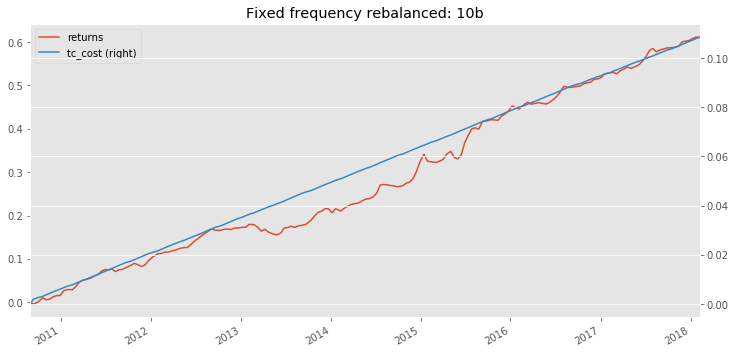

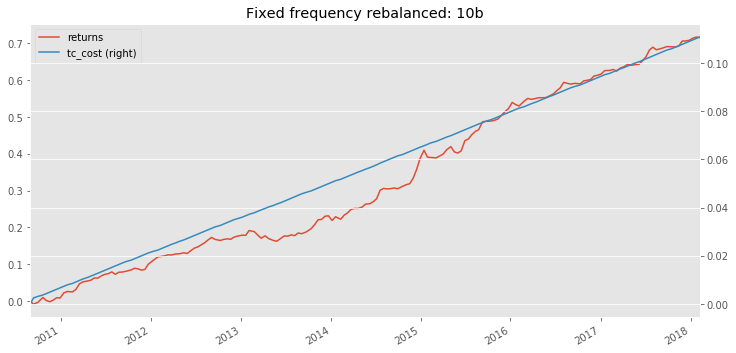

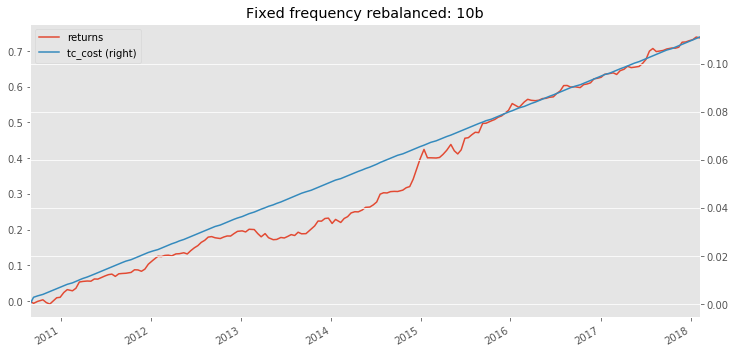

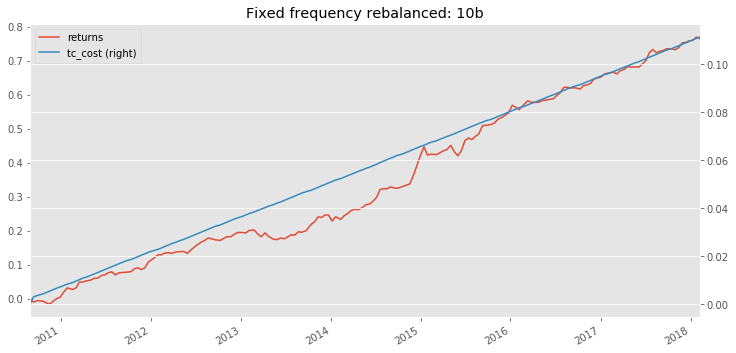

In [11]:
# Predicting and re-balance phase

weight_gaps = [0.005, 0.010, 0.015, 0.020]

model1_weight = 1.0
model2_weight = 0.5

factor_groups = const_model_factor_data.groupby('trade_date')
industry_group = industry_data.groupby('trade_date')
constraint_risk = ['SIZE', 'LEVERAGE'] + industries_list
turn_over_target_base = 0.30
size_risk_lower = 0
size_risk_upper = 0
benchmark_total_lower = 0.8
benchmark_total_upper = 1.
industry_lower = 1.
industry_upper = 1.

for s_i, weight_gap in enumerate(weight_gaps):
    print("start {0} weight gap simulation ...".format(weight_gap))

    rets = []
    turn_overs = []
    leverags = []
    previous_pos = pd.DataFrame()

    index_dates = []

    for i, value in enumerate(factor_groups):
        date = value[0]
        data = value[1]
        ref_date = date.strftime('%Y-%m-%d')

        total_data = data.fillna(data[const_model_features_keys].median())
        alpha_logger.info('{0}: {1}'.format(date, len(total_data)))
        risk_exp = total_data[neutralize_risk].values.astype(float)
        benchmark_w = total_data.weight.values
        
        this_industry_data = industry_group.get_group(date)
        
        total_data = pd.merge(total_data, this_industry_data, on=['trade_date', 'code'])
        constraint_exp = total_data[constraint_risk].values
        industry = total_data.industry_name.values
        risk_exp_expand = np.concatenate((constraint_exp, np.ones((len(risk_exp), 1))), axis=1).astype(float)

        risk_names = constraint_risk + ['total']
        risk_target = risk_exp_expand.T @ benchmark_w

        lbound = np.maximum(0., benchmark_w - weight_gap)  # np.zeros(len(total_data))
        ubound = weight_gap + benchmark_w

        is_in_benchmark = (benchmark_w > 0.).astype(float)

        risk_exp_expand = np.concatenate((risk_exp_expand, is_in_benchmark.reshape((-1, 1))), axis=1).astype(float)
        risk_names.append('benchmark_total')

        constraint = Constraints(risk_exp_expand, risk_names)

        for j, name in enumerate(risk_names):
            if name == 'total':
                constraint.set_constraints(name,
                                           lower_bound=risk_target[j],
                                           upper_bound=risk_target[j])
            elif name == 'SIZE':
                base_target = abs(risk_target[j])
                constraint.set_constraints(name,
                                           lower_bound=risk_target[j] + base_target * size_risk_lower,
                                           upper_bound=risk_target[j] + base_target * size_risk_upper)
            elif name == 'benchmark_total':
                base_target = benchmark_w.sum()
                constraint.set_constraints(name,
                                           lower_bound=benchmark_total_lower * base_target,
                                           upper_bound=benchmark_total_upper * base_target)
            else:
                constraint.set_constraints(name,
                                           lower_bound=risk_target[j] * industry_lower,
                                           upper_bound=risk_target[j] * industry_upper)
                
        values = total_data[const_model_features_keys].dropna()
        if values.empty:
            continue
        
        factor_values = factor_processing(total_data[const_model_features_keys].values,
                                          pre_process=[winsorize_normal, standardize],
                                          risk_factors=risk_exp,
                                          post_process=[winsorize_normal, standardize])

        # const linear model
        er1 = const_model.predict(factor_values)
        
        try:
            model = xgb_models_series.ix[date]
        except KeyError:
            alpha_logger.info("model is not available. Omit this date")
            continue
            
        index_dates.append(date)

        x = predict_x[date]
        this_predict_code = predict_code[date]
        er2 = model.predict(x)

        # combine model
        er1_table = pd.DataFrame({'er1': er1, 'code': total_data.code.values})
        er2_table = pd.DataFrame({'er2': er2, 'code': this_predict_code})
        er_table = pd.merge(er1_table, er2_table, on=['code'], how='left').fillna(0)

        er1 = er_table.er1.values
        er2 = er_table.er2.values
        
        if er2.std() > 0:
            print('using backbone model and alpha model')
            er = model1_weight * er1 / er1.std() +  model2_weight * er2 / er2.std()
        else:
            print('using only backbone modedl')
            er = model1_weight * er1
            
        codes = total_data['code'].values

        if previous_pos.empty:
            current_position = None
            turn_over_target = None
        else:
            previous_pos.set_index('code', inplace=True)
            remained_pos = previous_pos.loc[codes]

            remained_pos.fillna(0., inplace=True)
            turn_over_target = turn_over_target_base
            current_position = remained_pos.weight.values

        try:
            target_pos, _ = er_portfolio_analysis(er,
                                                  industry,
                                                  None,
                                                  constraint,
                                                  False,
                                                  benchmark_w,
                                                  method=method,
                                                  turn_over_target=turn_over_target,
                                                  current_position=current_position,
                                                  lbound=lbound,
                                                  ubound=ubound)
        except ValueError:
            alpha_logger.info('{0} full re-balance'.format(date))
            target_pos, _ = er_portfolio_analysis(er,
                                                  industry,
                                                  None,
                                                  constraint,
                                                  False,
                                                  benchmark_w,
                                                  method=method,
                                                  lbound=lbound,
                                                  ubound=ubound)

        target_pos['code'] = total_data['code'].values

        turn_over, executed_pos = executor.execute(target_pos=target_pos)

        executed_codes = executed_pos.code.tolist()
        dx_returns = engine.fetch_dx_return(date, executed_codes, horizon=horizon, offset=1)

        result = pd.merge(executed_pos, total_data[['code', 'weight']], on=['code'], how='inner')
        result = pd.merge(result, dx_returns, on=['code'])

        leverage = result.weight_x.abs().sum()

        ret = result.weight_x.values @ (np.exp(result.dx.values) - 1.)
        rets.append(np.log(1. + ret))
        executor.set_current(executed_pos)
        turn_overs.append(turn_over)
        leverags.append(leverage)

        previous_pos = executed_pos
        alpha_logger.info('{0} is finished'.format(date))

    ret_df = pd.DataFrame({'returns': rets, 'turn_over': turn_overs, 'leverage': leverags}, index=index_dates)

    # index return
    index_return = engine.fetch_dx_return_index_range(benchmark_code, dates=ref_dates, horizon=horizon,
                                                      offset=1).set_index('trade_date')
    ret_df['index'] = index_return['dx']

    ret_df.loc[advanceDateByCalendar('china.sse', ref_dates[-1], frequency)] = 0.
    ret_df = ret_df.shift(1)
    ret_df.iloc[0] = 0.
    ret_df['tc_cost'] = ret_df.turn_over * 0.002
    ret_df['returns'] = ret_df['leverage'] * (ret_df['returns'] - ret_df['index'])

    ret_df[['returns', 'tc_cost']].cumsum().plot(figsize=(12, 6),
                                                 title='Fixed frequency rebalanced: {0}'.format(frequency),
                                                 secondary_y='tc_cost')

    ret_df['ret_after_tc'] = ret_df['returns'] - ret_df['tc_cost']
    

    sharp_calc = MovingSharp(49)
    drawdown_calc = MovingMaxDrawdown(49)
    max_drawdown_calc = MovingMaxDrawdown(len(ret_df))

    res_df = pd.DataFrame(columns=['daily_return', 'cum_ret', 'sharp', 'drawdown', 'max_drawn', 'leverage'])

    total_returns = 0.

    for i, ret in enumerate(ret_df['ret_after_tc']):
        date = ret_df.index[i]
        total_returns += ret
        sharp_calc.push({'ret': ret, 'riskFree': 0.})
        drawdown_calc.push({'ret': ret})
        max_drawdown_calc.push({'ret': ret})

        res_df.loc[date, 'daily_return'] = ret
        res_df.loc[date, 'cum_ret'] = total_returns
        res_df.loc[date, 'drawdown'] = drawdown_calc.result()[0]
        res_df.loc[date, 'max_drawn'] = max_drawdown_calc.result()[0]
        res_df.loc[date, 'leverage'] = ret_df.loc[date, 'leverage']

        if i < 10:
            res_df.loc[date, 'sharp'] = 0.
        else:
            res_df.loc[date, 'sharp'] = sharp_calc.result() * np.sqrt(49)

    res_df.to_csv('hs300_rf2_{0}.csv'.format(int(s_i)))

## Lasso Regression
----------

In [14]:
"""
Training phase
"""

lasso_models_series = pd.Series()
previous_model = None

for ref_date in ref_dates:
    x = train_x[ref_date]
    y = train_y[ref_date]
    if len(x) > 5 * len(model_features_keys):
        model = LassoRegression(alpha=0.005, features=model_features_keys, fit_intercept=True) 
        model.fit(x, y)
        lasso_models_series.loc[ref_date] = model
        previous_model = copy.deepcopy(model)
    else:
        models_series.loc[ref_date] = previous_model
    
    alpha_logger.info('trade_date: {0} with {1} obs training finished'.format(ref_date, len(x)))

2018-02-05 14:12:28,211 - ALPHA_MIND - INFO - trade_date: 2010-08-30 00:00:00 with 12774 obs training finished
2018-02-05 14:12:28,219 - ALPHA_MIND - INFO - trade_date: 2010-09-13 00:00:00 with 12775 obs training finished
2018-02-05 14:12:28,226 - ALPHA_MIND - INFO - trade_date: 2010-09-30 00:00:00 with 12776 obs training finished
2018-02-05 14:12:28,233 - ALPHA_MIND - INFO - trade_date: 2010-10-21 00:00:00 with 12776 obs training finished
2018-02-05 14:12:28,238 - ALPHA_MIND - INFO - trade_date: 2010-11-04 00:00:00 with 12777 obs training finished
2018-02-05 14:12:28,245 - ALPHA_MIND - INFO - trade_date: 2010-11-18 00:00:00 with 12778 obs training finished
2018-02-05 14:12:28,251 - ALPHA_MIND - INFO - trade_date: 2010-12-02 00:00:00 with 12778 obs training finished
2018-02-05 14:12:28,256 - ALPHA_MIND - INFO - trade_date: 2010-12-16 00:00:00 with 12778 obs training finished
2018-02-05 14:12:28,262 - ALPHA_MIND - INFO - trade_date: 2010-12-30 00:00:00 with 12778 obs training finished
2

2018-02-05 14:12:28,693 - ALPHA_MIND - INFO - trade_date: 2013-09-05 00:00:00 with 12798 obs training finished
2018-02-05 14:12:28,700 - ALPHA_MIND - INFO - trade_date: 2013-09-23 00:00:00 with 12799 obs training finished
2018-02-05 14:12:28,707 - ALPHA_MIND - INFO - trade_date: 2013-10-14 00:00:00 with 12799 obs training finished
2018-02-05 14:12:28,714 - ALPHA_MIND - INFO - trade_date: 2013-10-28 00:00:00 with 12799 obs training finished
2018-02-05 14:12:28,722 - ALPHA_MIND - INFO - trade_date: 2013-11-11 00:00:00 with 12799 obs training finished
2018-02-05 14:12:28,729 - ALPHA_MIND - INFO - trade_date: 2013-11-25 00:00:00 with 12799 obs training finished
2018-02-05 14:12:28,735 - ALPHA_MIND - INFO - trade_date: 2013-12-09 00:00:00 with 12799 obs training finished
2018-02-05 14:12:28,741 - ALPHA_MIND - INFO - trade_date: 2013-12-23 00:00:00 with 12799 obs training finished
2018-02-05 14:12:28,747 - ALPHA_MIND - INFO - trade_date: 2014-01-07 00:00:00 with 12799 obs training finished
2

2018-02-05 14:12:29,188 - ALPHA_MIND - INFO - trade_date: 2016-09-19 00:00:00 with 12781 obs training finished
2018-02-05 14:12:29,195 - ALPHA_MIND - INFO - trade_date: 2016-10-10 00:00:00 with 12781 obs training finished
2018-02-05 14:12:29,202 - ALPHA_MIND - INFO - trade_date: 2016-10-24 00:00:00 with 12782 obs training finished
2018-02-05 14:12:29,208 - ALPHA_MIND - INFO - trade_date: 2016-11-07 00:00:00 with 12783 obs training finished
2018-02-05 14:12:29,215 - ALPHA_MIND - INFO - trade_date: 2016-11-21 00:00:00 with 12785 obs training finished
2018-02-05 14:12:29,222 - ALPHA_MIND - INFO - trade_date: 2016-12-05 00:00:00 with 12787 obs training finished
2018-02-05 14:12:29,229 - ALPHA_MIND - INFO - trade_date: 2016-12-19 00:00:00 with 12788 obs training finished
2018-02-05 14:12:29,235 - ALPHA_MIND - INFO - trade_date: 2017-01-03 00:00:00 with 12789 obs training finished
2018-02-05 14:12:29,243 - ALPHA_MIND - INFO - trade_date: 2017-01-17 00:00:00 with 12788 obs training finished
2

2018-02-05 14:12:30,629 - ALPHA_MIND - INFO - 2010-08-30 00:00:00: 799


start 0.005 weight gap simulation ...


D:\ProgramData\IntelPython3_2018\lib\site-packages\ipykernel_launcher.py:81: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
2018-02-05 14:12:30,881 - ALPHA_MIND - INFO - 2010-08-30 00:00:00 is finished


using backbone model and alpha model


2018-02-05 14:12:30,889 - ALPHA_MIND - INFO - 2010-09-13 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:12:31,173 - ALPHA_MIND - INFO - 2010-09-13 00:00:00 is finished
2018-02-05 14:12:31,179 - ALPHA_MIND - INFO - 2010-09-30 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:12:31,446 - ALPHA_MIND - INFO - 2010-09-30 00:00:00 is finished
2018-02-05 14:12:31,451 - ALPHA_MIND - INFO - 2010-10-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:12:31,738 - ALPHA_MIND - INFO - 2010-10-21 00:00:00 is finished
2018-02-05 14:12:31,745 - ALPHA_MIND - INFO - 2010-11-04 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:12:32,028 - ALPHA_MIND - INFO - 2010-11-04 00:00:00 is finished
2018-02-05 14:12:32,034 - ALPHA_MIND - INFO - 2010-11-18 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:12:32,328 - ALPHA_MIND - INFO - 2010-11-18 00:00:00 is finished
2018-02-05 14:12:32,333 - ALPHA_MIND - INFO - 2010-12-02 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:12:32,629 - ALPHA_MIND - INFO - 2010-12-02 00:00:00 is finished
2018-02-05 14:12:32,635 - ALPHA_MIND - INFO - 2010-12-16 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:12:32,904 - ALPHA_MIND - INFO - 2010-12-16 00:00:00 is finished
2018-02-05 14:12:32,909 - ALPHA_MIND - INFO - 2010-12-30 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:12:33,193 - ALPHA_MIND - INFO - 2010-12-30 00:00:00 is finished
2018-02-05 14:12:33,198 - ALPHA_MIND - INFO - 2011-01-14 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:12:33,487 - ALPHA_MIND - INFO - 2011-01-14 00:00:00 is finished
2018-02-05 14:12:33,494 - ALPHA_MIND - INFO - 2011-01-28 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:12:34,034 - ALPHA_MIND - INFO - 2011-01-28 00:00:00 is finished
2018-02-05 14:12:34,040 - ALPHA_MIND - INFO - 2011-02-18 00:00:00: 797


using backbone model and alpha model


2018-02-05 14:12:34,334 - ALPHA_MIND - INFO - 2011-02-18 00:00:00 is finished
2018-02-05 14:12:34,339 - ALPHA_MIND - INFO - 2011-03-04 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:12:34,602 - ALPHA_MIND - INFO - 2011-03-04 00:00:00 is finished
2018-02-05 14:12:34,607 - ALPHA_MIND - INFO - 2011-03-18 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:12:34,874 - ALPHA_MIND - INFO - 2011-03-18 00:00:00 is finished
2018-02-05 14:12:34,881 - ALPHA_MIND - INFO - 2011-04-01 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:12:35,164 - ALPHA_MIND - INFO - 2011-04-01 00:00:00 is finished
2018-02-05 14:12:35,170 - ALPHA_MIND - INFO - 2011-04-19 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:12:35,441 - ALPHA_MIND - INFO - 2011-04-19 00:00:00 is finished
2018-02-05 14:12:35,446 - ALPHA_MIND - INFO - 2011-05-04 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:12:35,730 - ALPHA_MIND - INFO - 2011-05-04 00:00:00 is finished
2018-02-05 14:12:35,736 - ALPHA_MIND - INFO - 2011-05-18 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:12:36,004 - ALPHA_MIND - INFO - 2011-05-18 00:00:00 is finished
2018-02-05 14:12:36,009 - ALPHA_MIND - INFO - 2011-06-01 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:12:36,298 - ALPHA_MIND - INFO - 2011-06-01 00:00:00 is finished
2018-02-05 14:12:36,305 - ALPHA_MIND - INFO - 2011-06-16 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:12:36,631 - ALPHA_MIND - INFO - 2011-06-16 00:00:00 is finished
2018-02-05 14:12:36,639 - ALPHA_MIND - INFO - 2011-06-30 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:12:36,935 - ALPHA_MIND - INFO - 2011-06-30 00:00:00 is finished
2018-02-05 14:12:36,940 - ALPHA_MIND - INFO - 2011-07-14 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:12:37,211 - ALPHA_MIND - INFO - 2011-07-14 00:00:00 is finished
2018-02-05 14:12:37,217 - ALPHA_MIND - INFO - 2011-07-28 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:12:37,502 - ALPHA_MIND - INFO - 2011-07-28 00:00:00 is finished
2018-02-05 14:12:37,510 - ALPHA_MIND - INFO - 2011-08-11 00:00:00: 797


using backbone model and alpha model


2018-02-05 14:12:37,799 - ALPHA_MIND - INFO - 2011-08-11 00:00:00 is finished
2018-02-05 14:12:37,804 - ALPHA_MIND - INFO - 2011-08-25 00:00:00: 796


using backbone model and alpha model


2018-02-05 14:12:38,082 - ALPHA_MIND - INFO - 2011-08-25 00:00:00 is finished
2018-02-05 14:12:38,088 - ALPHA_MIND - INFO - 2011-09-08 00:00:00: 797


using backbone model and alpha model


2018-02-05 14:12:38,438 - ALPHA_MIND - INFO - 2011-09-08 00:00:00 is finished
2018-02-05 14:12:38,443 - ALPHA_MIND - INFO - 2011-09-23 00:00:00: 797


using backbone model and alpha model


2018-02-05 14:12:38,713 - ALPHA_MIND - INFO - 2011-09-23 00:00:00 is finished
2018-02-05 14:12:38,719 - ALPHA_MIND - INFO - 2011-10-14 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:12:38,999 - ALPHA_MIND - INFO - 2011-10-14 00:00:00 is finished
2018-02-05 14:12:39,004 - ALPHA_MIND - INFO - 2011-10-28 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:12:39,271 - ALPHA_MIND - INFO - 2011-10-28 00:00:00 is finished
2018-02-05 14:12:39,276 - ALPHA_MIND - INFO - 2011-11-11 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:12:39,557 - ALPHA_MIND - INFO - 2011-11-11 00:00:00 is finished
2018-02-05 14:12:39,562 - ALPHA_MIND - INFO - 2011-11-25 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:12:39,837 - ALPHA_MIND - INFO - 2011-11-25 00:00:00 is finished
2018-02-05 14:12:39,843 - ALPHA_MIND - INFO - 2011-12-09 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:12:40,121 - ALPHA_MIND - INFO - 2011-12-09 00:00:00 is finished
2018-02-05 14:12:40,126 - ALPHA_MIND - INFO - 2011-12-23 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:12:40,404 - ALPHA_MIND - INFO - 2011-12-23 00:00:00 is finished
2018-02-05 14:12:40,409 - ALPHA_MIND - INFO - 2012-01-10 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:12:40,675 - ALPHA_MIND - INFO - 2012-01-10 00:00:00 is finished
2018-02-05 14:12:40,681 - ALPHA_MIND - INFO - 2012-01-31 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:12:40,954 - ALPHA_MIND - INFO - 2012-01-31 00:00:00 is finished
2018-02-05 14:12:40,959 - ALPHA_MIND - INFO - 2012-02-14 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:12:41,236 - ALPHA_MIND - INFO - 2012-02-14 00:00:00 is finished
2018-02-05 14:12:41,240 - ALPHA_MIND - INFO - 2012-02-28 00:00:00: 797


using backbone model and alpha model


2018-02-05 14:12:41,520 - ALPHA_MIND - INFO - 2012-02-28 00:00:00 is finished
2018-02-05 14:12:41,525 - ALPHA_MIND - INFO - 2012-03-13 00:00:00: 797


using backbone model and alpha model


2018-02-05 14:12:41,813 - ALPHA_MIND - INFO - 2012-03-13 00:00:00 is finished
2018-02-05 14:12:41,819 - ALPHA_MIND - INFO - 2012-03-27 00:00:00: 796


using backbone model and alpha model


2018-02-05 14:12:42,091 - ALPHA_MIND - INFO - 2012-03-27 00:00:00 is finished
2018-02-05 14:12:42,096 - ALPHA_MIND - INFO - 2012-04-13 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:12:42,360 - ALPHA_MIND - INFO - 2012-04-13 00:00:00 is finished
2018-02-05 14:12:42,365 - ALPHA_MIND - INFO - 2012-04-27 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:12:42,635 - ALPHA_MIND - INFO - 2012-04-27 00:00:00 is finished
2018-02-05 14:12:42,640 - ALPHA_MIND - INFO - 2012-05-15 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:12:43,000 - ALPHA_MIND - INFO - 2012-05-15 00:00:00 is finished
2018-02-05 14:12:43,005 - ALPHA_MIND - INFO - 2012-05-29 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:12:43,276 - ALPHA_MIND - INFO - 2012-05-29 00:00:00 is finished
2018-02-05 14:12:43,281 - ALPHA_MIND - INFO - 2012-06-12 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:12:43,609 - ALPHA_MIND - INFO - 2012-06-12 00:00:00 is finished
2018-02-05 14:12:43,615 - ALPHA_MIND - INFO - 2012-06-27 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:12:43,906 - ALPHA_MIND - INFO - 2012-06-27 00:00:00 is finished
2018-02-05 14:12:43,911 - ALPHA_MIND - INFO - 2012-07-11 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:12:44,199 - ALPHA_MIND - INFO - 2012-07-11 00:00:00 is finished
2018-02-05 14:12:44,205 - ALPHA_MIND - INFO - 2012-07-25 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:12:44,486 - ALPHA_MIND - INFO - 2012-07-25 00:00:00 is finished
2018-02-05 14:12:44,491 - ALPHA_MIND - INFO - 2012-08-08 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:12:44,757 - ALPHA_MIND - INFO - 2012-08-08 00:00:00 is finished
2018-02-05 14:12:44,763 - ALPHA_MIND - INFO - 2012-08-22 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:12:45,025 - ALPHA_MIND - INFO - 2012-08-22 00:00:00 is finished
2018-02-05 14:12:45,030 - ALPHA_MIND - INFO - 2012-09-05 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:12:45,305 - ALPHA_MIND - INFO - 2012-09-05 00:00:00 is finished
2018-02-05 14:12:45,311 - ALPHA_MIND - INFO - 2012-09-19 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:12:45,596 - ALPHA_MIND - INFO - 2012-09-19 00:00:00 is finished
2018-02-05 14:12:45,601 - ALPHA_MIND - INFO - 2012-10-10 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:12:45,863 - ALPHA_MIND - INFO - 2012-10-10 00:00:00 is finished
2018-02-05 14:12:45,868 - ALPHA_MIND - INFO - 2012-10-24 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:12:46,129 - ALPHA_MIND - INFO - 2012-10-24 00:00:00 is finished
2018-02-05 14:12:46,133 - ALPHA_MIND - INFO - 2012-11-07 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:12:46,398 - ALPHA_MIND - INFO - 2012-11-07 00:00:00 is finished
2018-02-05 14:12:46,403 - ALPHA_MIND - INFO - 2012-11-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:12:46,667 - ALPHA_MIND - INFO - 2012-11-21 00:00:00 is finished
2018-02-05 14:12:46,673 - ALPHA_MIND - INFO - 2012-12-05 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:12:46,930 - ALPHA_MIND - INFO - 2012-12-05 00:00:00 is finished
2018-02-05 14:12:46,935 - ALPHA_MIND - INFO - 2012-12-19 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:12:47,207 - ALPHA_MIND - INFO - 2012-12-19 00:00:00 is finished
2018-02-05 14:12:47,212 - ALPHA_MIND - INFO - 2013-01-07 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:12:47,593 - ALPHA_MIND - INFO - 2013-01-07 00:00:00 is finished
2018-02-05 14:12:47,597 - ALPHA_MIND - INFO - 2013-01-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:12:47,873 - ALPHA_MIND - INFO - 2013-01-21 00:00:00 is finished
2018-02-05 14:12:47,877 - ALPHA_MIND - INFO - 2013-02-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:48,154 - ALPHA_MIND - INFO - 2013-02-04 00:00:00 is finished
2018-02-05 14:12:48,158 - ALPHA_MIND - INFO - 2013-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:48,448 - ALPHA_MIND - INFO - 2013-02-25 00:00:00 is finished
2018-02-05 14:12:48,453 - ALPHA_MIND - INFO - 2013-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:48,735 - ALPHA_MIND - INFO - 2013-03-11 00:00:00 is finished
2018-02-05 14:12:48,740 - ALPHA_MIND - INFO - 2013-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:49,012 - ALPHA_MIND - INFO - 2013-03-25 00:00:00 is finished
2018-02-05 14:12:49,017 - ALPHA_MIND - INFO - 2013-04-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:49,301 - ALPHA_MIND - INFO - 2013-04-10 00:00:00 is finished
2018-02-05 14:12:49,307 - ALPHA_MIND - INFO - 2013-04-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:49,587 - ALPHA_MIND - INFO - 2013-04-24 00:00:00 is finished
2018-02-05 14:12:49,592 - ALPHA_MIND - INFO - 2013-05-13 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:49,860 - ALPHA_MIND - INFO - 2013-05-13 00:00:00 is finished
2018-02-05 14:12:49,864 - ALPHA_MIND - INFO - 2013-05-27 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:50,128 - ALPHA_MIND - INFO - 2013-05-27 00:00:00 is finished
2018-02-05 14:12:50,133 - ALPHA_MIND - INFO - 2013-06-13 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:50,414 - ALPHA_MIND - INFO - 2013-06-13 00:00:00 is finished
2018-02-05 14:12:50,421 - ALPHA_MIND - INFO - 2013-06-27 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:50,698 - ALPHA_MIND - INFO - 2013-06-27 00:00:00 is finished
2018-02-05 14:12:50,703 - ALPHA_MIND - INFO - 2013-07-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:50,966 - ALPHA_MIND - INFO - 2013-07-11 00:00:00 is finished
2018-02-05 14:12:50,972 - ALPHA_MIND - INFO - 2013-07-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:51,243 - ALPHA_MIND - INFO - 2013-07-25 00:00:00 is finished
2018-02-05 14:12:51,248 - ALPHA_MIND - INFO - 2013-08-08 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:51,527 - ALPHA_MIND - INFO - 2013-08-08 00:00:00 is finished
2018-02-05 14:12:51,532 - ALPHA_MIND - INFO - 2013-08-22 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:51,806 - ALPHA_MIND - INFO - 2013-08-22 00:00:00 is finished
2018-02-05 14:12:51,811 - ALPHA_MIND - INFO - 2013-09-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:52,167 - ALPHA_MIND - INFO - 2013-09-05 00:00:00 is finished
2018-02-05 14:12:52,172 - ALPHA_MIND - INFO - 2013-09-23 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:12:52,446 - ALPHA_MIND - INFO - 2013-09-23 00:00:00 is finished
2018-02-05 14:12:52,451 - ALPHA_MIND - INFO - 2013-10-14 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:52,721 - ALPHA_MIND - INFO - 2013-10-14 00:00:00 is finished
2018-02-05 14:12:52,726 - ALPHA_MIND - INFO - 2013-10-28 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:53,000 - ALPHA_MIND - INFO - 2013-10-28 00:00:00 is finished
2018-02-05 14:12:53,005 - ALPHA_MIND - INFO - 2013-11-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:53,287 - ALPHA_MIND - INFO - 2013-11-11 00:00:00 is finished
2018-02-05 14:12:53,292 - ALPHA_MIND - INFO - 2013-11-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:53,572 - ALPHA_MIND - INFO - 2013-11-25 00:00:00 is finished
2018-02-05 14:12:53,576 - ALPHA_MIND - INFO - 2013-12-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:53,851 - ALPHA_MIND - INFO - 2013-12-09 00:00:00 is finished
2018-02-05 14:12:53,856 - ALPHA_MIND - INFO - 2013-12-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:54,134 - ALPHA_MIND - INFO - 2013-12-23 00:00:00 is finished
2018-02-05 14:12:54,139 - ALPHA_MIND - INFO - 2014-01-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:54,409 - ALPHA_MIND - INFO - 2014-01-07 00:00:00 is finished
2018-02-05 14:12:54,416 - ALPHA_MIND - INFO - 2014-01-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:54,702 - ALPHA_MIND - INFO - 2014-01-21 00:00:00 is finished
2018-02-05 14:12:54,706 - ALPHA_MIND - INFO - 2014-02-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:54,976 - ALPHA_MIND - INFO - 2014-02-11 00:00:00 is finished
2018-02-05 14:12:54,981 - ALPHA_MIND - INFO - 2014-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:55,248 - ALPHA_MIND - INFO - 2014-02-25 00:00:00 is finished
2018-02-05 14:12:55,253 - ALPHA_MIND - INFO - 2014-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:55,524 - ALPHA_MIND - INFO - 2014-03-11 00:00:00 is finished
2018-02-05 14:12:55,529 - ALPHA_MIND - INFO - 2014-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:55,796 - ALPHA_MIND - INFO - 2014-03-25 00:00:00 is finished
2018-02-05 14:12:55,801 - ALPHA_MIND - INFO - 2014-04-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:56,068 - ALPHA_MIND - INFO - 2014-04-09 00:00:00 is finished
2018-02-05 14:12:56,074 - ALPHA_MIND - INFO - 2014-04-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:56,344 - ALPHA_MIND - INFO - 2014-04-23 00:00:00 is finished
2018-02-05 14:12:56,349 - ALPHA_MIND - INFO - 2014-05-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:56,709 - ALPHA_MIND - INFO - 2014-05-09 00:00:00 is finished
2018-02-05 14:12:56,714 - ALPHA_MIND - INFO - 2014-05-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:56,979 - ALPHA_MIND - INFO - 2014-05-23 00:00:00 is finished
2018-02-05 14:12:56,984 - ALPHA_MIND - INFO - 2014-06-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:57,254 - ALPHA_MIND - INFO - 2014-06-09 00:00:00 is finished
2018-02-05 14:12:57,259 - ALPHA_MIND - INFO - 2014-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:57,538 - ALPHA_MIND - INFO - 2014-06-23 00:00:00 is finished
2018-02-05 14:12:57,543 - ALPHA_MIND - INFO - 2014-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:57,812 - ALPHA_MIND - INFO - 2014-07-07 00:00:00 is finished
2018-02-05 14:12:57,818 - ALPHA_MIND - INFO - 2014-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:58,090 - ALPHA_MIND - INFO - 2014-07-21 00:00:00 is finished
2018-02-05 14:12:58,095 - ALPHA_MIND - INFO - 2014-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:58,365 - ALPHA_MIND - INFO - 2014-08-04 00:00:00 is finished
2018-02-05 14:12:58,370 - ALPHA_MIND - INFO - 2014-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:58,646 - ALPHA_MIND - INFO - 2014-08-18 00:00:00 is finished
2018-02-05 14:12:58,652 - ALPHA_MIND - INFO - 2014-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:58,927 - ALPHA_MIND - INFO - 2014-09-01 00:00:00 is finished
2018-02-05 14:12:58,932 - ALPHA_MIND - INFO - 2014-09-16 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:59,213 - ALPHA_MIND - INFO - 2014-09-16 00:00:00 is finished
2018-02-05 14:12:59,218 - ALPHA_MIND - INFO - 2014-09-30 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:59,492 - ALPHA_MIND - INFO - 2014-09-30 00:00:00 is finished
2018-02-05 14:12:59,497 - ALPHA_MIND - INFO - 2014-10-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:12:59,773 - ALPHA_MIND - INFO - 2014-10-21 00:00:00 is finished
2018-02-05 14:12:59,777 - ALPHA_MIND - INFO - 2014-11-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:00,048 - ALPHA_MIND - INFO - 2014-11-04 00:00:00 is finished
2018-02-05 14:13:00,053 - ALPHA_MIND - INFO - 2014-11-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:00,323 - ALPHA_MIND - INFO - 2014-11-18 00:00:00 is finished
2018-02-05 14:13:00,327 - ALPHA_MIND - INFO - 2014-12-02 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:00,598 - ALPHA_MIND - INFO - 2014-12-02 00:00:00 is finished
2018-02-05 14:13:00,603 - ALPHA_MIND - INFO - 2014-12-16 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:00,873 - ALPHA_MIND - INFO - 2014-12-16 00:00:00 is finished
2018-02-05 14:13:00,878 - ALPHA_MIND - INFO - 2014-12-30 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:01,228 - ALPHA_MIND - INFO - 2014-12-30 00:00:00 is finished
2018-02-05 14:13:01,233 - ALPHA_MIND - INFO - 2015-01-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:01,520 - ALPHA_MIND - INFO - 2015-01-15 00:00:00 is finished
2018-02-05 14:13:01,525 - ALPHA_MIND - INFO - 2015-01-29 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:13:01,788 - ALPHA_MIND - INFO - 2015-01-29 00:00:00 is finished
2018-02-05 14:13:01,794 - ALPHA_MIND - INFO - 2015-02-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:02,072 - ALPHA_MIND - INFO - 2015-02-12 00:00:00 is finished
2018-02-05 14:13:02,077 - ALPHA_MIND - INFO - 2015-03-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:02,347 - ALPHA_MIND - INFO - 2015-03-05 00:00:00 is finished
2018-02-05 14:13:02,352 - ALPHA_MIND - INFO - 2015-03-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:02,628 - ALPHA_MIND - INFO - 2015-03-19 00:00:00 is finished
2018-02-05 14:13:02,632 - ALPHA_MIND - INFO - 2015-04-02 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:02,913 - ALPHA_MIND - INFO - 2015-04-02 00:00:00 is finished
2018-02-05 14:13:02,919 - ALPHA_MIND - INFO - 2015-04-17 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:03,193 - ALPHA_MIND - INFO - 2015-04-17 00:00:00 is finished
2018-02-05 14:13:03,199 - ALPHA_MIND - INFO - 2015-05-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:03,476 - ALPHA_MIND - INFO - 2015-05-04 00:00:00 is finished
2018-02-05 14:13:03,481 - ALPHA_MIND - INFO - 2015-05-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:03,761 - ALPHA_MIND - INFO - 2015-05-18 00:00:00 is finished
2018-02-05 14:13:03,766 - ALPHA_MIND - INFO - 2015-06-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:04,038 - ALPHA_MIND - INFO - 2015-06-01 00:00:00 is finished
2018-02-05 14:13:04,044 - ALPHA_MIND - INFO - 2015-06-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:04,322 - ALPHA_MIND - INFO - 2015-06-15 00:00:00 is finished
2018-02-05 14:13:04,327 - ALPHA_MIND - INFO - 2015-06-30 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:04,607 - ALPHA_MIND - INFO - 2015-06-30 00:00:00 is finished
2018-02-05 14:13:04,612 - ALPHA_MIND - INFO - 2015-07-14 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:04,878 - ALPHA_MIND - INFO - 2015-07-14 00:00:00 is finished
2018-02-05 14:13:04,882 - ALPHA_MIND - INFO - 2015-07-28 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:05,153 - ALPHA_MIND - INFO - 2015-07-28 00:00:00 is finished
2018-02-05 14:13:05,157 - ALPHA_MIND - INFO - 2015-08-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:05,430 - ALPHA_MIND - INFO - 2015-08-11 00:00:00 is finished
2018-02-05 14:13:05,436 - ALPHA_MIND - INFO - 2015-08-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:05,804 - ALPHA_MIND - INFO - 2015-08-25 00:00:00 is finished
2018-02-05 14:13:05,809 - ALPHA_MIND - INFO - 2015-09-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:06,086 - ALPHA_MIND - INFO - 2015-09-10 00:00:00 is finished
2018-02-05 14:13:06,090 - ALPHA_MIND - INFO - 2015-09-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:06,366 - ALPHA_MIND - INFO - 2015-09-24 00:00:00 is finished
2018-02-05 14:13:06,370 - ALPHA_MIND - INFO - 2015-10-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:06,649 - ALPHA_MIND - INFO - 2015-10-15 00:00:00 is finished
2018-02-05 14:13:06,654 - ALPHA_MIND - INFO - 2015-10-29 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:06,927 - ALPHA_MIND - INFO - 2015-10-29 00:00:00 is finished
2018-02-05 14:13:06,932 - ALPHA_MIND - INFO - 2015-11-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:07,217 - ALPHA_MIND - INFO - 2015-11-12 00:00:00 is finished
2018-02-05 14:13:07,221 - ALPHA_MIND - INFO - 2015-11-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:07,507 - ALPHA_MIND - INFO - 2015-11-26 00:00:00 is finished
2018-02-05 14:13:07,513 - ALPHA_MIND - INFO - 2015-12-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:07,788 - ALPHA_MIND - INFO - 2015-12-10 00:00:00 is finished
2018-02-05 14:13:07,793 - ALPHA_MIND - INFO - 2015-12-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:08,067 - ALPHA_MIND - INFO - 2015-12-24 00:00:00 is finished
2018-02-05 14:13:08,072 - ALPHA_MIND - INFO - 2016-01-08 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:08,356 - ALPHA_MIND - INFO - 2016-01-08 00:00:00 is finished
2018-02-05 14:13:08,361 - ALPHA_MIND - INFO - 2016-01-22 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:08,626 - ALPHA_MIND - INFO - 2016-01-22 00:00:00 is finished
2018-02-05 14:13:08,631 - ALPHA_MIND - INFO - 2016-02-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:08,906 - ALPHA_MIND - INFO - 2016-02-05 00:00:00 is finished
2018-02-05 14:13:08,911 - ALPHA_MIND - INFO - 2016-02-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:09,189 - ALPHA_MIND - INFO - 2016-02-26 00:00:00 is finished
2018-02-05 14:13:09,194 - ALPHA_MIND - INFO - 2016-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:09,489 - ALPHA_MIND - INFO - 2016-03-11 00:00:00 is finished
2018-02-05 14:13:09,494 - ALPHA_MIND - INFO - 2016-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:09,783 - ALPHA_MIND - INFO - 2016-03-25 00:00:00 is finished
2018-02-05 14:13:09,788 - ALPHA_MIND - INFO - 2016-04-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:10,072 - ALPHA_MIND - INFO - 2016-04-11 00:00:00 is finished
2018-02-05 14:13:10,077 - ALPHA_MIND - INFO - 2016-04-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:10,441 - ALPHA_MIND - INFO - 2016-04-25 00:00:00 is finished
2018-02-05 14:13:10,446 - ALPHA_MIND - INFO - 2016-05-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:10,720 - ALPHA_MIND - INFO - 2016-05-10 00:00:00 is finished
2018-02-05 14:13:10,725 - ALPHA_MIND - INFO - 2016-05-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:10,993 - ALPHA_MIND - INFO - 2016-05-24 00:00:00 is finished
2018-02-05 14:13:10,998 - ALPHA_MIND - INFO - 2016-06-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:11,264 - ALPHA_MIND - INFO - 2016-06-07 00:00:00 is finished
2018-02-05 14:13:11,268 - ALPHA_MIND - INFO - 2016-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:11,562 - ALPHA_MIND - INFO - 2016-06-23 00:00:00 is finished
2018-02-05 14:13:11,567 - ALPHA_MIND - INFO - 2016-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:11,884 - ALPHA_MIND - INFO - 2016-07-07 00:00:00 is finished
2018-02-05 14:13:11,889 - ALPHA_MIND - INFO - 2016-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:12,168 - ALPHA_MIND - INFO - 2016-07-21 00:00:00 is finished
2018-02-05 14:13:12,173 - ALPHA_MIND - INFO - 2016-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:12,457 - ALPHA_MIND - INFO - 2016-08-04 00:00:00 is finished
2018-02-05 14:13:12,461 - ALPHA_MIND - INFO - 2016-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:12,740 - ALPHA_MIND - INFO - 2016-08-18 00:00:00 is finished
2018-02-05 14:13:12,746 - ALPHA_MIND - INFO - 2016-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:13,067 - ALPHA_MIND - INFO - 2016-09-01 00:00:00 is finished
2018-02-05 14:13:13,073 - ALPHA_MIND - INFO - 2016-09-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:13,349 - ALPHA_MIND - INFO - 2016-09-19 00:00:00 is finished
2018-02-05 14:13:13,354 - ALPHA_MIND - INFO - 2016-10-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:13,653 - ALPHA_MIND - INFO - 2016-10-10 00:00:00 is finished
2018-02-05 14:13:13,658 - ALPHA_MIND - INFO - 2016-10-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:13,944 - ALPHA_MIND - INFO - 2016-10-24 00:00:00 is finished
2018-02-05 14:13:13,952 - ALPHA_MIND - INFO - 2016-11-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:14,273 - ALPHA_MIND - INFO - 2016-11-07 00:00:00 is finished
2018-02-05 14:13:14,279 - ALPHA_MIND - INFO - 2016-11-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:14,562 - ALPHA_MIND - INFO - 2016-11-21 00:00:00 is finished
2018-02-05 14:13:14,566 - ALPHA_MIND - INFO - 2016-12-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:14,851 - ALPHA_MIND - INFO - 2016-12-05 00:00:00 is finished
2018-02-05 14:13:14,856 - ALPHA_MIND - INFO - 2016-12-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:15,246 - ALPHA_MIND - INFO - 2016-12-19 00:00:00 is finished
2018-02-05 14:13:15,253 - ALPHA_MIND - INFO - 2017-01-03 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:15,554 - ALPHA_MIND - INFO - 2017-01-03 00:00:00 is finished
2018-02-05 14:13:15,559 - ALPHA_MIND - INFO - 2017-01-17 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:15,838 - ALPHA_MIND - INFO - 2017-01-17 00:00:00 is finished
2018-02-05 14:13:15,843 - ALPHA_MIND - INFO - 2017-02-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:16,127 - ALPHA_MIND - INFO - 2017-02-07 00:00:00 is finished
2018-02-05 14:13:16,132 - ALPHA_MIND - INFO - 2017-02-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:13:16,426 - ALPHA_MIND - INFO - 2017-02-21 00:00:00 is finished
2018-02-05 14:13:16,433 - ALPHA_MIND - INFO - 2017-03-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:16,724 - ALPHA_MIND - INFO - 2017-03-07 00:00:00 is finished
2018-02-05 14:13:16,729 - ALPHA_MIND - INFO - 2017-03-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:17,009 - ALPHA_MIND - INFO - 2017-03-21 00:00:00 is finished
2018-02-05 14:13:17,016 - ALPHA_MIND - INFO - 2017-04-06 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:17,312 - ALPHA_MIND - INFO - 2017-04-06 00:00:00 is finished
2018-02-05 14:13:17,318 - ALPHA_MIND - INFO - 2017-04-20 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:17,622 - ALPHA_MIND - INFO - 2017-04-20 00:00:00 is finished
2018-02-05 14:13:17,627 - ALPHA_MIND - INFO - 2017-05-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:17,912 - ALPHA_MIND - INFO - 2017-05-05 00:00:00 is finished
2018-02-05 14:13:17,916 - ALPHA_MIND - INFO - 2017-05-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:18,203 - ALPHA_MIND - INFO - 2017-05-19 00:00:00 is finished
2018-02-05 14:13:18,208 - ALPHA_MIND - INFO - 2017-06-06 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:18,496 - ALPHA_MIND - INFO - 2017-06-06 00:00:00 is finished
2018-02-05 14:13:18,502 - ALPHA_MIND - INFO - 2017-06-20 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:18,792 - ALPHA_MIND - INFO - 2017-06-20 00:00:00 is finished
2018-02-05 14:13:18,798 - ALPHA_MIND - INFO - 2017-07-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:19,090 - ALPHA_MIND - INFO - 2017-07-04 00:00:00 is finished
2018-02-05 14:13:19,095 - ALPHA_MIND - INFO - 2017-07-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:19,382 - ALPHA_MIND - INFO - 2017-07-18 00:00:00 is finished
2018-02-05 14:13:19,387 - ALPHA_MIND - INFO - 2017-08-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:19,678 - ALPHA_MIND - INFO - 2017-08-01 00:00:00 is finished
2018-02-05 14:13:19,684 - ALPHA_MIND - INFO - 2017-08-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:20,042 - ALPHA_MIND - INFO - 2017-08-15 00:00:00 is finished
2018-02-05 14:13:20,047 - ALPHA_MIND - INFO - 2017-08-29 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:20,337 - ALPHA_MIND - INFO - 2017-08-29 00:00:00 is finished
2018-02-05 14:13:20,342 - ALPHA_MIND - INFO - 2017-09-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:20,633 - ALPHA_MIND - INFO - 2017-09-12 00:00:00 is finished
2018-02-05 14:13:20,638 - ALPHA_MIND - INFO - 2017-09-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:20,924 - ALPHA_MIND - INFO - 2017-09-26 00:00:00 is finished
2018-02-05 14:13:20,929 - ALPHA_MIND - INFO - 2017-10-17 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:21,218 - ALPHA_MIND - INFO - 2017-10-17 00:00:00 is finished
2018-02-05 14:13:21,223 - ALPHA_MIND - INFO - 2017-10-31 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:21,499 - ALPHA_MIND - INFO - 2017-10-31 00:00:00 is finished
2018-02-05 14:13:21,504 - ALPHA_MIND - INFO - 2017-11-14 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:21,785 - ALPHA_MIND - INFO - 2017-11-14 00:00:00 is finished
2018-02-05 14:13:21,790 - ALPHA_MIND - INFO - 2017-11-28 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:22,084 - ALPHA_MIND - INFO - 2017-11-28 00:00:00 is finished
2018-02-05 14:13:22,089 - ALPHA_MIND - INFO - 2017-12-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:22,378 - ALPHA_MIND - INFO - 2017-12-12 00:00:00 is finished
2018-02-05 14:13:22,384 - ALPHA_MIND - INFO - 2017-12-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:22,691 - ALPHA_MIND - INFO - 2017-12-26 00:00:00 is finished
2018-02-05 14:13:22,696 - ALPHA_MIND - INFO - 2018-01-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:22,985 - ALPHA_MIND - INFO - 2018-01-10 00:00:00 is finished
2018-02-05 14:13:22,990 - ALPHA_MIND - INFO - 2018-01-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:23,250 - ALPHA_MIND - INFO - 2018-01-24 00:00:00 is finished
2018-02-05 14:13:23,825 - ALPHA_MIND - INFO - 2010-08-30 00:00:00: 799


start 0.01 weight gap simulation ...
using backbone model and alpha model


2018-02-05 14:13:24,017 - ALPHA_MIND - INFO - 2010-08-30 00:00:00 is finished
2018-02-05 14:13:24,023 - ALPHA_MIND - INFO - 2010-09-13 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:13:24,380 - ALPHA_MIND - INFO - 2010-09-13 00:00:00 is finished
2018-02-05 14:13:24,386 - ALPHA_MIND - INFO - 2010-09-30 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:13:24,646 - ALPHA_MIND - INFO - 2010-09-30 00:00:00 is finished
2018-02-05 14:13:24,651 - ALPHA_MIND - INFO - 2010-10-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:13:24,910 - ALPHA_MIND - INFO - 2010-10-21 00:00:00 is finished
2018-02-05 14:13:24,914 - ALPHA_MIND - INFO - 2010-11-04 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:13:25,170 - ALPHA_MIND - INFO - 2010-11-04 00:00:00 is finished
2018-02-05 14:13:25,175 - ALPHA_MIND - INFO - 2010-11-18 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:13:25,434 - ALPHA_MIND - INFO - 2010-11-18 00:00:00 is finished
2018-02-05 14:13:25,440 - ALPHA_MIND - INFO - 2010-12-02 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:13:25,696 - ALPHA_MIND - INFO - 2010-12-02 00:00:00 is finished
2018-02-05 14:13:25,701 - ALPHA_MIND - INFO - 2010-12-16 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:13:25,954 - ALPHA_MIND - INFO - 2010-12-16 00:00:00 is finished
2018-02-05 14:13:25,960 - ALPHA_MIND - INFO - 2010-12-30 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:13:26,210 - ALPHA_MIND - INFO - 2010-12-30 00:00:00 is finished
2018-02-05 14:13:26,216 - ALPHA_MIND - INFO - 2011-01-14 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:13:26,470 - ALPHA_MIND - INFO - 2011-01-14 00:00:00 is finished
2018-02-05 14:13:26,475 - ALPHA_MIND - INFO - 2011-01-28 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:13:26,724 - ALPHA_MIND - INFO - 2011-01-28 00:00:00 is finished
2018-02-05 14:13:26,730 - ALPHA_MIND - INFO - 2011-02-18 00:00:00: 797


using backbone model and alpha model


2018-02-05 14:13:26,985 - ALPHA_MIND - INFO - 2011-02-18 00:00:00 is finished
2018-02-05 14:13:26,991 - ALPHA_MIND - INFO - 2011-03-04 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:13:27,248 - ALPHA_MIND - INFO - 2011-03-04 00:00:00 is finished
2018-02-05 14:13:27,253 - ALPHA_MIND - INFO - 2011-03-18 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:13:27,527 - ALPHA_MIND - INFO - 2011-03-18 00:00:00 is finished
2018-02-05 14:13:27,533 - ALPHA_MIND - INFO - 2011-04-01 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:13:27,802 - ALPHA_MIND - INFO - 2011-04-01 00:00:00 is finished
2018-02-05 14:13:27,806 - ALPHA_MIND - INFO - 2011-04-19 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:13:28,068 - ALPHA_MIND - INFO - 2011-04-19 00:00:00 is finished
2018-02-05 14:13:28,073 - ALPHA_MIND - INFO - 2011-05-04 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:13:28,346 - ALPHA_MIND - INFO - 2011-05-04 00:00:00 is finished
2018-02-05 14:13:28,351 - ALPHA_MIND - INFO - 2011-05-18 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:13:28,697 - ALPHA_MIND - INFO - 2011-05-18 00:00:00 is finished
2018-02-05 14:13:28,703 - ALPHA_MIND - INFO - 2011-06-01 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:13:28,976 - ALPHA_MIND - INFO - 2011-06-01 00:00:00 is finished
2018-02-05 14:13:28,981 - ALPHA_MIND - INFO - 2011-06-16 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:13:29,244 - ALPHA_MIND - INFO - 2011-06-16 00:00:00 is finished
2018-02-05 14:13:29,248 - ALPHA_MIND - INFO - 2011-06-30 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:13:29,516 - ALPHA_MIND - INFO - 2011-06-30 00:00:00 is finished
2018-02-05 14:13:29,520 - ALPHA_MIND - INFO - 2011-07-14 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:13:29,786 - ALPHA_MIND - INFO - 2011-07-14 00:00:00 is finished
2018-02-05 14:13:29,791 - ALPHA_MIND - INFO - 2011-07-28 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:13:30,053 - ALPHA_MIND - INFO - 2011-07-28 00:00:00 is finished
2018-02-05 14:13:30,058 - ALPHA_MIND - INFO - 2011-08-11 00:00:00: 797


using backbone model and alpha model


2018-02-05 14:13:30,320 - ALPHA_MIND - INFO - 2011-08-11 00:00:00 is finished
2018-02-05 14:13:30,325 - ALPHA_MIND - INFO - 2011-08-25 00:00:00: 796


using backbone model and alpha model


2018-02-05 14:13:30,595 - ALPHA_MIND - INFO - 2011-08-25 00:00:00 is finished
2018-02-05 14:13:30,600 - ALPHA_MIND - INFO - 2011-09-08 00:00:00: 797


using backbone model and alpha model


2018-02-05 14:13:30,865 - ALPHA_MIND - INFO - 2011-09-08 00:00:00 is finished
2018-02-05 14:13:30,871 - ALPHA_MIND - INFO - 2011-09-23 00:00:00: 797


using backbone model and alpha model


2018-02-05 14:13:31,129 - ALPHA_MIND - INFO - 2011-09-23 00:00:00 is finished
2018-02-05 14:13:31,134 - ALPHA_MIND - INFO - 2011-10-14 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:13:31,396 - ALPHA_MIND - INFO - 2011-10-14 00:00:00 is finished
2018-02-05 14:13:31,401 - ALPHA_MIND - INFO - 2011-10-28 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:13:31,668 - ALPHA_MIND - INFO - 2011-10-28 00:00:00 is finished
2018-02-05 14:13:31,673 - ALPHA_MIND - INFO - 2011-11-11 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:13:31,940 - ALPHA_MIND - INFO - 2011-11-11 00:00:00 is finished
2018-02-05 14:13:31,945 - ALPHA_MIND - INFO - 2011-11-25 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:13:32,208 - ALPHA_MIND - INFO - 2011-11-25 00:00:00 is finished
2018-02-05 14:13:32,213 - ALPHA_MIND - INFO - 2011-12-09 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:13:32,474 - ALPHA_MIND - INFO - 2011-12-09 00:00:00 is finished
2018-02-05 14:13:32,479 - ALPHA_MIND - INFO - 2011-12-23 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:13:32,741 - ALPHA_MIND - INFO - 2011-12-23 00:00:00 is finished
2018-02-05 14:13:32,746 - ALPHA_MIND - INFO - 2012-01-10 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:13:33,098 - ALPHA_MIND - INFO - 2012-01-10 00:00:00 is finished
2018-02-05 14:13:33,103 - ALPHA_MIND - INFO - 2012-01-31 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:13:33,370 - ALPHA_MIND - INFO - 2012-01-31 00:00:00 is finished
2018-02-05 14:13:33,375 - ALPHA_MIND - INFO - 2012-02-14 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:13:33,652 - ALPHA_MIND - INFO - 2012-02-14 00:00:00 is finished
2018-02-05 14:13:33,656 - ALPHA_MIND - INFO - 2012-02-28 00:00:00: 797


using backbone model and alpha model


2018-02-05 14:13:33,921 - ALPHA_MIND - INFO - 2012-02-28 00:00:00 is finished
2018-02-05 14:13:33,926 - ALPHA_MIND - INFO - 2012-03-13 00:00:00: 797


using backbone model and alpha model


2018-02-05 14:13:34,198 - ALPHA_MIND - INFO - 2012-03-13 00:00:00 is finished
2018-02-05 14:13:34,203 - ALPHA_MIND - INFO - 2012-03-27 00:00:00: 796


using backbone model and alpha model


2018-02-05 14:13:34,475 - ALPHA_MIND - INFO - 2012-03-27 00:00:00 is finished
2018-02-05 14:13:34,481 - ALPHA_MIND - INFO - 2012-04-13 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:13:34,751 - ALPHA_MIND - INFO - 2012-04-13 00:00:00 is finished
2018-02-05 14:13:34,757 - ALPHA_MIND - INFO - 2012-04-27 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:13:35,022 - ALPHA_MIND - INFO - 2012-04-27 00:00:00 is finished
2018-02-05 14:13:35,027 - ALPHA_MIND - INFO - 2012-05-15 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:13:35,296 - ALPHA_MIND - INFO - 2012-05-15 00:00:00 is finished
2018-02-05 14:13:35,301 - ALPHA_MIND - INFO - 2012-05-29 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:13:35,577 - ALPHA_MIND - INFO - 2012-05-29 00:00:00 is finished
2018-02-05 14:13:35,582 - ALPHA_MIND - INFO - 2012-06-12 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:13:35,851 - ALPHA_MIND - INFO - 2012-06-12 00:00:00 is finished
2018-02-05 14:13:35,856 - ALPHA_MIND - INFO - 2012-06-27 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:13:36,120 - ALPHA_MIND - INFO - 2012-06-27 00:00:00 is finished
2018-02-05 14:13:36,125 - ALPHA_MIND - INFO - 2012-07-11 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:13:36,384 - ALPHA_MIND - INFO - 2012-07-11 00:00:00 is finished
2018-02-05 14:13:36,389 - ALPHA_MIND - INFO - 2012-07-25 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:13:36,654 - ALPHA_MIND - INFO - 2012-07-25 00:00:00 is finished
2018-02-05 14:13:36,658 - ALPHA_MIND - INFO - 2012-08-08 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:13:36,925 - ALPHA_MIND - INFO - 2012-08-08 00:00:00 is finished
2018-02-05 14:13:36,930 - ALPHA_MIND - INFO - 2012-08-22 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:13:37,196 - ALPHA_MIND - INFO - 2012-08-22 00:00:00 is finished
2018-02-05 14:13:37,201 - ALPHA_MIND - INFO - 2012-09-05 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:13:37,566 - ALPHA_MIND - INFO - 2012-09-05 00:00:00 is finished
2018-02-05 14:13:37,572 - ALPHA_MIND - INFO - 2012-09-19 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:13:37,831 - ALPHA_MIND - INFO - 2012-09-19 00:00:00 is finished
2018-02-05 14:13:37,836 - ALPHA_MIND - INFO - 2012-10-10 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:13:38,096 - ALPHA_MIND - INFO - 2012-10-10 00:00:00 is finished
2018-02-05 14:13:38,101 - ALPHA_MIND - INFO - 2012-10-24 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:13:38,363 - ALPHA_MIND - INFO - 2012-10-24 00:00:00 is finished
2018-02-05 14:13:38,368 - ALPHA_MIND - INFO - 2012-11-07 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:13:38,636 - ALPHA_MIND - INFO - 2012-11-07 00:00:00 is finished
2018-02-05 14:13:38,641 - ALPHA_MIND - INFO - 2012-11-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:13:38,899 - ALPHA_MIND - INFO - 2012-11-21 00:00:00 is finished
2018-02-05 14:13:38,904 - ALPHA_MIND - INFO - 2012-12-05 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:13:39,173 - ALPHA_MIND - INFO - 2012-12-05 00:00:00 is finished
2018-02-05 14:13:39,177 - ALPHA_MIND - INFO - 2012-12-19 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:13:39,441 - ALPHA_MIND - INFO - 2012-12-19 00:00:00 is finished
2018-02-05 14:13:39,446 - ALPHA_MIND - INFO - 2013-01-07 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:13:39,727 - ALPHA_MIND - INFO - 2013-01-07 00:00:00 is finished
2018-02-05 14:13:39,732 - ALPHA_MIND - INFO - 2013-01-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:13:39,999 - ALPHA_MIND - INFO - 2013-01-21 00:00:00 is finished
2018-02-05 14:13:40,003 - ALPHA_MIND - INFO - 2013-02-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:40,273 - ALPHA_MIND - INFO - 2013-02-04 00:00:00 is finished
2018-02-05 14:13:40,278 - ALPHA_MIND - INFO - 2013-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:40,548 - ALPHA_MIND - INFO - 2013-02-25 00:00:00 is finished
2018-02-05 14:13:40,553 - ALPHA_MIND - INFO - 2013-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:40,824 - ALPHA_MIND - INFO - 2013-03-11 00:00:00 is finished
2018-02-05 14:13:40,830 - ALPHA_MIND - INFO - 2013-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:41,101 - ALPHA_MIND - INFO - 2013-03-25 00:00:00 is finished
2018-02-05 14:13:41,106 - ALPHA_MIND - INFO - 2013-04-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:41,374 - ALPHA_MIND - INFO - 2013-04-10 00:00:00 is finished
2018-02-05 14:13:41,379 - ALPHA_MIND - INFO - 2013-04-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:41,665 - ALPHA_MIND - INFO - 2013-04-24 00:00:00 is finished
2018-02-05 14:13:41,670 - ALPHA_MIND - INFO - 2013-05-13 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:42,027 - ALPHA_MIND - INFO - 2013-05-13 00:00:00 is finished
2018-02-05 14:13:42,034 - ALPHA_MIND - INFO - 2013-05-27 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:42,305 - ALPHA_MIND - INFO - 2013-05-27 00:00:00 is finished
2018-02-05 14:13:42,311 - ALPHA_MIND - INFO - 2013-06-13 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:42,584 - ALPHA_MIND - INFO - 2013-06-13 00:00:00 is finished
2018-02-05 14:13:42,589 - ALPHA_MIND - INFO - 2013-06-27 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:42,875 - ALPHA_MIND - INFO - 2013-06-27 00:00:00 is finished
2018-02-05 14:13:42,880 - ALPHA_MIND - INFO - 2013-07-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:43,147 - ALPHA_MIND - INFO - 2013-07-11 00:00:00 is finished
2018-02-05 14:13:43,152 - ALPHA_MIND - INFO - 2013-07-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:43,424 - ALPHA_MIND - INFO - 2013-07-25 00:00:00 is finished
2018-02-05 14:13:43,429 - ALPHA_MIND - INFO - 2013-08-08 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:43,712 - ALPHA_MIND - INFO - 2013-08-08 00:00:00 is finished
2018-02-05 14:13:43,717 - ALPHA_MIND - INFO - 2013-08-22 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:43,996 - ALPHA_MIND - INFO - 2013-08-22 00:00:00 is finished
2018-02-05 14:13:44,001 - ALPHA_MIND - INFO - 2013-09-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:44,279 - ALPHA_MIND - INFO - 2013-09-05 00:00:00 is finished
2018-02-05 14:13:44,284 - ALPHA_MIND - INFO - 2013-09-23 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:13:44,554 - ALPHA_MIND - INFO - 2013-09-23 00:00:00 is finished
2018-02-05 14:13:44,560 - ALPHA_MIND - INFO - 2013-10-14 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:44,832 - ALPHA_MIND - INFO - 2013-10-14 00:00:00 is finished
2018-02-05 14:13:44,837 - ALPHA_MIND - INFO - 2013-10-28 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:45,113 - ALPHA_MIND - INFO - 2013-10-28 00:00:00 is finished
2018-02-05 14:13:45,118 - ALPHA_MIND - INFO - 2013-11-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:45,393 - ALPHA_MIND - INFO - 2013-11-11 00:00:00 is finished
2018-02-05 14:13:45,398 - ALPHA_MIND - INFO - 2013-11-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:45,678 - ALPHA_MIND - INFO - 2013-11-25 00:00:00 is finished
2018-02-05 14:13:45,684 - ALPHA_MIND - INFO - 2013-12-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:45,948 - ALPHA_MIND - INFO - 2013-12-09 00:00:00 is finished
2018-02-05 14:13:45,953 - ALPHA_MIND - INFO - 2013-12-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:46,215 - ALPHA_MIND - INFO - 2013-12-23 00:00:00 is finished
2018-02-05 14:13:46,220 - ALPHA_MIND - INFO - 2014-01-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:46,582 - ALPHA_MIND - INFO - 2014-01-07 00:00:00 is finished
2018-02-05 14:13:46,588 - ALPHA_MIND - INFO - 2014-01-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:46,855 - ALPHA_MIND - INFO - 2014-01-21 00:00:00 is finished
2018-02-05 14:13:46,860 - ALPHA_MIND - INFO - 2014-02-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:47,128 - ALPHA_MIND - INFO - 2014-02-11 00:00:00 is finished
2018-02-05 14:13:47,133 - ALPHA_MIND - INFO - 2014-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:47,404 - ALPHA_MIND - INFO - 2014-02-25 00:00:00 is finished
2018-02-05 14:13:47,409 - ALPHA_MIND - INFO - 2014-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:47,684 - ALPHA_MIND - INFO - 2014-03-11 00:00:00 is finished
2018-02-05 14:13:47,689 - ALPHA_MIND - INFO - 2014-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:47,949 - ALPHA_MIND - INFO - 2014-03-25 00:00:00 is finished
2018-02-05 14:13:47,954 - ALPHA_MIND - INFO - 2014-04-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:48,230 - ALPHA_MIND - INFO - 2014-04-09 00:00:00 is finished
2018-02-05 14:13:48,235 - ALPHA_MIND - INFO - 2014-04-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:48,502 - ALPHA_MIND - INFO - 2014-04-23 00:00:00 is finished
2018-02-05 14:13:48,507 - ALPHA_MIND - INFO - 2014-05-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:48,784 - ALPHA_MIND - INFO - 2014-05-09 00:00:00 is finished
2018-02-05 14:13:48,789 - ALPHA_MIND - INFO - 2014-05-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:49,064 - ALPHA_MIND - INFO - 2014-05-23 00:00:00 is finished
2018-02-05 14:13:49,068 - ALPHA_MIND - INFO - 2014-06-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:49,343 - ALPHA_MIND - INFO - 2014-06-09 00:00:00 is finished
2018-02-05 14:13:49,348 - ALPHA_MIND - INFO - 2014-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:49,630 - ALPHA_MIND - INFO - 2014-06-23 00:00:00 is finished
2018-02-05 14:13:49,635 - ALPHA_MIND - INFO - 2014-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:49,902 - ALPHA_MIND - INFO - 2014-07-07 00:00:00 is finished
2018-02-05 14:13:49,908 - ALPHA_MIND - INFO - 2014-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:50,179 - ALPHA_MIND - INFO - 2014-07-21 00:00:00 is finished
2018-02-05 14:13:50,184 - ALPHA_MIND - INFO - 2014-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:50,451 - ALPHA_MIND - INFO - 2014-08-04 00:00:00 is finished
2018-02-05 14:13:50,456 - ALPHA_MIND - INFO - 2014-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:50,728 - ALPHA_MIND - INFO - 2014-08-18 00:00:00 is finished
2018-02-05 14:13:50,733 - ALPHA_MIND - INFO - 2014-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:51,097 - ALPHA_MIND - INFO - 2014-09-01 00:00:00 is finished
2018-02-05 14:13:51,102 - ALPHA_MIND - INFO - 2014-09-16 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:51,375 - ALPHA_MIND - INFO - 2014-09-16 00:00:00 is finished
2018-02-05 14:13:51,380 - ALPHA_MIND - INFO - 2014-09-30 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:51,664 - ALPHA_MIND - INFO - 2014-09-30 00:00:00 is finished
2018-02-05 14:13:51,669 - ALPHA_MIND - INFO - 2014-10-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:51,941 - ALPHA_MIND - INFO - 2014-10-21 00:00:00 is finished
2018-02-05 14:13:51,946 - ALPHA_MIND - INFO - 2014-11-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:52,221 - ALPHA_MIND - INFO - 2014-11-04 00:00:00 is finished
2018-02-05 14:13:52,225 - ALPHA_MIND - INFO - 2014-11-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:52,492 - ALPHA_MIND - INFO - 2014-11-18 00:00:00 is finished
2018-02-05 14:13:52,497 - ALPHA_MIND - INFO - 2014-12-02 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:52,769 - ALPHA_MIND - INFO - 2014-12-02 00:00:00 is finished
2018-02-05 14:13:52,774 - ALPHA_MIND - INFO - 2014-12-16 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:53,053 - ALPHA_MIND - INFO - 2014-12-16 00:00:00 is finished
2018-02-05 14:13:53,057 - ALPHA_MIND - INFO - 2014-12-30 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:53,328 - ALPHA_MIND - INFO - 2014-12-30 00:00:00 is finished
2018-02-05 14:13:53,333 - ALPHA_MIND - INFO - 2015-01-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:53,629 - ALPHA_MIND - INFO - 2015-01-15 00:00:00 is finished
2018-02-05 14:13:53,634 - ALPHA_MIND - INFO - 2015-01-29 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:13:53,908 - ALPHA_MIND - INFO - 2015-01-29 00:00:00 is finished
2018-02-05 14:13:53,913 - ALPHA_MIND - INFO - 2015-02-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:54,185 - ALPHA_MIND - INFO - 2015-02-12 00:00:00 is finished
2018-02-05 14:13:54,189 - ALPHA_MIND - INFO - 2015-03-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:54,466 - ALPHA_MIND - INFO - 2015-03-05 00:00:00 is finished
2018-02-05 14:13:54,471 - ALPHA_MIND - INFO - 2015-03-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:54,741 - ALPHA_MIND - INFO - 2015-03-19 00:00:00 is finished
2018-02-05 14:13:54,747 - ALPHA_MIND - INFO - 2015-04-02 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:55,017 - ALPHA_MIND - INFO - 2015-04-02 00:00:00 is finished
2018-02-05 14:13:55,022 - ALPHA_MIND - INFO - 2015-04-17 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:55,293 - ALPHA_MIND - INFO - 2015-04-17 00:00:00 is finished
2018-02-05 14:13:55,298 - ALPHA_MIND - INFO - 2015-05-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:55,691 - ALPHA_MIND - INFO - 2015-05-04 00:00:00 is finished
2018-02-05 14:13:55,697 - ALPHA_MIND - INFO - 2015-05-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:55,978 - ALPHA_MIND - INFO - 2015-05-18 00:00:00 is finished
2018-02-05 14:13:55,983 - ALPHA_MIND - INFO - 2015-06-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:56,273 - ALPHA_MIND - INFO - 2015-06-01 00:00:00 is finished
2018-02-05 14:13:56,279 - ALPHA_MIND - INFO - 2015-06-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:56,562 - ALPHA_MIND - INFO - 2015-06-15 00:00:00 is finished
2018-02-05 14:13:56,567 - ALPHA_MIND - INFO - 2015-06-30 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:56,852 - ALPHA_MIND - INFO - 2015-06-30 00:00:00 is finished
2018-02-05 14:13:56,856 - ALPHA_MIND - INFO - 2015-07-14 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:57,136 - ALPHA_MIND - INFO - 2015-07-14 00:00:00 is finished
2018-02-05 14:13:57,141 - ALPHA_MIND - INFO - 2015-07-28 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:57,418 - ALPHA_MIND - INFO - 2015-07-28 00:00:00 is finished
2018-02-05 14:13:57,423 - ALPHA_MIND - INFO - 2015-08-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:57,713 - ALPHA_MIND - INFO - 2015-08-11 00:00:00 is finished
2018-02-05 14:13:57,718 - ALPHA_MIND - INFO - 2015-08-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:57,991 - ALPHA_MIND - INFO - 2015-08-25 00:00:00 is finished
2018-02-05 14:13:57,996 - ALPHA_MIND - INFO - 2015-09-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:58,274 - ALPHA_MIND - INFO - 2015-09-10 00:00:00 is finished
2018-02-05 14:13:58,279 - ALPHA_MIND - INFO - 2015-09-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:58,558 - ALPHA_MIND - INFO - 2015-09-24 00:00:00 is finished
2018-02-05 14:13:58,563 - ALPHA_MIND - INFO - 2015-10-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:58,849 - ALPHA_MIND - INFO - 2015-10-15 00:00:00 is finished
2018-02-05 14:13:58,853 - ALPHA_MIND - INFO - 2015-10-29 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:59,141 - ALPHA_MIND - INFO - 2015-10-29 00:00:00 is finished
2018-02-05 14:13:59,146 - ALPHA_MIND - INFO - 2015-11-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:59,433 - ALPHA_MIND - INFO - 2015-11-12 00:00:00 is finished
2018-02-05 14:13:59,438 - ALPHA_MIND - INFO - 2015-11-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:13:59,732 - ALPHA_MIND - INFO - 2015-11-26 00:00:00 is finished
2018-02-05 14:13:59,737 - ALPHA_MIND - INFO - 2015-12-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:00,020 - ALPHA_MIND - INFO - 2015-12-10 00:00:00 is finished
2018-02-05 14:14:00,025 - ALPHA_MIND - INFO - 2015-12-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:00,391 - ALPHA_MIND - INFO - 2015-12-24 00:00:00 is finished
2018-02-05 14:14:00,396 - ALPHA_MIND - INFO - 2016-01-08 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:00,670 - ALPHA_MIND - INFO - 2016-01-08 00:00:00 is finished
2018-02-05 14:14:00,675 - ALPHA_MIND - INFO - 2016-01-22 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:00,944 - ALPHA_MIND - INFO - 2016-01-22 00:00:00 is finished
2018-02-05 14:14:00,950 - ALPHA_MIND - INFO - 2016-02-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:01,221 - ALPHA_MIND - INFO - 2016-02-05 00:00:00 is finished
2018-02-05 14:14:01,226 - ALPHA_MIND - INFO - 2016-02-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:01,511 - ALPHA_MIND - INFO - 2016-02-26 00:00:00 is finished
2018-02-05 14:14:01,516 - ALPHA_MIND - INFO - 2016-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:01,793 - ALPHA_MIND - INFO - 2016-03-11 00:00:00 is finished
2018-02-05 14:14:01,799 - ALPHA_MIND - INFO - 2016-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:02,110 - ALPHA_MIND - INFO - 2016-03-25 00:00:00 is finished
2018-02-05 14:14:02,115 - ALPHA_MIND - INFO - 2016-04-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:02,428 - ALPHA_MIND - INFO - 2016-04-11 00:00:00 is finished
2018-02-05 14:14:02,439 - ALPHA_MIND - INFO - 2016-04-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:02,788 - ALPHA_MIND - INFO - 2016-04-25 00:00:00 is finished
2018-02-05 14:14:02,795 - ALPHA_MIND - INFO - 2016-05-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:03,119 - ALPHA_MIND - INFO - 2016-05-10 00:00:00 is finished
2018-02-05 14:14:03,129 - ALPHA_MIND - INFO - 2016-05-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:03,467 - ALPHA_MIND - INFO - 2016-05-24 00:00:00 is finished
2018-02-05 14:14:03,473 - ALPHA_MIND - INFO - 2016-06-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:03,772 - ALPHA_MIND - INFO - 2016-06-07 00:00:00 is finished
2018-02-05 14:14:03,777 - ALPHA_MIND - INFO - 2016-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:04,054 - ALPHA_MIND - INFO - 2016-06-23 00:00:00 is finished
2018-02-05 14:14:04,060 - ALPHA_MIND - INFO - 2016-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:04,344 - ALPHA_MIND - INFO - 2016-07-07 00:00:00 is finished
2018-02-05 14:14:04,349 - ALPHA_MIND - INFO - 2016-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:04,658 - ALPHA_MIND - INFO - 2016-07-21 00:00:00 is finished
2018-02-05 14:14:04,668 - ALPHA_MIND - INFO - 2016-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:04,967 - ALPHA_MIND - INFO - 2016-08-04 00:00:00 is finished
2018-02-05 14:14:04,973 - ALPHA_MIND - INFO - 2016-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:05,431 - ALPHA_MIND - INFO - 2016-08-18 00:00:00 is finished
2018-02-05 14:14:05,438 - ALPHA_MIND - INFO - 2016-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:05,747 - ALPHA_MIND - INFO - 2016-09-01 00:00:00 is finished
2018-02-05 14:14:05,752 - ALPHA_MIND - INFO - 2016-09-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:06,061 - ALPHA_MIND - INFO - 2016-09-19 00:00:00 is finished
2018-02-05 14:14:06,067 - ALPHA_MIND - INFO - 2016-10-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:06,392 - ALPHA_MIND - INFO - 2016-10-10 00:00:00 is finished
2018-02-05 14:14:06,396 - ALPHA_MIND - INFO - 2016-10-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:06,696 - ALPHA_MIND - INFO - 2016-10-24 00:00:00 is finished
2018-02-05 14:14:06,704 - ALPHA_MIND - INFO - 2016-11-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:07,022 - ALPHA_MIND - INFO - 2016-11-07 00:00:00 is finished
2018-02-05 14:14:07,034 - ALPHA_MIND - INFO - 2016-11-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:07,322 - ALPHA_MIND - INFO - 2016-11-21 00:00:00 is finished
2018-02-05 14:14:07,327 - ALPHA_MIND - INFO - 2016-12-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:07,676 - ALPHA_MIND - INFO - 2016-12-05 00:00:00 is finished
2018-02-05 14:14:07,684 - ALPHA_MIND - INFO - 2016-12-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:08,018 - ALPHA_MIND - INFO - 2016-12-19 00:00:00 is finished
2018-02-05 14:14:08,024 - ALPHA_MIND - INFO - 2017-01-03 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:08,365 - ALPHA_MIND - INFO - 2017-01-03 00:00:00 is finished
2018-02-05 14:14:08,372 - ALPHA_MIND - INFO - 2017-01-17 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:08,665 - ALPHA_MIND - INFO - 2017-01-17 00:00:00 is finished
2018-02-05 14:14:08,670 - ALPHA_MIND - INFO - 2017-02-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:08,971 - ALPHA_MIND - INFO - 2017-02-07 00:00:00 is finished
2018-02-05 14:14:08,976 - ALPHA_MIND - INFO - 2017-02-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:14:09,286 - ALPHA_MIND - INFO - 2017-02-21 00:00:00 is finished
2018-02-05 14:14:09,294 - ALPHA_MIND - INFO - 2017-03-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:09,637 - ALPHA_MIND - INFO - 2017-03-07 00:00:00 is finished
2018-02-05 14:14:09,642 - ALPHA_MIND - INFO - 2017-03-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:09,939 - ALPHA_MIND - INFO - 2017-03-21 00:00:00 is finished
2018-02-05 14:14:09,944 - ALPHA_MIND - INFO - 2017-04-06 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:10,224 - ALPHA_MIND - INFO - 2017-04-06 00:00:00 is finished
2018-02-05 14:14:10,229 - ALPHA_MIND - INFO - 2017-04-20 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:10,625 - ALPHA_MIND - INFO - 2017-04-20 00:00:00 is finished
2018-02-05 14:14:10,630 - ALPHA_MIND - INFO - 2017-05-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:10,928 - ALPHA_MIND - INFO - 2017-05-05 00:00:00 is finished
2018-02-05 14:14:10,934 - ALPHA_MIND - INFO - 2017-05-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:11,229 - ALPHA_MIND - INFO - 2017-05-19 00:00:00 is finished
2018-02-05 14:14:11,235 - ALPHA_MIND - INFO - 2017-06-06 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:11,542 - ALPHA_MIND - INFO - 2017-06-06 00:00:00 is finished
2018-02-05 14:14:11,547 - ALPHA_MIND - INFO - 2017-06-20 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:11,850 - ALPHA_MIND - INFO - 2017-06-20 00:00:00 is finished
2018-02-05 14:14:11,855 - ALPHA_MIND - INFO - 2017-07-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:12,161 - ALPHA_MIND - INFO - 2017-07-04 00:00:00 is finished
2018-02-05 14:14:12,170 - ALPHA_MIND - INFO - 2017-07-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:12,539 - ALPHA_MIND - INFO - 2017-07-18 00:00:00 is finished
2018-02-05 14:14:12,544 - ALPHA_MIND - INFO - 2017-08-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:12,829 - ALPHA_MIND - INFO - 2017-08-01 00:00:00 is finished
2018-02-05 14:14:12,834 - ALPHA_MIND - INFO - 2017-08-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:13,102 - ALPHA_MIND - INFO - 2017-08-15 00:00:00 is finished
2018-02-05 14:14:13,107 - ALPHA_MIND - INFO - 2017-08-29 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:13,448 - ALPHA_MIND - INFO - 2017-08-29 00:00:00 is finished
2018-02-05 14:14:13,454 - ALPHA_MIND - INFO - 2017-09-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:13,758 - ALPHA_MIND - INFO - 2017-09-12 00:00:00 is finished
2018-02-05 14:14:13,764 - ALPHA_MIND - INFO - 2017-09-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:14,074 - ALPHA_MIND - INFO - 2017-09-26 00:00:00 is finished
2018-02-05 14:14:14,079 - ALPHA_MIND - INFO - 2017-10-17 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:14,482 - ALPHA_MIND - INFO - 2017-10-17 00:00:00 is finished
2018-02-05 14:14:14,486 - ALPHA_MIND - INFO - 2017-10-31 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:14,771 - ALPHA_MIND - INFO - 2017-10-31 00:00:00 is finished
2018-02-05 14:14:14,776 - ALPHA_MIND - INFO - 2017-11-14 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:15,050 - ALPHA_MIND - INFO - 2017-11-14 00:00:00 is finished
2018-02-05 14:14:15,055 - ALPHA_MIND - INFO - 2017-11-28 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:15,342 - ALPHA_MIND - INFO - 2017-11-28 00:00:00 is finished
2018-02-05 14:14:15,347 - ALPHA_MIND - INFO - 2017-12-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:15,824 - ALPHA_MIND - INFO - 2017-12-12 00:00:00 is finished
2018-02-05 14:14:15,831 - ALPHA_MIND - INFO - 2017-12-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:16,143 - ALPHA_MIND - INFO - 2017-12-26 00:00:00 is finished
2018-02-05 14:14:16,148 - ALPHA_MIND - INFO - 2018-01-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:16,517 - ALPHA_MIND - INFO - 2018-01-10 00:00:00 is finished
2018-02-05 14:14:16,523 - ALPHA_MIND - INFO - 2018-01-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:16,802 - ALPHA_MIND - INFO - 2018-01-24 00:00:00 is finished
2018-02-05 14:14:17,450 - ALPHA_MIND - INFO - 2010-08-30 00:00:00: 799


start 0.015 weight gap simulation ...
using backbone model and alpha model


2018-02-05 14:14:17,650 - ALPHA_MIND - INFO - 2010-08-30 00:00:00 is finished
2018-02-05 14:14:17,655 - ALPHA_MIND - INFO - 2010-09-13 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:14:17,918 - ALPHA_MIND - INFO - 2010-09-13 00:00:00 is finished
2018-02-05 14:14:17,924 - ALPHA_MIND - INFO - 2010-09-30 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:14:18,239 - ALPHA_MIND - INFO - 2010-09-30 00:00:00 is finished
2018-02-05 14:14:18,247 - ALPHA_MIND - INFO - 2010-10-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:14:18,559 - ALPHA_MIND - INFO - 2010-10-21 00:00:00 is finished
2018-02-05 14:14:18,564 - ALPHA_MIND - INFO - 2010-11-04 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:14:18,884 - ALPHA_MIND - INFO - 2010-11-04 00:00:00 is finished
2018-02-05 14:14:18,889 - ALPHA_MIND - INFO - 2010-11-18 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:14:19,168 - ALPHA_MIND - INFO - 2010-11-18 00:00:00 is finished
2018-02-05 14:14:19,175 - ALPHA_MIND - INFO - 2010-12-02 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:14:19,476 - ALPHA_MIND - INFO - 2010-12-02 00:00:00 is finished
2018-02-05 14:14:19,482 - ALPHA_MIND - INFO - 2010-12-16 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:14:19,840 - ALPHA_MIND - INFO - 2010-12-16 00:00:00 is finished
2018-02-05 14:14:19,847 - ALPHA_MIND - INFO - 2010-12-30 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:14:20,136 - ALPHA_MIND - INFO - 2010-12-30 00:00:00 is finished
2018-02-05 14:14:20,141 - ALPHA_MIND - INFO - 2011-01-14 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:14:20,441 - ALPHA_MIND - INFO - 2011-01-14 00:00:00 is finished
2018-02-05 14:14:20,447 - ALPHA_MIND - INFO - 2011-01-28 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:14:20,818 - ALPHA_MIND - INFO - 2011-01-28 00:00:00 is finished
2018-02-05 14:14:20,823 - ALPHA_MIND - INFO - 2011-02-18 00:00:00: 797


using backbone model and alpha model


2018-02-05 14:14:21,091 - ALPHA_MIND - INFO - 2011-02-18 00:00:00 is finished
2018-02-05 14:14:21,096 - ALPHA_MIND - INFO - 2011-03-04 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:14:21,365 - ALPHA_MIND - INFO - 2011-03-04 00:00:00 is finished
2018-02-05 14:14:21,372 - ALPHA_MIND - INFO - 2011-03-18 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:14:21,675 - ALPHA_MIND - INFO - 2011-03-18 00:00:00 is finished
2018-02-05 14:14:21,680 - ALPHA_MIND - INFO - 2011-04-01 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:14:21,941 - ALPHA_MIND - INFO - 2011-04-01 00:00:00 is finished
2018-02-05 14:14:21,946 - ALPHA_MIND - INFO - 2011-04-19 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:14:22,228 - ALPHA_MIND - INFO - 2011-04-19 00:00:00 is finished
2018-02-05 14:14:22,234 - ALPHA_MIND - INFO - 2011-05-04 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:14:22,497 - ALPHA_MIND - INFO - 2011-05-04 00:00:00 is finished
2018-02-05 14:14:22,503 - ALPHA_MIND - INFO - 2011-05-18 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:14:22,914 - ALPHA_MIND - INFO - 2011-05-18 00:00:00 is finished
2018-02-05 14:14:22,919 - ALPHA_MIND - INFO - 2011-06-01 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:14:23,258 - ALPHA_MIND - INFO - 2011-06-01 00:00:00 is finished
2018-02-05 14:14:23,263 - ALPHA_MIND - INFO - 2011-06-16 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:14:23,571 - ALPHA_MIND - INFO - 2011-06-16 00:00:00 is finished
2018-02-05 14:14:23,576 - ALPHA_MIND - INFO - 2011-06-30 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:14:23,865 - ALPHA_MIND - INFO - 2011-06-30 00:00:00 is finished
2018-02-05 14:14:23,871 - ALPHA_MIND - INFO - 2011-07-14 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:14:24,168 - ALPHA_MIND - INFO - 2011-07-14 00:00:00 is finished
2018-02-05 14:14:24,173 - ALPHA_MIND - INFO - 2011-07-28 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:14:24,438 - ALPHA_MIND - INFO - 2011-07-28 00:00:00 is finished
2018-02-05 14:14:24,444 - ALPHA_MIND - INFO - 2011-08-11 00:00:00: 797


using backbone model and alpha model


2018-02-05 14:14:24,721 - ALPHA_MIND - INFO - 2011-08-11 00:00:00 is finished
2018-02-05 14:14:24,725 - ALPHA_MIND - INFO - 2011-08-25 00:00:00: 796


using backbone model and alpha model


2018-02-05 14:14:24,999 - ALPHA_MIND - INFO - 2011-08-25 00:00:00 is finished
2018-02-05 14:14:25,004 - ALPHA_MIND - INFO - 2011-09-08 00:00:00: 797


using backbone model and alpha model


2018-02-05 14:14:25,266 - ALPHA_MIND - INFO - 2011-09-08 00:00:00 is finished
2018-02-05 14:14:25,271 - ALPHA_MIND - INFO - 2011-09-23 00:00:00: 797


using backbone model and alpha model


2018-02-05 14:14:25,544 - ALPHA_MIND - INFO - 2011-09-23 00:00:00 is finished
2018-02-05 14:14:25,550 - ALPHA_MIND - INFO - 2011-10-14 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:14:25,922 - ALPHA_MIND - INFO - 2011-10-14 00:00:00 is finished
2018-02-05 14:14:25,927 - ALPHA_MIND - INFO - 2011-10-28 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:14:26,208 - ALPHA_MIND - INFO - 2011-10-28 00:00:00 is finished
2018-02-05 14:14:26,214 - ALPHA_MIND - INFO - 2011-11-11 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:14:26,523 - ALPHA_MIND - INFO - 2011-11-11 00:00:00 is finished
2018-02-05 14:14:26,528 - ALPHA_MIND - INFO - 2011-11-25 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:14:26,823 - ALPHA_MIND - INFO - 2011-11-25 00:00:00 is finished
2018-02-05 14:14:26,832 - ALPHA_MIND - INFO - 2011-12-09 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:14:27,247 - ALPHA_MIND - INFO - 2011-12-09 00:00:00 is finished
2018-02-05 14:14:27,255 - ALPHA_MIND - INFO - 2011-12-23 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:14:27,629 - ALPHA_MIND - INFO - 2011-12-23 00:00:00 is finished
2018-02-05 14:14:27,636 - ALPHA_MIND - INFO - 2012-01-10 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:14:27,909 - ALPHA_MIND - INFO - 2012-01-10 00:00:00 is finished
2018-02-05 14:14:27,914 - ALPHA_MIND - INFO - 2012-01-31 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:14:28,184 - ALPHA_MIND - INFO - 2012-01-31 00:00:00 is finished
2018-02-05 14:14:28,190 - ALPHA_MIND - INFO - 2012-02-14 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:14:28,455 - ALPHA_MIND - INFO - 2012-02-14 00:00:00 is finished
2018-02-05 14:14:28,460 - ALPHA_MIND - INFO - 2012-02-28 00:00:00: 797


using backbone model and alpha model


2018-02-05 14:14:28,724 - ALPHA_MIND - INFO - 2012-02-28 00:00:00 is finished
2018-02-05 14:14:28,729 - ALPHA_MIND - INFO - 2012-03-13 00:00:00: 797


using backbone model and alpha model


2018-02-05 14:14:28,996 - ALPHA_MIND - INFO - 2012-03-13 00:00:00 is finished
2018-02-05 14:14:29,001 - ALPHA_MIND - INFO - 2012-03-27 00:00:00: 796


using backbone model and alpha model


2018-02-05 14:14:29,269 - ALPHA_MIND - INFO - 2012-03-27 00:00:00 is finished
2018-02-05 14:14:29,274 - ALPHA_MIND - INFO - 2012-04-13 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:14:29,553 - ALPHA_MIND - INFO - 2012-04-13 00:00:00 is finished
2018-02-05 14:14:29,559 - ALPHA_MIND - INFO - 2012-04-27 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:14:29,826 - ALPHA_MIND - INFO - 2012-04-27 00:00:00 is finished
2018-02-05 14:14:29,830 - ALPHA_MIND - INFO - 2012-05-15 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:14:30,098 - ALPHA_MIND - INFO - 2012-05-15 00:00:00 is finished
2018-02-05 14:14:30,102 - ALPHA_MIND - INFO - 2012-05-29 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:14:30,361 - ALPHA_MIND - INFO - 2012-05-29 00:00:00 is finished
2018-02-05 14:14:30,367 - ALPHA_MIND - INFO - 2012-06-12 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:14:30,731 - ALPHA_MIND - INFO - 2012-06-12 00:00:00 is finished
2018-02-05 14:14:30,736 - ALPHA_MIND - INFO - 2012-06-27 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:14:30,995 - ALPHA_MIND - INFO - 2012-06-27 00:00:00 is finished
2018-02-05 14:14:31,002 - ALPHA_MIND - INFO - 2012-07-11 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:14:31,263 - ALPHA_MIND - INFO - 2012-07-11 00:00:00 is finished
2018-02-05 14:14:31,268 - ALPHA_MIND - INFO - 2012-07-25 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:14:31,554 - ALPHA_MIND - INFO - 2012-07-25 00:00:00 is finished
2018-02-05 14:14:31,560 - ALPHA_MIND - INFO - 2012-08-08 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:14:31,829 - ALPHA_MIND - INFO - 2012-08-08 00:00:00 is finished
2018-02-05 14:14:31,834 - ALPHA_MIND - INFO - 2012-08-22 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:14:32,100 - ALPHA_MIND - INFO - 2012-08-22 00:00:00 is finished
2018-02-05 14:14:32,106 - ALPHA_MIND - INFO - 2012-09-05 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:14:32,365 - ALPHA_MIND - INFO - 2012-09-05 00:00:00 is finished
2018-02-05 14:14:32,370 - ALPHA_MIND - INFO - 2012-09-19 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:14:32,633 - ALPHA_MIND - INFO - 2012-09-19 00:00:00 is finished
2018-02-05 14:14:32,639 - ALPHA_MIND - INFO - 2012-10-10 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:14:32,904 - ALPHA_MIND - INFO - 2012-10-10 00:00:00 is finished
2018-02-05 14:14:32,908 - ALPHA_MIND - INFO - 2012-10-24 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:14:33,174 - ALPHA_MIND - INFO - 2012-10-24 00:00:00 is finished
2018-02-05 14:14:33,179 - ALPHA_MIND - INFO - 2012-11-07 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:14:33,453 - ALPHA_MIND - INFO - 2012-11-07 00:00:00 is finished
2018-02-05 14:14:33,459 - ALPHA_MIND - INFO - 2012-11-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:14:33,727 - ALPHA_MIND - INFO - 2012-11-21 00:00:00 is finished
2018-02-05 14:14:33,732 - ALPHA_MIND - INFO - 2012-12-05 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:14:33,997 - ALPHA_MIND - INFO - 2012-12-05 00:00:00 is finished
2018-02-05 14:14:34,003 - ALPHA_MIND - INFO - 2012-12-19 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:14:34,266 - ALPHA_MIND - INFO - 2012-12-19 00:00:00 is finished
2018-02-05 14:14:34,273 - ALPHA_MIND - INFO - 2013-01-07 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:14:34,549 - ALPHA_MIND - INFO - 2013-01-07 00:00:00 is finished
2018-02-05 14:14:34,554 - ALPHA_MIND - INFO - 2013-01-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:14:34,811 - ALPHA_MIND - INFO - 2013-01-21 00:00:00 is finished
2018-02-05 14:14:34,816 - ALPHA_MIND - INFO - 2013-02-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:35,083 - ALPHA_MIND - INFO - 2013-02-04 00:00:00 is finished
2018-02-05 14:14:35,089 - ALPHA_MIND - INFO - 2013-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:35,471 - ALPHA_MIND - INFO - 2013-02-25 00:00:00 is finished
2018-02-05 14:14:35,476 - ALPHA_MIND - INFO - 2013-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:35,771 - ALPHA_MIND - INFO - 2013-03-11 00:00:00 is finished
2018-02-05 14:14:35,776 - ALPHA_MIND - INFO - 2013-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:36,047 - ALPHA_MIND - INFO - 2013-03-25 00:00:00 is finished
2018-02-05 14:14:36,052 - ALPHA_MIND - INFO - 2013-04-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:36,319 - ALPHA_MIND - INFO - 2013-04-10 00:00:00 is finished
2018-02-05 14:14:36,325 - ALPHA_MIND - INFO - 2013-04-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:36,602 - ALPHA_MIND - INFO - 2013-04-24 00:00:00 is finished
2018-02-05 14:14:36,607 - ALPHA_MIND - INFO - 2013-05-13 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:36,874 - ALPHA_MIND - INFO - 2013-05-13 00:00:00 is finished
2018-02-05 14:14:36,879 - ALPHA_MIND - INFO - 2013-05-27 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:37,151 - ALPHA_MIND - INFO - 2013-05-27 00:00:00 is finished
2018-02-05 14:14:37,156 - ALPHA_MIND - INFO - 2013-06-13 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:37,435 - ALPHA_MIND - INFO - 2013-06-13 00:00:00 is finished
2018-02-05 14:14:37,440 - ALPHA_MIND - INFO - 2013-06-27 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:37,728 - ALPHA_MIND - INFO - 2013-06-27 00:00:00 is finished
2018-02-05 14:14:37,733 - ALPHA_MIND - INFO - 2013-07-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:38,008 - ALPHA_MIND - INFO - 2013-07-11 00:00:00 is finished
2018-02-05 14:14:38,013 - ALPHA_MIND - INFO - 2013-07-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:38,277 - ALPHA_MIND - INFO - 2013-07-25 00:00:00 is finished
2018-02-05 14:14:38,282 - ALPHA_MIND - INFO - 2013-08-08 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:38,557 - ALPHA_MIND - INFO - 2013-08-08 00:00:00 is finished
2018-02-05 14:14:38,563 - ALPHA_MIND - INFO - 2013-08-22 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:38,835 - ALPHA_MIND - INFO - 2013-08-22 00:00:00 is finished
2018-02-05 14:14:38,842 - ALPHA_MIND - INFO - 2013-09-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:39,112 - ALPHA_MIND - INFO - 2013-09-05 00:00:00 is finished
2018-02-05 14:14:39,117 - ALPHA_MIND - INFO - 2013-09-23 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:14:39,390 - ALPHA_MIND - INFO - 2013-09-23 00:00:00 is finished
2018-02-05 14:14:39,395 - ALPHA_MIND - INFO - 2013-10-14 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:39,739 - ALPHA_MIND - INFO - 2013-10-14 00:00:00 is finished
2018-02-05 14:14:39,744 - ALPHA_MIND - INFO - 2013-10-28 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:40,043 - ALPHA_MIND - INFO - 2013-10-28 00:00:00 is finished
2018-02-05 14:14:40,048 - ALPHA_MIND - INFO - 2013-11-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:40,485 - ALPHA_MIND - INFO - 2013-11-11 00:00:00 is finished
2018-02-05 14:14:40,491 - ALPHA_MIND - INFO - 2013-11-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:40,843 - ALPHA_MIND - INFO - 2013-11-25 00:00:00 is finished
2018-02-05 14:14:40,849 - ALPHA_MIND - INFO - 2013-12-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:41,126 - ALPHA_MIND - INFO - 2013-12-09 00:00:00 is finished
2018-02-05 14:14:41,133 - ALPHA_MIND - INFO - 2013-12-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:41,413 - ALPHA_MIND - INFO - 2013-12-23 00:00:00 is finished
2018-02-05 14:14:41,418 - ALPHA_MIND - INFO - 2014-01-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:41,704 - ALPHA_MIND - INFO - 2014-01-07 00:00:00 is finished
2018-02-05 14:14:41,709 - ALPHA_MIND - INFO - 2014-01-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:41,976 - ALPHA_MIND - INFO - 2014-01-21 00:00:00 is finished
2018-02-05 14:14:41,981 - ALPHA_MIND - INFO - 2014-02-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:42,257 - ALPHA_MIND - INFO - 2014-02-11 00:00:00 is finished
2018-02-05 14:14:42,263 - ALPHA_MIND - INFO - 2014-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:42,541 - ALPHA_MIND - INFO - 2014-02-25 00:00:00 is finished
2018-02-05 14:14:42,546 - ALPHA_MIND - INFO - 2014-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:42,821 - ALPHA_MIND - INFO - 2014-03-11 00:00:00 is finished
2018-02-05 14:14:42,826 - ALPHA_MIND - INFO - 2014-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:43,121 - ALPHA_MIND - INFO - 2014-03-25 00:00:00 is finished
2018-02-05 14:14:43,129 - ALPHA_MIND - INFO - 2014-04-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:43,468 - ALPHA_MIND - INFO - 2014-04-09 00:00:00 is finished
2018-02-05 14:14:43,473 - ALPHA_MIND - INFO - 2014-04-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:43,764 - ALPHA_MIND - INFO - 2014-04-23 00:00:00 is finished
2018-02-05 14:14:43,769 - ALPHA_MIND - INFO - 2014-05-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:44,051 - ALPHA_MIND - INFO - 2014-05-09 00:00:00 is finished
2018-02-05 14:14:44,057 - ALPHA_MIND - INFO - 2014-05-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:44,343 - ALPHA_MIND - INFO - 2014-05-23 00:00:00 is finished
2018-02-05 14:14:44,349 - ALPHA_MIND - INFO - 2014-06-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:44,682 - ALPHA_MIND - INFO - 2014-06-09 00:00:00 is finished
2018-02-05 14:14:44,688 - ALPHA_MIND - INFO - 2014-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:44,987 - ALPHA_MIND - INFO - 2014-06-23 00:00:00 is finished
2018-02-05 14:14:44,992 - ALPHA_MIND - INFO - 2014-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:45,311 - ALPHA_MIND - INFO - 2014-07-07 00:00:00 is finished
2018-02-05 14:14:45,320 - ALPHA_MIND - INFO - 2014-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:45,807 - ALPHA_MIND - INFO - 2014-07-21 00:00:00 is finished
2018-02-05 14:14:45,815 - ALPHA_MIND - INFO - 2014-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:46,103 - ALPHA_MIND - INFO - 2014-08-04 00:00:00 is finished
2018-02-05 14:14:46,108 - ALPHA_MIND - INFO - 2014-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:46,403 - ALPHA_MIND - INFO - 2014-08-18 00:00:00 is finished
2018-02-05 14:14:46,410 - ALPHA_MIND - INFO - 2014-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:46,689 - ALPHA_MIND - INFO - 2014-09-01 00:00:00 is finished
2018-02-05 14:14:46,694 - ALPHA_MIND - INFO - 2014-09-16 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:47,007 - ALPHA_MIND - INFO - 2014-09-16 00:00:00 is finished
2018-02-05 14:14:47,012 - ALPHA_MIND - INFO - 2014-09-30 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:47,323 - ALPHA_MIND - INFO - 2014-09-30 00:00:00 is finished
2018-02-05 14:14:47,329 - ALPHA_MIND - INFO - 2014-10-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:47,664 - ALPHA_MIND - INFO - 2014-10-21 00:00:00 is finished
2018-02-05 14:14:47,671 - ALPHA_MIND - INFO - 2014-11-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:47,983 - ALPHA_MIND - INFO - 2014-11-04 00:00:00 is finished
2018-02-05 14:14:47,992 - ALPHA_MIND - INFO - 2014-11-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:48,315 - ALPHA_MIND - INFO - 2014-11-18 00:00:00 is finished
2018-02-05 14:14:48,320 - ALPHA_MIND - INFO - 2014-12-02 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:48,623 - ALPHA_MIND - INFO - 2014-12-02 00:00:00 is finished
2018-02-05 14:14:48,628 - ALPHA_MIND - INFO - 2014-12-16 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:48,902 - ALPHA_MIND - INFO - 2014-12-16 00:00:00 is finished
2018-02-05 14:14:48,907 - ALPHA_MIND - INFO - 2014-12-30 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:49,207 - ALPHA_MIND - INFO - 2014-12-30 00:00:00 is finished
2018-02-05 14:14:49,212 - ALPHA_MIND - INFO - 2015-01-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:49,571 - ALPHA_MIND - INFO - 2015-01-15 00:00:00 is finished
2018-02-05 14:14:49,580 - ALPHA_MIND - INFO - 2015-01-29 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:14:49,924 - ALPHA_MIND - INFO - 2015-01-29 00:00:00 is finished
2018-02-05 14:14:49,933 - ALPHA_MIND - INFO - 2015-02-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:50,244 - ALPHA_MIND - INFO - 2015-02-12 00:00:00 is finished
2018-02-05 14:14:50,249 - ALPHA_MIND - INFO - 2015-03-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:50,542 - ALPHA_MIND - INFO - 2015-03-05 00:00:00 is finished
2018-02-05 14:14:50,547 - ALPHA_MIND - INFO - 2015-03-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:50,838 - ALPHA_MIND - INFO - 2015-03-19 00:00:00 is finished
2018-02-05 14:14:50,844 - ALPHA_MIND - INFO - 2015-04-02 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:51,254 - ALPHA_MIND - INFO - 2015-04-02 00:00:00 is finished
2018-02-05 14:14:51,259 - ALPHA_MIND - INFO - 2015-04-17 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:51,561 - ALPHA_MIND - INFO - 2015-04-17 00:00:00 is finished
2018-02-05 14:14:51,568 - ALPHA_MIND - INFO - 2015-05-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:51,876 - ALPHA_MIND - INFO - 2015-05-04 00:00:00 is finished
2018-02-05 14:14:51,880 - ALPHA_MIND - INFO - 2015-05-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:52,171 - ALPHA_MIND - INFO - 2015-05-18 00:00:00 is finished
2018-02-05 14:14:52,176 - ALPHA_MIND - INFO - 2015-06-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:52,481 - ALPHA_MIND - INFO - 2015-06-01 00:00:00 is finished
2018-02-05 14:14:52,489 - ALPHA_MIND - INFO - 2015-06-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:52,829 - ALPHA_MIND - INFO - 2015-06-15 00:00:00 is finished
2018-02-05 14:14:52,834 - ALPHA_MIND - INFO - 2015-06-30 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:53,148 - ALPHA_MIND - INFO - 2015-06-30 00:00:00 is finished
2018-02-05 14:14:53,153 - ALPHA_MIND - INFO - 2015-07-14 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:53,451 - ALPHA_MIND - INFO - 2015-07-14 00:00:00 is finished
2018-02-05 14:14:53,456 - ALPHA_MIND - INFO - 2015-07-28 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:53,778 - ALPHA_MIND - INFO - 2015-07-28 00:00:00 is finished
2018-02-05 14:14:53,787 - ALPHA_MIND - INFO - 2015-08-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:54,133 - ALPHA_MIND - INFO - 2015-08-11 00:00:00 is finished
2018-02-05 14:14:54,138 - ALPHA_MIND - INFO - 2015-08-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:54,442 - ALPHA_MIND - INFO - 2015-08-25 00:00:00 is finished
2018-02-05 14:14:54,447 - ALPHA_MIND - INFO - 2015-09-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:54,735 - ALPHA_MIND - INFO - 2015-09-10 00:00:00 is finished
2018-02-05 14:14:54,740 - ALPHA_MIND - INFO - 2015-09-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:55,024 - ALPHA_MIND - INFO - 2015-09-24 00:00:00 is finished
2018-02-05 14:14:55,030 - ALPHA_MIND - INFO - 2015-10-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:55,312 - ALPHA_MIND - INFO - 2015-10-15 00:00:00 is finished
2018-02-05 14:14:55,317 - ALPHA_MIND - INFO - 2015-10-29 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:55,606 - ALPHA_MIND - INFO - 2015-10-29 00:00:00 is finished
2018-02-05 14:14:55,611 - ALPHA_MIND - INFO - 2015-11-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:55,891 - ALPHA_MIND - INFO - 2015-11-12 00:00:00 is finished
2018-02-05 14:14:55,896 - ALPHA_MIND - INFO - 2015-11-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:56,269 - ALPHA_MIND - INFO - 2015-11-26 00:00:00 is finished
2018-02-05 14:14:56,275 - ALPHA_MIND - INFO - 2015-12-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:56,552 - ALPHA_MIND - INFO - 2015-12-10 00:00:00 is finished
2018-02-05 14:14:56,557 - ALPHA_MIND - INFO - 2015-12-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:56,843 - ALPHA_MIND - INFO - 2015-12-24 00:00:00 is finished
2018-02-05 14:14:56,848 - ALPHA_MIND - INFO - 2016-01-08 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:57,129 - ALPHA_MIND - INFO - 2016-01-08 00:00:00 is finished
2018-02-05 14:14:57,134 - ALPHA_MIND - INFO - 2016-01-22 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:57,407 - ALPHA_MIND - INFO - 2016-01-22 00:00:00 is finished
2018-02-05 14:14:57,412 - ALPHA_MIND - INFO - 2016-02-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:57,699 - ALPHA_MIND - INFO - 2016-02-05 00:00:00 is finished
2018-02-05 14:14:57,704 - ALPHA_MIND - INFO - 2016-02-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:57,988 - ALPHA_MIND - INFO - 2016-02-26 00:00:00 is finished
2018-02-05 14:14:57,993 - ALPHA_MIND - INFO - 2016-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:58,283 - ALPHA_MIND - INFO - 2016-03-11 00:00:00 is finished
2018-02-05 14:14:58,288 - ALPHA_MIND - INFO - 2016-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:58,569 - ALPHA_MIND - INFO - 2016-03-25 00:00:00 is finished
2018-02-05 14:14:58,574 - ALPHA_MIND - INFO - 2016-04-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:58,849 - ALPHA_MIND - INFO - 2016-04-11 00:00:00 is finished
2018-02-05 14:14:58,855 - ALPHA_MIND - INFO - 2016-04-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:59,134 - ALPHA_MIND - INFO - 2016-04-25 00:00:00 is finished
2018-02-05 14:14:59,139 - ALPHA_MIND - INFO - 2016-05-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:59,422 - ALPHA_MIND - INFO - 2016-05-10 00:00:00 is finished
2018-02-05 14:14:59,428 - ALPHA_MIND - INFO - 2016-05-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:14:59,725 - ALPHA_MIND - INFO - 2016-05-24 00:00:00 is finished
2018-02-05 14:14:59,730 - ALPHA_MIND - INFO - 2016-06-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:00,006 - ALPHA_MIND - INFO - 2016-06-07 00:00:00 is finished
2018-02-05 14:15:00,011 - ALPHA_MIND - INFO - 2016-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:00,302 - ALPHA_MIND - INFO - 2016-06-23 00:00:00 is finished
2018-02-05 14:15:00,307 - ALPHA_MIND - INFO - 2016-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:00,595 - ALPHA_MIND - INFO - 2016-07-07 00:00:00 is finished
2018-02-05 14:15:00,600 - ALPHA_MIND - INFO - 2016-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:00,884 - ALPHA_MIND - INFO - 2016-07-21 00:00:00 is finished
2018-02-05 14:15:00,889 - ALPHA_MIND - INFO - 2016-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:01,268 - ALPHA_MIND - INFO - 2016-08-04 00:00:00 is finished
2018-02-05 14:15:01,273 - ALPHA_MIND - INFO - 2016-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:01,592 - ALPHA_MIND - INFO - 2016-08-18 00:00:00 is finished
2018-02-05 14:15:01,602 - ALPHA_MIND - INFO - 2016-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:01,944 - ALPHA_MIND - INFO - 2016-09-01 00:00:00 is finished
2018-02-05 14:15:01,950 - ALPHA_MIND - INFO - 2016-09-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:02,250 - ALPHA_MIND - INFO - 2016-09-19 00:00:00 is finished
2018-02-05 14:15:02,255 - ALPHA_MIND - INFO - 2016-10-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:02,537 - ALPHA_MIND - INFO - 2016-10-10 00:00:00 is finished
2018-02-05 14:15:02,542 - ALPHA_MIND - INFO - 2016-10-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:02,833 - ALPHA_MIND - INFO - 2016-10-24 00:00:00 is finished
2018-02-05 14:15:02,838 - ALPHA_MIND - INFO - 2016-11-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:03,119 - ALPHA_MIND - INFO - 2016-11-07 00:00:00 is finished
2018-02-05 14:15:03,124 - ALPHA_MIND - INFO - 2016-11-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:03,434 - ALPHA_MIND - INFO - 2016-11-21 00:00:00 is finished
2018-02-05 14:15:03,443 - ALPHA_MIND - INFO - 2016-12-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:03,811 - ALPHA_MIND - INFO - 2016-12-05 00:00:00 is finished
2018-02-05 14:15:03,817 - ALPHA_MIND - INFO - 2016-12-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:04,131 - ALPHA_MIND - INFO - 2016-12-19 00:00:00 is finished
2018-02-05 14:15:04,142 - ALPHA_MIND - INFO - 2017-01-03 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:04,511 - ALPHA_MIND - INFO - 2017-01-03 00:00:00 is finished
2018-02-05 14:15:04,519 - ALPHA_MIND - INFO - 2017-01-17 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:04,841 - ALPHA_MIND - INFO - 2017-01-17 00:00:00 is finished
2018-02-05 14:15:04,847 - ALPHA_MIND - INFO - 2017-02-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:05,139 - ALPHA_MIND - INFO - 2017-02-07 00:00:00 is finished
2018-02-05 14:15:05,144 - ALPHA_MIND - INFO - 2017-02-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:15:05,442 - ALPHA_MIND - INFO - 2017-02-21 00:00:00 is finished
2018-02-05 14:15:05,448 - ALPHA_MIND - INFO - 2017-03-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:05,740 - ALPHA_MIND - INFO - 2017-03-07 00:00:00 is finished
2018-02-05 14:15:05,745 - ALPHA_MIND - INFO - 2017-03-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:06,026 - ALPHA_MIND - INFO - 2017-03-21 00:00:00 is finished
2018-02-05 14:15:06,031 - ALPHA_MIND - INFO - 2017-04-06 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:06,318 - ALPHA_MIND - INFO - 2017-04-06 00:00:00 is finished
2018-02-05 14:15:06,323 - ALPHA_MIND - INFO - 2017-04-20 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:06,720 - ALPHA_MIND - INFO - 2017-04-20 00:00:00 is finished
2018-02-05 14:15:06,725 - ALPHA_MIND - INFO - 2017-05-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:07,015 - ALPHA_MIND - INFO - 2017-05-05 00:00:00 is finished
2018-02-05 14:15:07,020 - ALPHA_MIND - INFO - 2017-05-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:07,318 - ALPHA_MIND - INFO - 2017-05-19 00:00:00 is finished
2018-02-05 14:15:07,323 - ALPHA_MIND - INFO - 2017-06-06 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:07,629 - ALPHA_MIND - INFO - 2017-06-06 00:00:00 is finished
2018-02-05 14:15:07,634 - ALPHA_MIND - INFO - 2017-06-20 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:07,924 - ALPHA_MIND - INFO - 2017-06-20 00:00:00 is finished
2018-02-05 14:15:07,928 - ALPHA_MIND - INFO - 2017-07-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:08,224 - ALPHA_MIND - INFO - 2017-07-04 00:00:00 is finished
2018-02-05 14:15:08,229 - ALPHA_MIND - INFO - 2017-07-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:08,514 - ALPHA_MIND - INFO - 2017-07-18 00:00:00 is finished
2018-02-05 14:15:08,520 - ALPHA_MIND - INFO - 2017-08-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:08,793 - ALPHA_MIND - INFO - 2017-08-01 00:00:00 is finished
2018-02-05 14:15:08,798 - ALPHA_MIND - INFO - 2017-08-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:09,068 - ALPHA_MIND - INFO - 2017-08-15 00:00:00 is finished
2018-02-05 14:15:09,073 - ALPHA_MIND - INFO - 2017-08-29 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:09,369 - ALPHA_MIND - INFO - 2017-08-29 00:00:00 is finished
2018-02-05 14:15:09,375 - ALPHA_MIND - INFO - 2017-09-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:09,677 - ALPHA_MIND - INFO - 2017-09-12 00:00:00 is finished
2018-02-05 14:15:09,682 - ALPHA_MIND - INFO - 2017-09-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:09,972 - ALPHA_MIND - INFO - 2017-09-26 00:00:00 is finished
2018-02-05 14:15:09,977 - ALPHA_MIND - INFO - 2017-10-17 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:10,260 - ALPHA_MIND - INFO - 2017-10-17 00:00:00 is finished
2018-02-05 14:15:10,265 - ALPHA_MIND - INFO - 2017-10-31 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:10,548 - ALPHA_MIND - INFO - 2017-10-31 00:00:00 is finished
2018-02-05 14:15:10,553 - ALPHA_MIND - INFO - 2017-11-14 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:10,827 - ALPHA_MIND - INFO - 2017-11-14 00:00:00 is finished
2018-02-05 14:15:10,832 - ALPHA_MIND - INFO - 2017-11-28 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:11,120 - ALPHA_MIND - INFO - 2017-11-28 00:00:00 is finished
2018-02-05 14:15:11,125 - ALPHA_MIND - INFO - 2017-12-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:11,419 - ALPHA_MIND - INFO - 2017-12-12 00:00:00 is finished
2018-02-05 14:15:11,424 - ALPHA_MIND - INFO - 2017-12-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:11,830 - ALPHA_MIND - INFO - 2017-12-26 00:00:00 is finished
2018-02-05 14:15:11,835 - ALPHA_MIND - INFO - 2018-01-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:12,123 - ALPHA_MIND - INFO - 2018-01-10 00:00:00 is finished
2018-02-05 14:15:12,129 - ALPHA_MIND - INFO - 2018-01-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:12,389 - ALPHA_MIND - INFO - 2018-01-24 00:00:00 is finished
2018-02-05 14:15:12,962 - ALPHA_MIND - INFO - 2010-08-30 00:00:00: 799


start 0.02 weight gap simulation ...
using backbone model and alpha model


2018-02-05 14:15:13,145 - ALPHA_MIND - INFO - 2010-08-30 00:00:00 is finished
2018-02-05 14:15:13,151 - ALPHA_MIND - INFO - 2010-09-13 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:15:13,408 - ALPHA_MIND - INFO - 2010-09-13 00:00:00 is finished
2018-02-05 14:15:13,413 - ALPHA_MIND - INFO - 2010-09-30 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:15:13,691 - ALPHA_MIND - INFO - 2010-09-30 00:00:00 is finished
2018-02-05 14:15:13,696 - ALPHA_MIND - INFO - 2010-10-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:15:13,958 - ALPHA_MIND - INFO - 2010-10-21 00:00:00 is finished
2018-02-05 14:15:13,964 - ALPHA_MIND - INFO - 2010-11-04 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:15:14,242 - ALPHA_MIND - INFO - 2010-11-04 00:00:00 is finished
2018-02-05 14:15:14,250 - ALPHA_MIND - INFO - 2010-11-18 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:15:14,576 - ALPHA_MIND - INFO - 2010-11-18 00:00:00 is finished
2018-02-05 14:15:14,581 - ALPHA_MIND - INFO - 2010-12-02 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:15:14,835 - ALPHA_MIND - INFO - 2010-12-02 00:00:00 is finished
2018-02-05 14:15:14,840 - ALPHA_MIND - INFO - 2010-12-16 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:15:15,113 - ALPHA_MIND - INFO - 2010-12-16 00:00:00 is finished
2018-02-05 14:15:15,122 - ALPHA_MIND - INFO - 2010-12-30 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:15:15,476 - ALPHA_MIND - INFO - 2010-12-30 00:00:00 is finished
2018-02-05 14:15:15,481 - ALPHA_MIND - INFO - 2011-01-14 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:15:15,791 - ALPHA_MIND - INFO - 2011-01-14 00:00:00 is finished
2018-02-05 14:15:15,799 - ALPHA_MIND - INFO - 2011-01-28 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:15:16,103 - ALPHA_MIND - INFO - 2011-01-28 00:00:00 is finished
2018-02-05 14:15:16,108 - ALPHA_MIND - INFO - 2011-02-18 00:00:00: 797


using backbone model and alpha model


2018-02-05 14:15:16,477 - ALPHA_MIND - INFO - 2011-02-18 00:00:00 is finished
2018-02-05 14:15:16,482 - ALPHA_MIND - INFO - 2011-03-04 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:15:16,747 - ALPHA_MIND - INFO - 2011-03-04 00:00:00 is finished
2018-02-05 14:15:16,751 - ALPHA_MIND - INFO - 2011-03-18 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:15:17,017 - ALPHA_MIND - INFO - 2011-03-18 00:00:00 is finished
2018-02-05 14:15:17,023 - ALPHA_MIND - INFO - 2011-04-01 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:15:17,292 - ALPHA_MIND - INFO - 2011-04-01 00:00:00 is finished
2018-02-05 14:15:17,297 - ALPHA_MIND - INFO - 2011-04-19 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:15:17,576 - ALPHA_MIND - INFO - 2011-04-19 00:00:00 is finished
2018-02-05 14:15:17,581 - ALPHA_MIND - INFO - 2011-05-04 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:15:17,841 - ALPHA_MIND - INFO - 2011-05-04 00:00:00 is finished
2018-02-05 14:15:17,846 - ALPHA_MIND - INFO - 2011-05-18 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:15:18,113 - ALPHA_MIND - INFO - 2011-05-18 00:00:00 is finished
2018-02-05 14:15:18,118 - ALPHA_MIND - INFO - 2011-06-01 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:15:18,382 - ALPHA_MIND - INFO - 2011-06-01 00:00:00 is finished
2018-02-05 14:15:18,388 - ALPHA_MIND - INFO - 2011-06-16 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:15:18,663 - ALPHA_MIND - INFO - 2011-06-16 00:00:00 is finished
2018-02-05 14:15:18,668 - ALPHA_MIND - INFO - 2011-06-30 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:15:18,968 - ALPHA_MIND - INFO - 2011-06-30 00:00:00 is finished
2018-02-05 14:15:18,973 - ALPHA_MIND - INFO - 2011-07-14 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:15:19,234 - ALPHA_MIND - INFO - 2011-07-14 00:00:00 is finished
2018-02-05 14:15:19,239 - ALPHA_MIND - INFO - 2011-07-28 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:15:19,514 - ALPHA_MIND - INFO - 2011-07-28 00:00:00 is finished
2018-02-05 14:15:19,519 - ALPHA_MIND - INFO - 2011-08-11 00:00:00: 797


using backbone model and alpha model


2018-02-05 14:15:19,790 - ALPHA_MIND - INFO - 2011-08-11 00:00:00 is finished
2018-02-05 14:15:19,795 - ALPHA_MIND - INFO - 2011-08-25 00:00:00: 796


using backbone model and alpha model


2018-02-05 14:15:20,056 - ALPHA_MIND - INFO - 2011-08-25 00:00:00 is finished
2018-02-05 14:15:20,062 - ALPHA_MIND - INFO - 2011-09-08 00:00:00: 797


using backbone model and alpha model


2018-02-05 14:15:20,324 - ALPHA_MIND - INFO - 2011-09-08 00:00:00 is finished
2018-02-05 14:15:20,329 - ALPHA_MIND - INFO - 2011-09-23 00:00:00: 797


using backbone model and alpha model


2018-02-05 14:15:20,590 - ALPHA_MIND - INFO - 2011-09-23 00:00:00 is finished
2018-02-05 14:15:20,595 - ALPHA_MIND - INFO - 2011-10-14 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:15:20,866 - ALPHA_MIND - INFO - 2011-10-14 00:00:00 is finished
2018-02-05 14:15:20,874 - ALPHA_MIND - INFO - 2011-10-28 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:15:21,272 - ALPHA_MIND - INFO - 2011-10-28 00:00:00 is finished
2018-02-05 14:15:21,277 - ALPHA_MIND - INFO - 2011-11-11 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:15:21,557 - ALPHA_MIND - INFO - 2011-11-11 00:00:00 is finished
2018-02-05 14:15:21,564 - ALPHA_MIND - INFO - 2011-11-25 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:15:21,883 - ALPHA_MIND - INFO - 2011-11-25 00:00:00 is finished
2018-02-05 14:15:21,891 - ALPHA_MIND - INFO - 2011-12-09 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:15:22,200 - ALPHA_MIND - INFO - 2011-12-09 00:00:00 is finished
2018-02-05 14:15:22,206 - ALPHA_MIND - INFO - 2011-12-23 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:15:22,515 - ALPHA_MIND - INFO - 2011-12-23 00:00:00 is finished
2018-02-05 14:15:22,521 - ALPHA_MIND - INFO - 2012-01-10 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:15:22,809 - ALPHA_MIND - INFO - 2012-01-10 00:00:00 is finished
2018-02-05 14:15:22,814 - ALPHA_MIND - INFO - 2012-01-31 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:15:23,113 - ALPHA_MIND - INFO - 2012-01-31 00:00:00 is finished
2018-02-05 14:15:23,119 - ALPHA_MIND - INFO - 2012-02-14 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:15:23,392 - ALPHA_MIND - INFO - 2012-02-14 00:00:00 is finished
2018-02-05 14:15:23,398 - ALPHA_MIND - INFO - 2012-02-28 00:00:00: 797


using backbone model and alpha model


2018-02-05 14:15:23,705 - ALPHA_MIND - INFO - 2012-02-28 00:00:00 is finished
2018-02-05 14:15:23,709 - ALPHA_MIND - INFO - 2012-03-13 00:00:00: 797


using backbone model and alpha model


2018-02-05 14:15:24,005 - ALPHA_MIND - INFO - 2012-03-13 00:00:00 is finished
2018-02-05 14:15:24,010 - ALPHA_MIND - INFO - 2012-03-27 00:00:00: 796


using backbone model and alpha model


2018-02-05 14:15:24,291 - ALPHA_MIND - INFO - 2012-03-27 00:00:00 is finished
2018-02-05 14:15:24,298 - ALPHA_MIND - INFO - 2012-04-13 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:15:24,620 - ALPHA_MIND - INFO - 2012-04-13 00:00:00 is finished
2018-02-05 14:15:24,625 - ALPHA_MIND - INFO - 2012-04-27 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:15:24,904 - ALPHA_MIND - INFO - 2012-04-27 00:00:00 is finished
2018-02-05 14:15:24,909 - ALPHA_MIND - INFO - 2012-05-15 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:15:25,210 - ALPHA_MIND - INFO - 2012-05-15 00:00:00 is finished
2018-02-05 14:15:25,216 - ALPHA_MIND - INFO - 2012-05-29 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:15:25,499 - ALPHA_MIND - INFO - 2012-05-29 00:00:00 is finished
2018-02-05 14:15:25,506 - ALPHA_MIND - INFO - 2012-06-12 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:15:25,819 - ALPHA_MIND - INFO - 2012-06-12 00:00:00 is finished
2018-02-05 14:15:25,824 - ALPHA_MIND - INFO - 2012-06-27 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:15:26,096 - ALPHA_MIND - INFO - 2012-06-27 00:00:00 is finished
2018-02-05 14:15:26,103 - ALPHA_MIND - INFO - 2012-07-11 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:15:26,513 - ALPHA_MIND - INFO - 2012-07-11 00:00:00 is finished
2018-02-05 14:15:26,518 - ALPHA_MIND - INFO - 2012-07-25 00:00:00: 798


using backbone model and alpha model


2018-02-05 14:15:26,846 - ALPHA_MIND - INFO - 2012-07-25 00:00:00 is finished
2018-02-05 14:15:26,851 - ALPHA_MIND - INFO - 2012-08-08 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:15:27,122 - ALPHA_MIND - INFO - 2012-08-08 00:00:00 is finished
2018-02-05 14:15:27,128 - ALPHA_MIND - INFO - 2012-08-22 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:15:27,405 - ALPHA_MIND - INFO - 2012-08-22 00:00:00 is finished
2018-02-05 14:15:27,411 - ALPHA_MIND - INFO - 2012-09-05 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:15:27,685 - ALPHA_MIND - INFO - 2012-09-05 00:00:00 is finished
2018-02-05 14:15:27,690 - ALPHA_MIND - INFO - 2012-09-19 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:15:27,979 - ALPHA_MIND - INFO - 2012-09-19 00:00:00 is finished
2018-02-05 14:15:27,984 - ALPHA_MIND - INFO - 2012-10-10 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:15:28,284 - ALPHA_MIND - INFO - 2012-10-10 00:00:00 is finished
2018-02-05 14:15:28,289 - ALPHA_MIND - INFO - 2012-10-24 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:15:28,587 - ALPHA_MIND - INFO - 2012-10-24 00:00:00 is finished
2018-02-05 14:15:28,595 - ALPHA_MIND - INFO - 2012-11-07 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:15:28,921 - ALPHA_MIND - INFO - 2012-11-07 00:00:00 is finished
2018-02-05 14:15:28,926 - ALPHA_MIND - INFO - 2012-11-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:15:29,261 - ALPHA_MIND - INFO - 2012-11-21 00:00:00 is finished
2018-02-05 14:15:29,266 - ALPHA_MIND - INFO - 2012-12-05 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:15:29,583 - ALPHA_MIND - INFO - 2012-12-05 00:00:00 is finished
2018-02-05 14:15:29,589 - ALPHA_MIND - INFO - 2012-12-19 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:15:29,871 - ALPHA_MIND - INFO - 2012-12-19 00:00:00 is finished
2018-02-05 14:15:29,875 - ALPHA_MIND - INFO - 2013-01-07 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:15:30,144 - ALPHA_MIND - INFO - 2013-01-07 00:00:00 is finished
2018-02-05 14:15:30,150 - ALPHA_MIND - INFO - 2013-01-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:15:30,428 - ALPHA_MIND - INFO - 2013-01-21 00:00:00 is finished
2018-02-05 14:15:30,434 - ALPHA_MIND - INFO - 2013-02-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:30,711 - ALPHA_MIND - INFO - 2013-02-04 00:00:00 is finished
2018-02-05 14:15:30,716 - ALPHA_MIND - INFO - 2013-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:31,022 - ALPHA_MIND - INFO - 2013-02-25 00:00:00 is finished
2018-02-05 14:15:31,031 - ALPHA_MIND - INFO - 2013-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:31,383 - ALPHA_MIND - INFO - 2013-03-11 00:00:00 is finished
2018-02-05 14:15:31,390 - ALPHA_MIND - INFO - 2013-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:31,887 - ALPHA_MIND - INFO - 2013-03-25 00:00:00 is finished
2018-02-05 14:15:31,892 - ALPHA_MIND - INFO - 2013-04-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:32,162 - ALPHA_MIND - INFO - 2013-04-10 00:00:00 is finished
2018-02-05 14:15:32,168 - ALPHA_MIND - INFO - 2013-04-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:32,444 - ALPHA_MIND - INFO - 2013-04-24 00:00:00 is finished
2018-02-05 14:15:32,450 - ALPHA_MIND - INFO - 2013-05-13 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:32,740 - ALPHA_MIND - INFO - 2013-05-13 00:00:00 is finished
2018-02-05 14:15:32,745 - ALPHA_MIND - INFO - 2013-05-27 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:33,034 - ALPHA_MIND - INFO - 2013-05-27 00:00:00 is finished
2018-02-05 14:15:33,041 - ALPHA_MIND - INFO - 2013-06-13 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:33,320 - ALPHA_MIND - INFO - 2013-06-13 00:00:00 is finished
2018-02-05 14:15:33,325 - ALPHA_MIND - INFO - 2013-06-27 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:33,621 - ALPHA_MIND - INFO - 2013-06-27 00:00:00 is finished
2018-02-05 14:15:33,626 - ALPHA_MIND - INFO - 2013-07-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:33,897 - ALPHA_MIND - INFO - 2013-07-11 00:00:00 is finished
2018-02-05 14:15:33,903 - ALPHA_MIND - INFO - 2013-07-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:34,172 - ALPHA_MIND - INFO - 2013-07-25 00:00:00 is finished
2018-02-05 14:15:34,177 - ALPHA_MIND - INFO - 2013-08-08 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:34,455 - ALPHA_MIND - INFO - 2013-08-08 00:00:00 is finished
2018-02-05 14:15:34,460 - ALPHA_MIND - INFO - 2013-08-22 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:34,746 - ALPHA_MIND - INFO - 2013-08-22 00:00:00 is finished
2018-02-05 14:15:34,751 - ALPHA_MIND - INFO - 2013-09-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:35,064 - ALPHA_MIND - INFO - 2013-09-05 00:00:00 is finished
2018-02-05 14:15:35,071 - ALPHA_MIND - INFO - 2013-09-23 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:15:35,419 - ALPHA_MIND - INFO - 2013-09-23 00:00:00 is finished
2018-02-05 14:15:35,425 - ALPHA_MIND - INFO - 2013-10-14 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:35,729 - ALPHA_MIND - INFO - 2013-10-14 00:00:00 is finished
2018-02-05 14:15:35,734 - ALPHA_MIND - INFO - 2013-10-28 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:36,002 - ALPHA_MIND - INFO - 2013-10-28 00:00:00 is finished
2018-02-05 14:15:36,008 - ALPHA_MIND - INFO - 2013-11-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:36,280 - ALPHA_MIND - INFO - 2013-11-11 00:00:00 is finished
2018-02-05 14:15:36,285 - ALPHA_MIND - INFO - 2013-11-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:36,559 - ALPHA_MIND - INFO - 2013-11-25 00:00:00 is finished
2018-02-05 14:15:36,564 - ALPHA_MIND - INFO - 2013-12-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:36,941 - ALPHA_MIND - INFO - 2013-12-09 00:00:00 is finished
2018-02-05 14:15:36,947 - ALPHA_MIND - INFO - 2013-12-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:37,304 - ALPHA_MIND - INFO - 2013-12-23 00:00:00 is finished
2018-02-05 14:15:37,309 - ALPHA_MIND - INFO - 2014-01-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:37,609 - ALPHA_MIND - INFO - 2014-01-07 00:00:00 is finished
2018-02-05 14:15:37,614 - ALPHA_MIND - INFO - 2014-01-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:37,882 - ALPHA_MIND - INFO - 2014-01-21 00:00:00 is finished
2018-02-05 14:15:37,886 - ALPHA_MIND - INFO - 2014-02-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:38,144 - ALPHA_MIND - INFO - 2014-02-11 00:00:00 is finished
2018-02-05 14:15:38,149 - ALPHA_MIND - INFO - 2014-02-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:38,423 - ALPHA_MIND - INFO - 2014-02-25 00:00:00 is finished
2018-02-05 14:15:38,428 - ALPHA_MIND - INFO - 2014-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:38,725 - ALPHA_MIND - INFO - 2014-03-11 00:00:00 is finished
2018-02-05 14:15:38,736 - ALPHA_MIND - INFO - 2014-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:39,056 - ALPHA_MIND - INFO - 2014-03-25 00:00:00 is finished
2018-02-05 14:15:39,062 - ALPHA_MIND - INFO - 2014-04-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:39,357 - ALPHA_MIND - INFO - 2014-04-09 00:00:00 is finished
2018-02-05 14:15:39,363 - ALPHA_MIND - INFO - 2014-04-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:39,665 - ALPHA_MIND - INFO - 2014-04-23 00:00:00 is finished
2018-02-05 14:15:39,671 - ALPHA_MIND - INFO - 2014-05-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:39,954 - ALPHA_MIND - INFO - 2014-05-09 00:00:00 is finished
2018-02-05 14:15:39,959 - ALPHA_MIND - INFO - 2014-05-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:40,245 - ALPHA_MIND - INFO - 2014-05-23 00:00:00 is finished
2018-02-05 14:15:40,251 - ALPHA_MIND - INFO - 2014-06-09 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:40,549 - ALPHA_MIND - INFO - 2014-06-09 00:00:00 is finished
2018-02-05 14:15:40,554 - ALPHA_MIND - INFO - 2014-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:40,864 - ALPHA_MIND - INFO - 2014-06-23 00:00:00 is finished
2018-02-05 14:15:40,872 - ALPHA_MIND - INFO - 2014-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:41,209 - ALPHA_MIND - INFO - 2014-07-07 00:00:00 is finished
2018-02-05 14:15:41,214 - ALPHA_MIND - INFO - 2014-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:41,560 - ALPHA_MIND - INFO - 2014-07-21 00:00:00 is finished
2018-02-05 14:15:41,571 - ALPHA_MIND - INFO - 2014-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:41,990 - ALPHA_MIND - INFO - 2014-08-04 00:00:00 is finished
2018-02-05 14:15:41,998 - ALPHA_MIND - INFO - 2014-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:42,435 - ALPHA_MIND - INFO - 2014-08-18 00:00:00 is finished
2018-02-05 14:15:42,440 - ALPHA_MIND - INFO - 2014-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:42,724 - ALPHA_MIND - INFO - 2014-09-01 00:00:00 is finished
2018-02-05 14:15:42,729 - ALPHA_MIND - INFO - 2014-09-16 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:43,016 - ALPHA_MIND - INFO - 2014-09-16 00:00:00 is finished
2018-02-05 14:15:43,022 - ALPHA_MIND - INFO - 2014-09-30 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:43,309 - ALPHA_MIND - INFO - 2014-09-30 00:00:00 is finished
2018-02-05 14:15:43,314 - ALPHA_MIND - INFO - 2014-10-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:43,609 - ALPHA_MIND - INFO - 2014-10-21 00:00:00 is finished
2018-02-05 14:15:43,613 - ALPHA_MIND - INFO - 2014-11-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:43,895 - ALPHA_MIND - INFO - 2014-11-04 00:00:00 is finished
2018-02-05 14:15:43,901 - ALPHA_MIND - INFO - 2014-11-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:44,175 - ALPHA_MIND - INFO - 2014-11-18 00:00:00 is finished
2018-02-05 14:15:44,179 - ALPHA_MIND - INFO - 2014-12-02 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:44,457 - ALPHA_MIND - INFO - 2014-12-02 00:00:00 is finished
2018-02-05 14:15:44,461 - ALPHA_MIND - INFO - 2014-12-16 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:44,744 - ALPHA_MIND - INFO - 2014-12-16 00:00:00 is finished
2018-02-05 14:15:44,750 - ALPHA_MIND - INFO - 2014-12-30 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:45,028 - ALPHA_MIND - INFO - 2014-12-30 00:00:00 is finished
2018-02-05 14:15:45,033 - ALPHA_MIND - INFO - 2015-01-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:45,334 - ALPHA_MIND - INFO - 2015-01-15 00:00:00 is finished
2018-02-05 14:15:45,339 - ALPHA_MIND - INFO - 2015-01-29 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:15:45,669 - ALPHA_MIND - INFO - 2015-01-29 00:00:00 is finished
2018-02-05 14:15:45,676 - ALPHA_MIND - INFO - 2015-02-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:46,030 - ALPHA_MIND - INFO - 2015-02-12 00:00:00 is finished
2018-02-05 14:15:46,036 - ALPHA_MIND - INFO - 2015-03-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:46,325 - ALPHA_MIND - INFO - 2015-03-05 00:00:00 is finished
2018-02-05 14:15:46,331 - ALPHA_MIND - INFO - 2015-03-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:46,617 - ALPHA_MIND - INFO - 2015-03-19 00:00:00 is finished
2018-02-05 14:15:46,626 - ALPHA_MIND - INFO - 2015-04-02 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:46,985 - ALPHA_MIND - INFO - 2015-04-02 00:00:00 is finished
2018-02-05 14:15:46,991 - ALPHA_MIND - INFO - 2015-04-17 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:47,292 - ALPHA_MIND - INFO - 2015-04-17 00:00:00 is finished
2018-02-05 14:15:47,298 - ALPHA_MIND - INFO - 2015-05-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:47,770 - ALPHA_MIND - INFO - 2015-05-04 00:00:00 is finished
2018-02-05 14:15:47,776 - ALPHA_MIND - INFO - 2015-05-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:48,074 - ALPHA_MIND - INFO - 2015-05-18 00:00:00 is finished
2018-02-05 14:15:48,079 - ALPHA_MIND - INFO - 2015-06-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:48,365 - ALPHA_MIND - INFO - 2015-06-01 00:00:00 is finished
2018-02-05 14:15:48,371 - ALPHA_MIND - INFO - 2015-06-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:48,653 - ALPHA_MIND - INFO - 2015-06-15 00:00:00 is finished
2018-02-05 14:15:48,658 - ALPHA_MIND - INFO - 2015-06-30 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:48,939 - ALPHA_MIND - INFO - 2015-06-30 00:00:00 is finished
2018-02-05 14:15:48,944 - ALPHA_MIND - INFO - 2015-07-14 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:49,259 - ALPHA_MIND - INFO - 2015-07-14 00:00:00 is finished
2018-02-05 14:15:49,265 - ALPHA_MIND - INFO - 2015-07-28 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:49,552 - ALPHA_MIND - INFO - 2015-07-28 00:00:00 is finished
2018-02-05 14:15:49,557 - ALPHA_MIND - INFO - 2015-08-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:49,840 - ALPHA_MIND - INFO - 2015-08-11 00:00:00 is finished
2018-02-05 14:15:49,845 - ALPHA_MIND - INFO - 2015-08-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:50,218 - ALPHA_MIND - INFO - 2015-08-25 00:00:00 is finished
2018-02-05 14:15:50,222 - ALPHA_MIND - INFO - 2015-09-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:50,519 - ALPHA_MIND - INFO - 2015-09-10 00:00:00 is finished
2018-02-05 14:15:50,524 - ALPHA_MIND - INFO - 2015-09-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:50,813 - ALPHA_MIND - INFO - 2015-09-24 00:00:00 is finished
2018-02-05 14:15:50,819 - ALPHA_MIND - INFO - 2015-10-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:51,109 - ALPHA_MIND - INFO - 2015-10-15 00:00:00 is finished
2018-02-05 14:15:51,115 - ALPHA_MIND - INFO - 2015-10-29 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:51,415 - ALPHA_MIND - INFO - 2015-10-29 00:00:00 is finished
2018-02-05 14:15:51,425 - ALPHA_MIND - INFO - 2015-11-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:51,751 - ALPHA_MIND - INFO - 2015-11-12 00:00:00 is finished
2018-02-05 14:15:51,755 - ALPHA_MIND - INFO - 2015-11-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:52,067 - ALPHA_MIND - INFO - 2015-11-26 00:00:00 is finished
2018-02-05 14:15:52,073 - ALPHA_MIND - INFO - 2015-12-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:52,413 - ALPHA_MIND - INFO - 2015-12-10 00:00:00 is finished
2018-02-05 14:15:52,418 - ALPHA_MIND - INFO - 2015-12-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:52,713 - ALPHA_MIND - INFO - 2015-12-24 00:00:00 is finished
2018-02-05 14:15:52,718 - ALPHA_MIND - INFO - 2016-01-08 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:53,119 - ALPHA_MIND - INFO - 2016-01-08 00:00:00 is finished
2018-02-05 14:15:53,124 - ALPHA_MIND - INFO - 2016-01-22 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:53,394 - ALPHA_MIND - INFO - 2016-01-22 00:00:00 is finished
2018-02-05 14:15:53,400 - ALPHA_MIND - INFO - 2016-02-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:53,700 - ALPHA_MIND - INFO - 2016-02-05 00:00:00 is finished
2018-02-05 14:15:53,704 - ALPHA_MIND - INFO - 2016-02-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:53,983 - ALPHA_MIND - INFO - 2016-02-26 00:00:00 is finished
2018-02-05 14:15:53,988 - ALPHA_MIND - INFO - 2016-03-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:54,267 - ALPHA_MIND - INFO - 2016-03-11 00:00:00 is finished
2018-02-05 14:15:54,272 - ALPHA_MIND - INFO - 2016-03-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:54,558 - ALPHA_MIND - INFO - 2016-03-25 00:00:00 is finished
2018-02-05 14:15:54,563 - ALPHA_MIND - INFO - 2016-04-11 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:54,845 - ALPHA_MIND - INFO - 2016-04-11 00:00:00 is finished
2018-02-05 14:15:54,850 - ALPHA_MIND - INFO - 2016-04-25 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:55,132 - ALPHA_MIND - INFO - 2016-04-25 00:00:00 is finished
2018-02-05 14:15:55,137 - ALPHA_MIND - INFO - 2016-05-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:55,433 - ALPHA_MIND - INFO - 2016-05-10 00:00:00 is finished
2018-02-05 14:15:55,439 - ALPHA_MIND - INFO - 2016-05-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:55,786 - ALPHA_MIND - INFO - 2016-05-24 00:00:00 is finished
2018-02-05 14:15:55,793 - ALPHA_MIND - INFO - 2016-06-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:56,067 - ALPHA_MIND - INFO - 2016-06-07 00:00:00 is finished
2018-02-05 14:15:56,073 - ALPHA_MIND - INFO - 2016-06-23 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:56,352 - ALPHA_MIND - INFO - 2016-06-23 00:00:00 is finished
2018-02-05 14:15:56,358 - ALPHA_MIND - INFO - 2016-07-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:56,640 - ALPHA_MIND - INFO - 2016-07-07 00:00:00 is finished
2018-02-05 14:15:56,645 - ALPHA_MIND - INFO - 2016-07-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:57,025 - ALPHA_MIND - INFO - 2016-07-21 00:00:00 is finished
2018-02-05 14:15:57,030 - ALPHA_MIND - INFO - 2016-08-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:57,316 - ALPHA_MIND - INFO - 2016-08-04 00:00:00 is finished
2018-02-05 14:15:57,324 - ALPHA_MIND - INFO - 2016-08-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:57,655 - ALPHA_MIND - INFO - 2016-08-18 00:00:00 is finished
2018-02-05 14:15:57,661 - ALPHA_MIND - INFO - 2016-09-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:57,972 - ALPHA_MIND - INFO - 2016-09-01 00:00:00 is finished
2018-02-05 14:15:57,977 - ALPHA_MIND - INFO - 2016-09-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:58,379 - ALPHA_MIND - INFO - 2016-09-19 00:00:00 is finished
2018-02-05 14:15:58,384 - ALPHA_MIND - INFO - 2016-10-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:58,686 - ALPHA_MIND - INFO - 2016-10-10 00:00:00 is finished
2018-02-05 14:15:58,691 - ALPHA_MIND - INFO - 2016-10-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:58,986 - ALPHA_MIND - INFO - 2016-10-24 00:00:00 is finished
2018-02-05 14:15:58,991 - ALPHA_MIND - INFO - 2016-11-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:59,289 - ALPHA_MIND - INFO - 2016-11-07 00:00:00 is finished
2018-02-05 14:15:59,294 - ALPHA_MIND - INFO - 2016-11-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:59,596 - ALPHA_MIND - INFO - 2016-11-21 00:00:00 is finished
2018-02-05 14:15:59,601 - ALPHA_MIND - INFO - 2016-12-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:15:59,885 - ALPHA_MIND - INFO - 2016-12-05 00:00:00 is finished
2018-02-05 14:15:59,891 - ALPHA_MIND - INFO - 2016-12-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:16:00,208 - ALPHA_MIND - INFO - 2016-12-19 00:00:00 is finished
2018-02-05 14:16:00,217 - ALPHA_MIND - INFO - 2017-01-03 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:16:00,555 - ALPHA_MIND - INFO - 2017-01-03 00:00:00 is finished
2018-02-05 14:16:00,561 - ALPHA_MIND - INFO - 2017-01-17 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:16:00,859 - ALPHA_MIND - INFO - 2017-01-17 00:00:00 is finished
2018-02-05 14:16:00,864 - ALPHA_MIND - INFO - 2017-02-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:16:01,167 - ALPHA_MIND - INFO - 2017-02-07 00:00:00 is finished
2018-02-05 14:16:01,172 - ALPHA_MIND - INFO - 2017-02-21 00:00:00: 799


using backbone model and alpha model


2018-02-05 14:16:01,530 - ALPHA_MIND - INFO - 2017-02-21 00:00:00 is finished
2018-02-05 14:16:01,538 - ALPHA_MIND - INFO - 2017-03-07 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:16:01,916 - ALPHA_MIND - INFO - 2017-03-07 00:00:00 is finished
2018-02-05 14:16:01,923 - ALPHA_MIND - INFO - 2017-03-21 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:16:02,277 - ALPHA_MIND - INFO - 2017-03-21 00:00:00 is finished
2018-02-05 14:16:02,284 - ALPHA_MIND - INFO - 2017-04-06 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:16:02,587 - ALPHA_MIND - INFO - 2017-04-06 00:00:00 is finished
2018-02-05 14:16:02,594 - ALPHA_MIND - INFO - 2017-04-20 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:16:02,968 - ALPHA_MIND - INFO - 2017-04-20 00:00:00 is finished
2018-02-05 14:16:02,974 - ALPHA_MIND - INFO - 2017-05-05 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:16:03,366 - ALPHA_MIND - INFO - 2017-05-05 00:00:00 is finished
2018-02-05 14:16:03,374 - ALPHA_MIND - INFO - 2017-05-19 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:16:03,715 - ALPHA_MIND - INFO - 2017-05-19 00:00:00 is finished
2018-02-05 14:16:03,720 - ALPHA_MIND - INFO - 2017-06-06 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:16:04,131 - ALPHA_MIND - INFO - 2017-06-06 00:00:00 is finished
2018-02-05 14:16:04,136 - ALPHA_MIND - INFO - 2017-06-20 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:16:04,441 - ALPHA_MIND - INFO - 2017-06-20 00:00:00 is finished
2018-02-05 14:16:04,449 - ALPHA_MIND - INFO - 2017-07-04 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:16:04,786 - ALPHA_MIND - INFO - 2017-07-04 00:00:00 is finished
2018-02-05 14:16:04,793 - ALPHA_MIND - INFO - 2017-07-18 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:16:05,121 - ALPHA_MIND - INFO - 2017-07-18 00:00:00 is finished
2018-02-05 14:16:05,126 - ALPHA_MIND - INFO - 2017-08-01 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:16:05,459 - ALPHA_MIND - INFO - 2017-08-01 00:00:00 is finished
2018-02-05 14:16:05,468 - ALPHA_MIND - INFO - 2017-08-15 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:16:05,834 - ALPHA_MIND - INFO - 2017-08-15 00:00:00 is finished
2018-02-05 14:16:05,840 - ALPHA_MIND - INFO - 2017-08-29 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:16:06,187 - ALPHA_MIND - INFO - 2017-08-29 00:00:00 is finished
2018-02-05 14:16:06,195 - ALPHA_MIND - INFO - 2017-09-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:16:06,515 - ALPHA_MIND - INFO - 2017-09-12 00:00:00 is finished
2018-02-05 14:16:06,520 - ALPHA_MIND - INFO - 2017-09-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:16:06,822 - ALPHA_MIND - INFO - 2017-09-26 00:00:00 is finished
2018-02-05 14:16:06,827 - ALPHA_MIND - INFO - 2017-10-17 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:16:07,117 - ALPHA_MIND - INFO - 2017-10-17 00:00:00 is finished
2018-02-05 14:16:07,122 - ALPHA_MIND - INFO - 2017-10-31 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:16:07,418 - ALPHA_MIND - INFO - 2017-10-31 00:00:00 is finished
2018-02-05 14:16:07,423 - ALPHA_MIND - INFO - 2017-11-14 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:16:07,729 - ALPHA_MIND - INFO - 2017-11-14 00:00:00 is finished
2018-02-05 14:16:07,734 - ALPHA_MIND - INFO - 2017-11-28 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:16:08,031 - ALPHA_MIND - INFO - 2017-11-28 00:00:00 is finished
2018-02-05 14:16:08,035 - ALPHA_MIND - INFO - 2017-12-12 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:16:08,333 - ALPHA_MIND - INFO - 2017-12-12 00:00:00 is finished
2018-02-05 14:16:08,338 - ALPHA_MIND - INFO - 2017-12-26 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:16:08,653 - ALPHA_MIND - INFO - 2017-12-26 00:00:00 is finished
2018-02-05 14:16:08,660 - ALPHA_MIND - INFO - 2018-01-10 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:16:08,965 - ALPHA_MIND - INFO - 2018-01-10 00:00:00 is finished
2018-02-05 14:16:08,969 - ALPHA_MIND - INFO - 2018-01-24 00:00:00: 800


using backbone model and alpha model


2018-02-05 14:16:09,237 - ALPHA_MIND - INFO - 2018-01-24 00:00:00 is finished


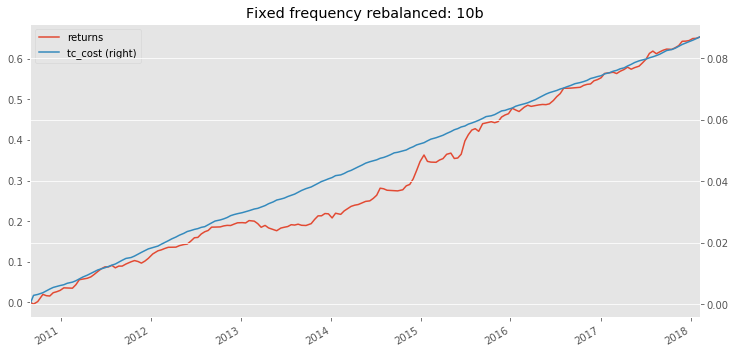

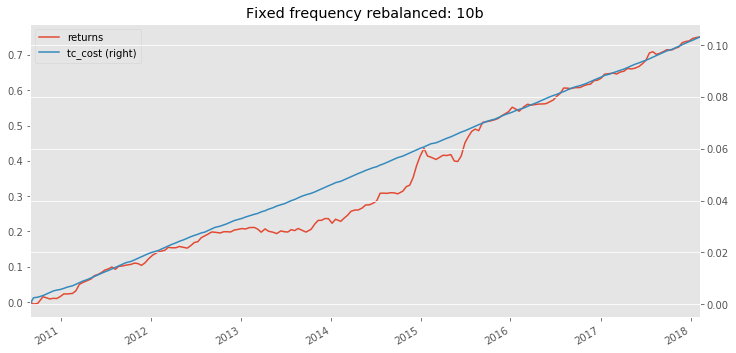

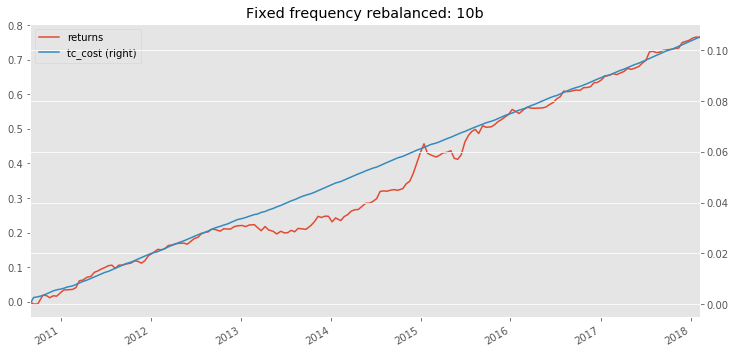

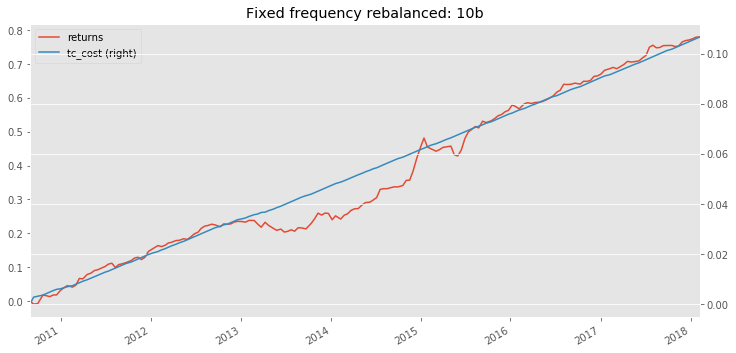

In [15]:
# Predicting and re-balance phase

weight_gaps = [0.005, 0.010, 0.015, 0.020]

model1_weight = 1.0
model2_weight = 0.5

factor_groups = const_model_factor_data.groupby('trade_date')

for s_i, weight_gap in enumerate(weight_gaps):
    print("start {0} weight gap simulation ...".format(weight_gap))

    rets = []
    turn_overs = []
    leverags = []
    previous_pos = pd.DataFrame()

    index_dates = []

    for i, value in enumerate(factor_groups):
        date = value[0]
        data = value[1]
        ref_date = date.strftime('%Y-%m-%d')

        total_data = data.fillna(data[const_model_features_keys].median())
        alpha_logger.info('{0}: {1}'.format(date, len(total_data)))
        risk_exp = total_data[neutralize_risk].values.astype(float)
        industry = total_data.industry_code.values
        benchmark_w = total_data.weight.values
        
        this_industry_data = industry_group.get_group(date)
        
        total_data = pd.merge(total_data, this_industry_data, on=['trade_date', 'code'])
        constraint_exp = total_data[constraint_risk].values
        industry = total_data.industry_name.values

        risk_exp_expand = np.concatenate((constraint_exp, np.ones((len(risk_exp), 1))), axis=1).astype(float)

        risk_names = constraint_risk + ['total']
        risk_target = risk_exp_expand.T @ benchmark_w

        lbound = np.maximum(0., benchmark_w - weight_gap)  # np.zeros(len(total_data))
        ubound = weight_gap + benchmark_w

        is_in_benchmark = (benchmark_w > 0.).astype(float)

        risk_exp_expand = np.concatenate((risk_exp_expand, is_in_benchmark.reshape((-1, 1))), axis=1).astype(float)
        risk_names.append('benchmark_total')

        constraint = Constraints(risk_exp_expand, risk_names)

        for j, name in enumerate(risk_names):
            if name == 'total':
                constraint.set_constraints(name,
                                           lower_bound=risk_target[j],
                                           upper_bound=risk_target[j])
            elif name == 'SIZE':
                base_target = abs(risk_target[j])
                constraint.set_constraints(name,
                                           lower_bound=risk_target[j] + base_target * size_risk_lower,
                                           upper_bound=risk_target[j] + base_target * size_risk_upper)
            elif name == 'benchmark_total':
                base_target = benchmark_w.sum()
                constraint.set_constraints(name,
                                           lower_bound=benchmark_total_lower * base_target,
                                           upper_bound=benchmark_total_upper * base_target)
            else:
                constraint.set_constraints(name,
                                           lower_bound=risk_target[j] * industry_lower,
                                           upper_bound=risk_target[j] * industry_upper)
        
        factor_values = factor_processing(total_data[const_model_features_keys].values,
                                          pre_process=[winsorize_normal, standardize],
                                          risk_factors=risk_exp,
                                          post_process=[winsorize_normal, standardize])

        # const linear model
        er1 = const_model.predict(factor_values)
        
        try:
            model = lasso_models_series.ix[date]
        except KeyError:
            alpha_logger.info("model is not available. Omit this date")
            continue
            
        index_dates.append(date)

        x = predict_x[date]
        this_predict_code = predict_code[date]
        er2 = model.predict(x)

        # combine model
        er1_table = pd.DataFrame({'er1': er1, 'code': total_data.code.values})
        er2_table = pd.DataFrame({'er2': er2, 'code': this_predict_code})
        er_table = pd.merge(er1_table, er2_table, on=['code'], how='left').fillna(0)

        er1 = er_table.er1.values
        er2 = er_table.er2.values
        
        if er2.std() > 0:
            print('using backbone model and alpha model')
            er = model1_weight * er1 / er1.std() +  model2_weight * er2 / er2.std()
        else:
            print('using only backbone modedl')
            er = model1_weight * er1
            
        codes = total_data['code'].values

        if previous_pos.empty:
            current_position = None
            turn_over_target = None
        else:
            previous_pos.set_index('code', inplace=True)
            remained_pos = previous_pos.loc[codes]

            remained_pos.fillna(0., inplace=True)
            turn_over_target = turn_over_target_base
            current_position = remained_pos.weight.values

        try:
            target_pos, _ = er_portfolio_analysis(er,
                                                  industry,
                                                  None,
                                                  constraint,
                                                  False,
                                                  benchmark_w,
                                                  method=method,
                                                  turn_over_target=turn_over_target,
                                                  current_position=current_position,
                                                  lbound=lbound,
                                                  ubound=ubound)
        except ValueError:
            alpha_logger.info('{0} full re-balance'.format(date))
            target_pos, _ = er_portfolio_analysis(er,
                                                  industry,
                                                  None,
                                                  constraint,
                                                  False,
                                                  benchmark_w,
                                                  method=method,
                                                  lbound=lbound,
                                                  ubound=ubound)

        target_pos['code'] = total_data['code'].values

        turn_over, executed_pos = executor.execute(target_pos=target_pos)

        executed_codes = executed_pos.code.tolist()
        dx_returns = engine.fetch_dx_return(date, executed_codes, horizon=horizon, offset=1)

        result = pd.merge(executed_pos, total_data[['code', 'weight']], on=['code'], how='inner')
        result = pd.merge(result, dx_returns, on=['code'])

        leverage = result.weight_x.abs().sum()

        ret = result.weight_x.values @ (np.exp(result.dx.values) - 1.)
        rets.append(np.log(1. + ret))
        executor.set_current(executed_pos)
        turn_overs.append(turn_over)
        leverags.append(leverage)

        previous_pos = executed_pos
        alpha_logger.info('{0} is finished'.format(date))

    ret_df = pd.DataFrame({'returns': rets, 'turn_over': turn_overs, 'leverage': leverags}, index=index_dates)

    # index return
    index_return = engine.fetch_dx_return_index_range(benchmark_code, dates=ref_dates, horizon=horizon,
                                                      offset=1).set_index('trade_date')
    ret_df['index'] = index_return['dx']

    ret_df.loc[advanceDateByCalendar('china.sse', ref_dates[-1], frequency)] = 0.
    ret_df = ret_df.shift(1)
    ret_df.iloc[0] = 0.
    ret_df['tc_cost'] = ret_df.turn_over * 0.002
    ret_df['returns'] = ret_df['leverage'] * (ret_df['returns'] - ret_df['index'])

    ret_df[['returns', 'tc_cost']].cumsum().plot(figsize=(12, 6),
                                                 title='Fixed frequency rebalanced: {0}'.format(frequency),
                                                 secondary_y='tc_cost')

    ret_df['ret_after_tc'] = ret_df['returns'] - ret_df['tc_cost']
    

    sharp_calc = MovingSharp(49)
    drawdown_calc = MovingMaxDrawdown(49)
    max_drawdown_calc = MovingMaxDrawdown(len(ret_df))

    res_df = pd.DataFrame(columns=['daily_return', 'cum_ret', 'sharp', 'drawdown', 'max_drawn', 'leverage'])

    total_returns = 0.

    for i, ret in enumerate(ret_df['ret_after_tc']):
        date = ret_df.index[i]
        total_returns += ret
        sharp_calc.push({'ret': ret, 'riskFree': 0.})
        drawdown_calc.push({'ret': ret})
        max_drawdown_calc.push({'ret': ret})

        res_df.loc[date, 'daily_return'] = ret
        res_df.loc[date, 'cum_ret'] = total_returns
        res_df.loc[date, 'drawdown'] = drawdown_calc.result()[0]
        res_df.loc[date, 'max_drawn'] = max_drawdown_calc.result()[0]
        res_df.loc[date, 'leverage'] = ret_df.loc[date, 'leverage']

        if i < 10:
            res_df.loc[date, 'sharp'] = 0.
        else:
            res_df.loc[date, 'sharp'] = sharp_calc.result() * np.sqrt(49)

    res_df.to_csv('hs300_rf_{0}.csv'.format(int(s_i)))